In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import xgboost as xgb
import os
import warnings
pd.set_option('display.max_columns', 500)
warnings.simplefilter(action='ignore', category=FutureWarning)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os

windows_path = r"C:/Users/sandi/Desktop/ML Working Folder/New York City Taxi Fare Prediction/train.csv"
linux_path = r"/mnt/c/Users/sandi/Desktop/ML Working Folder/New York City Taxi Fare Prediction/train.csv"


try:
    # Try to load the file from the Windows path
    cab_data = pd.read_csv(windows_path, nrows=1000000, parse_dates=['pickup_datetime'])
except FileNotFoundError:
    try:
        # If the file is not found on Windows, try to load it from the Linux path
        cab_data = pd.read_csv(linux_path, nrows=1000000, parse_dates=['pickup_datetime'])

        import cudf
        import cupy as cp

    except FileNotFoundError:
        # If the file is not found on Linux either, handle the error as needed
        print("Error: File not found on both Windows and Linux paths.")

In [ ]:
cab_data.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [ ]:
cab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   key                1000000 non-null  object             
 1   fare_amount        1000000 non-null  float64            
 2   pickup_datetime    1000000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   1000000 non-null  float64            
 4   pickup_latitude    1000000 non-null  float64            
 5   dropoff_longitude  999990 non-null   float64            
 6   dropoff_latitude   999990 non-null   float64            
 7   passenger_count    1000000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 61.0+ MB


In [ ]:
cab_data.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

In [ ]:
cab_data= cab_data.dropna()

In [ ]:
cab_data.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [ ]:
cab_data_numeric = cab_data.select_dtypes(include="number")

for col in cab_data_numeric.columns:
    # Find the minimum and maximum values of the numeric column
    min_value = cab_data_numeric[col].min()
    max_value = cab_data_numeric[col].max()

    # Print the column name, minimum value, and maximum value
    print(f"column_name = {col}, min_value = {min_value}, max_value = {max_value}\n")

column_name = fare_amount, min_value = -44.9, max_value = 500.0

column_name = pickup_longitude, min_value = -3377.680935, max_value = 2522.271325

column_name = pickup_latitude, min_value = -3116.285383, max_value = 2621.62843

column_name = dropoff_longitude, min_value = -3383.296608, max_value = 45.581619

column_name = dropoff_latitude, min_value = -3114.338567, max_value = 1651.553433

column_name = passenger_count, min_value = 0, max_value = 208



<span style="color: yellow; font-weight: bold;">We may note down the following discrepancies from the min and max value of each column-

<span style="color: yellow; font-weight: bold;">1. The minimum value of Erath's latitude is -90 degrees and the maximum latitude is 90 degrees, <span style="color: orange; font-weight: bold;">for NYC Taxi Service the minimum latitude is 40 degress and maximum latitude is 42 degress. </span>Similarly, the minimum value of Earth's longitude is -180 degrees and the maximum longitude is 180 degrees, <span style="color: orange; font-weight: bold;">for NYC taxi service the minimum longitude is -75 and maximum longitude is -73. </span>So we have to delete any co-ordinate that is out of these ranges.

<span style="color: yellow; font-weight: bold;">2. The minimum fare amount is shown to be negative, that can't be true, so we have to delete all the negative fares.

<span style="color: yellow; font-weight: bold;">3. The max passenger count is shown as 208 and the min passenger count is shown as zero. The max number of passengers in a cab can be upto 3 and min can't be zero otherwise there won't be any valid fare, so we have to delete anything above 3 and below 1, assuming the total number of riders in a taxi can be upto 4 including the driver.</span>

In [ ]:
filtered_cab_data = cab_data[(cab_data["fare_amount"] > 1) &
                             (cab_data["dropoff_latitude"] > 40) & (cab_data["dropoff_latitude"] < 42) & 
                             (cab_data["pickup_latitude"] > 40) & (cab_data["pickup_latitude"] < 42) &
                             (cab_data["pickup_longitude"] < -73) & (cab_data["pickup_longitude"] > -75) &
                             (cab_data["dropoff_longitude"] < -73) & (cab_data["dropoff_longitude"] > -75) &
                             (cab_data["passenger_count"] <= 3) & (cab_data["passenger_count"] > 0)]

filtered_cab_data.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [ ]:
cab_data_numeric = filtered_cab_data.select_dtypes(include="number")

for col in cab_data_numeric.columns:
    # Find the minimum and maximum values of the numeric column
    min_value = cab_data_numeric[col].min()
    max_value = cab_data_numeric[col].max()

    # Print the column name, minimum value, and maximum value
    print(f"column_name = {col}, min_value = {min_value}, max_value = {max_value}\n")

column_name = fare_amount, min_value = 2.5, max_value = 500.0

column_name = pickup_longitude, min_value = -74.968142, max_value = -73.011752

column_name = pickup_latitude, min_value = 40.052722, max_value = 41.800252

column_name = dropoff_longitude, min_value = -74.964263, max_value = -73.011777

column_name = dropoff_latitude, min_value = 40.04118, max_value = 41.92382

column_name = passenger_count, min_value = 1, max_value = 3



In [ ]:
filtered_cab_data.shape

(864790, 8)

In [ ]:
filtered_cab_data= filtered_cab_data.drop_duplicates()

In [ ]:
filtered_cab_data.shape

(864790, 8)

In [ ]:
filtered_cab_data['hour'] = filtered_cab_data['pickup_datetime'].dt.hour
filtered_cab_data['minute'] = filtered_cab_data['pickup_datetime'].dt.minute
filtered_cab_data['year'] = filtered_cab_data['pickup_datetime'].dt.year
filtered_cab_data['month'] = filtered_cab_data['pickup_datetime'].dt.month
filtered_cab_data['day'] = filtered_cab_data['pickup_datetime'].dt.day
filtered_cab_data['day_of_week'] = filtered_cab_data['pickup_datetime'].dt.weekday
filtered_cab_data['is_weekend'] = (filtered_cab_data['day_of_week'] >= 5).astype('int32')

In [ ]:
filtered_cab_data.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  
0                1    17      26  2009      6   15            0           0  
1                1    16      52  2010      1    5            1           0  
2                2     0      35  2011      8   18            3           0  
3                1     4      30  2012      4   21            5           1  
4                1     7      51  2010      3    9            1           0

In [ ]:
filtered_cab_data.isnull().mean()

key                  0.0
fare_amount          0.0
pickup_datetime      0.0
pickup_longitude     0.0
pickup_latitude      0.0
dropoff_longitude    0.0
dropoff_latitude     0.0
passenger_count      0.0
hour                 0.0
minute               0.0
year                 0.0
month                0.0
day                  0.0
day_of_week          0.0
is_weekend           0.0
dtype: float64

In [ ]:
# Define the bins
bins = [-1, 15, 30, 45, 60]
labels = [i for i in range(1, len(bins))]

# Create the new column 'minute_bin' based on binning the 'minute' column
filtered_cab_data['minute_bin'] = pd.cut(filtered_cab_data['minute'], bins=bins, labels=labels, right=False)

filtered_cab_data.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
0                1    17      26  2009      6   15            0           0   
1                1    16      52  2010      1    5            1           0   
2                2     0      35  2011      8   18            3           0   
3                1     4      30  2012      4   21            5           1   
4                1     7      51  2010      3    9            1           0   

  minute_bin  
0          2  
1          4  
2          3  
3          3  
4          4

<span style="color: yellow; font-weight: bold;"> Next we will try to calculate teh haversine distance between the pickup and dropoff locations using co-ordinates.</span>

In [ ]:
def haversine_distance(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    R = 6371  # Radius of Earth in kilometers

    phi1 = np.radians(pickup_latitude)
    phi2 = np.radians(dropoff_latitude)

    delta_phi = np.radians(dropoff_latitude - pickup_latitude)
    delta_lambda = np.radians(dropoff_longitude - pickup_longitude)

    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

# Assuming filtered_cab_data is your DataFrame
filtered_cab_data['haversine_distance_in_km'] = haversine_distance(filtered_cab_data['pickup_latitude'],
                                                    filtered_cab_data['pickup_longitude'],
                                                    filtered_cab_data['dropoff_latitude'],
                                                    filtered_cab_data['dropoff_longitude'])

filtered_cab_data.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
0                1    17      26  2009      6   15            0           0   
1                1    16      52  2010      1    5            1           0   
2                2     0      35  2011      8   18            3           0   
3                1     4      30  2012      4   21            5           1   
4                1     7      51  2010      3    9            1           0   

  minute_bin  haversine_distance_in_km  
0          2                  1.030764  
1          4                  8.450134  
2          3                  1.389525  
3          3                  2.799270  
4          4                  1.999157

In [ ]:
filtered_cab_data_shape_before= filtered_cab_data.shape[0]

filtered_cab_data_shape_before

864790

<span style="color: yellow; font-weight: bold;"> We have to filter out values with zero distance.</span>

In [ ]:
filtered_cab_data= filtered_cab_data[filtered_cab_data['haversine_distance_in_km']>0]

filtered_cab_data.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
0                1    17      26  2009      6   15            0           0   
1                1    16      52  2010      1    5            1           0   
2                2     0      35  2011      8   18            3           0   
3                1     4      30  2012      4   21            5           1   
4                1     7      51  2010      3    9            1           0   

  minute_bin  haversine_distance_in_km  
0          2                  1.030764  
1          4                  8.450134  
2          3                  1.389525  
3          3                  2.799270  
4          4                  1.999157

In [ ]:
filtered_cab_data_shape_after= filtered_cab_data.shape[0]

filtered_cab_data_shape_after

855478

In [ ]:
rows_deleted_zero_dist= filtered_cab_data_shape_before- filtered_cab_data_shape_after

print(f'Total number of rows deleted due to zero distance: {rows_deleted_zero_dist}')

Total number of rows deleted due to zero distance: 9312


<span style="color: yellow; font-weight: bold;"> Gathering information about driving distance between two points could be expensive in time and money, we amy have to use Google Maps api which is limited to 2500 requests/ day. We can also use some other apis like openstreet map but that is limited to 60 requests/ minute. So it is time and money consuming. One of the best way to get approximate same driving distance is to use Haversine distance which is a mathematical formula that is used to calculate the great-circle distance between two points on a sphere. This formula is widely used in navigation, cartography, and other fields that require accurate distance measurements. The haversine distance is calculated using the latitude and longitude of the two points, as well as the radius of the sphere. For close latitude and longitude values like in a city the Haversine distance won't vary much from the driving distance. One another way is to find an approximate correlation between haversine and driving distance of limited location in a city and then build a model to fil up the driving distances between other locations. We will try the second method to see if we can achieve the goal of finding driving distance based on the haversine distance.</span>

In [ ]:
# Sample 10,000 rows without replacement 
filtered_cab_data_sample = filtered_cab_data.sample(n=10000, replace=False)

# Or sample with replacement (rows can be picked multiple times)
filtered_cab_data_sample = filtered_cab_data.sample(n=10000, replace=True) 

# To reset index after sampling
filtered_cab_data_sample = filtered_cab_data_sample.reset_index(drop=True)

# Verify sampled dataframe size
print(len(filtered_cab_data_sample))

10000


In [ ]:
from geopy import distance
import requests
import json
import datetime
import math
import itertools

def get_distance(point1: dict, point2: dict) -> tuple:
    """Gets distance between two points en route using http://project-osrm.org/docs/v5.10.0/api/#nearest-service"""
    
    url = f"""http://router.project-osrm.org/route/v1/driving/{point1["lon"]},{point1["lat"]};{point2["lon"]},{point2["lat"]}?overview=false&alternatives=false"""
    r = requests.get(url)
    
    # get the distance from the returned values
    route = json.loads(r.content)["routes"][0]
    return (route["distance"], route["duration"])

In [ ]:
# User input for the directory path
windows_directory_path = r"C:\Users\sandi\Desktop\ML Working Folder\New York City Taxi Fare Prediction"

linux_directory_path = r"/mnt/c/Users/sandi/Desktop/ML Working Folder/New York City Taxi Fare Prediction"

# Construct the full file path
windows_file_path = os.path.join(windows_directory_path, "filtered_cab_data_sample.csv")

linux_file_path= os.path.join(linux_directory_path, "filtered_cab_data_sample.csv")

# Check if the file exists
if os.path.exists(windows_file_path):
    try:
        # Load the CSV file using Pandas
        filtered_cab_data_sample = pd.read_csv(windows_file_path)
        # Confirmation message
        print(f"File filtered_cab_data_sample.csv loaded successfully.")
    except pd.errors.EmptyDataError:
        print(f"The file '{windows_file_path}' is empty.")
    except pd.errors.ParserError:
        print(f"Error while parsing the CSV file '{windows_file_path}'.")
    except Exception as e:
        print(f"An error occurred while loading the file '{windows_file_path}': {e}")
elif os.path.exists(linux_file_path):
    try:
        # Load the CSV file using Pandas
        filtered_cab_data_sample = pd.read_csv(linux_file_path)
        # Confirmation message
        print(f"File filtered_cab_data_sample.csv loaded successfully from Linux path.")
    except pd.errors.EmptyDataError:
        print(f"The file '{linux_file_path}' is empty.")
    except pd.errors.ParserError:
        print(f"Error while parsing the CSV file '{linux_file_path}'.")
    except Exception as e:
        print(f"An error occurred while loading the file '{linux_file_path}': {e}")
else:
    filtered_cab_data_sample['driving_distance_in_km'] = None
    filtered_cab_data_sample['driving_duration_in_mins'] = None

    for i in range(len(filtered_cab_data_sample)):
        pickup_lat = filtered_cab_data_sample.loc[i, 'pickup_latitude']
        pickup_lon = filtered_cab_data_sample.loc[i, 'pickup_longitude']  
        dropoff_lat = filtered_cab_data_sample.loc[i, 'dropoff_latitude']
        dropoff_lon = filtered_cab_data_sample.loc[i, 'dropoff_longitude']

        dist_in_km = get_distance({"lat": pickup_lat, "lon": pickup_lon},  
                                  {"lat": dropoff_lat, "lon": dropoff_lon})[0] / 1000
                             
        duration_in_mins = get_distance({"lat": pickup_lat, "lon": pickup_lon},
                                        {"lat": dropoff_lat, "lon": dropoff_lon})[1] / 60

        # Append the calculated values to the DataFrame
        filtered_cab_data_sample.loc[i, 'driving_distance_in_km'] = dist_in_km
        filtered_cab_data_sample.loc[i, 'driving_duration_in_mins'] = duration_in_mins

    # Display the Pandas DataFrame
    print(f"File '{file_path}' not found. Running alternative code.")
    filtered_cab_data_sample.head()

filtered_cab_data_sample.head()

File filtered_cab_data_sample.csv loaded successfully.


key  fare_amount            pickup_datetime  \
0  2014-03-27 21:17:01.0000002          5.5  2014-03-27 21:17:01+00:00   
1  2009-01-03 10:22:50.0000002          4.9  2009-01-03 10:22:50+00:00   
2  2014-11-23 20:47:42.0000001          7.5  2014-11-23 20:47:42+00:00   
3  2010-07-17 08:29:56.0000002          7.3  2010-07-17 08:29:56+00:00   
4  2012-09-15 19:00:57.0000004         13.5  2012-09-15 19:00:57+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.964382        40.760738         -73.970213         40.749573   
1        -73.966678        40.767020         -73.953155         40.765144   
2        -73.960708        40.761284         -73.956305         40.780605   
3        -73.776759        40.645103         -73.789754         40.646753   
4        -74.001806        40.730617         -73.988265         40.762934   

   passenger_count  hour  year  month  day  day_of_week  is_weekend  \
0                1    21  2014      3   27            3           0   
1                1    10  2009      1    3            5           1   
2                1    20  2014     11   23            6           1   
3                1     8  2010      7   17            5           1   
4                2    19  2012      9   15            5           1   

   haversine_distance_in_km  driving_distance_in_km  driving_duration_in_mins  
0                  1.335114                  1.7789                  4.201667  
1                  1.157813                  1.4826                  3.350000  
2                  2.180158                  2.7790                  5.888333  
3                  1.111622                  3.2714                  6.026667  
4                  3.770195                  5.1074                 10.045000

In [ ]:
filtered_cab_data_sample_shape_before= filtered_cab_data_sample.shape[0]

filtered_cab_data_sample_shape_before

10000

In [ ]:
filtered_cab_data_sample= filtered_cab_data_sample[(filtered_cab_data_sample['haversine_distance_in_km']>0) & 
                                                   (filtered_cab_data_sample['driving_distance_in_km']>0) & 
                                                   (filtered_cab_data_sample['driving_duration_in_mins']>0)]

filtered_cab_data_sample.head()

key  fare_amount            pickup_datetime  \
0  2014-03-27 21:17:01.0000002          5.5  2014-03-27 21:17:01+00:00   
1  2009-01-03 10:22:50.0000002          4.9  2009-01-03 10:22:50+00:00   
2  2014-11-23 20:47:42.0000001          7.5  2014-11-23 20:47:42+00:00   
3  2010-07-17 08:29:56.0000002          7.3  2010-07-17 08:29:56+00:00   
4  2012-09-15 19:00:57.0000004         13.5  2012-09-15 19:00:57+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.964382        40.760738         -73.970213         40.749573   
1        -73.966678        40.767020         -73.953155         40.765144   
2        -73.960708        40.761284         -73.956305         40.780605   
3        -73.776759        40.645103         -73.789754         40.646753   
4        -74.001806        40.730617         -73.988265         40.762934   

   passenger_count  hour  year  month  day  day_of_week  is_weekend  \
0                1    21  2014      3   27            3           0   
1                1    10  2009      1    3            5           1   
2                1    20  2014     11   23            6           1   
3                1     8  2010      7   17            5           1   
4                2    19  2012      9   15            5           1   

   haversine_distance_in_km  driving_distance_in_km  driving_duration_in_mins  
0                  1.335114                  1.7789                  4.201667  
1                  1.157813                  1.4826                  3.350000  
2                  2.180158                  2.7790                  5.888333  
3                  1.111622                  3.2714                  6.026667  
4                  3.770195                  5.1074                 10.045000

In [ ]:
filtered_cab_data_sample_shape_after= filtered_cab_data_sample.shape[0]

filtered_cab_data_sample_shape_after

9896

In [ ]:
rows_deleted_zero_dist= filtered_cab_data_sample_shape_before- filtered_cab_data_sample_shape_after

print(f"Total no.of rows deleted due to zero driving distance: {rows_deleted_zero_dist}")

Total no.of rows deleted due to zero driving distance: 104


In [ ]:
# Sorting the DataFrame by the 'year' column
filtered_cab_data_sample = filtered_cab_data_sample.sort_values(by='year')

filtered_cab_data_sample.head()

key  fare_amount            pickup_datetime  \
5351  2009-09-07 20:48:00.000000157        11.70  2009-09-07 20:48:00+00:00   
2746  2009-11-17 19:41:00.000000100         5.70  2009-11-17 19:41:00+00:00   
7703   2009-01-19 20:40:00.00000021         6.90  2009-01-19 20:40:00+00:00   
4019  2009-06-11 21:39:00.000000112         8.90  2009-06-11 21:39:00+00:00   
2752    2009-08-31 10:22:01.0000002        49.57  2009-08-31 10:22:01+00:00   

      pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
5351        -73.971370        40.757367         -74.010373         40.716070   
2746        -73.986457        40.768100         -74.002897         40.760395   
7703        -74.000998        40.731648         -73.980397         40.741693   
4019        -73.975907        40.744752         -73.950553         40.775342   
2752        -73.788289        40.654447         -73.980714         40.764839   

      passenger_count  hour  year  month  day  day_of_week  is_weekend  \
5351                2    20  2009      9    7            0           0   
2746                1    19  2009     11   17            1           0   
7703                1    20  2009      1   19            0           0   
4019                1    21  2009      6   11            3           0   
2752                2    10  2009      8   31            0           0   

      haversine_distance_in_km  driving_distance_in_km  \
5351                  5.646726                  6.2183   
2746                  1.628206                  2.3331   
7703                  2.064053                  2.8087   
4019                  4.016211                  4.8370   
2752                 20.340571                 27.0356   

      driving_duration_in_mins  
5351                 13.136667  
2746                  3.891667  
7703                  6.343333  
4019                  7.866667  
2752                 27.813333

In [ ]:
filtered_cab_data_distance= filtered_cab_data_sample[['haversine_distance_in_km','driving_distance_in_km', 'driving_duration_in_mins']]

filtered_cab_data_distance.head()

haversine_distance_in_km  driving_distance_in_km  \
5351                  5.646726                  6.2183   
2746                  1.628206                  2.3331   
7703                  2.064053                  2.8087   
4019                  4.016211                  4.8370   
2752                 20.340571                 27.0356   

      driving_duration_in_mins  
5351                 13.136667  
2746                  3.891667  
7703                  6.343333  
4019                  7.866667  
2752                 27.813333

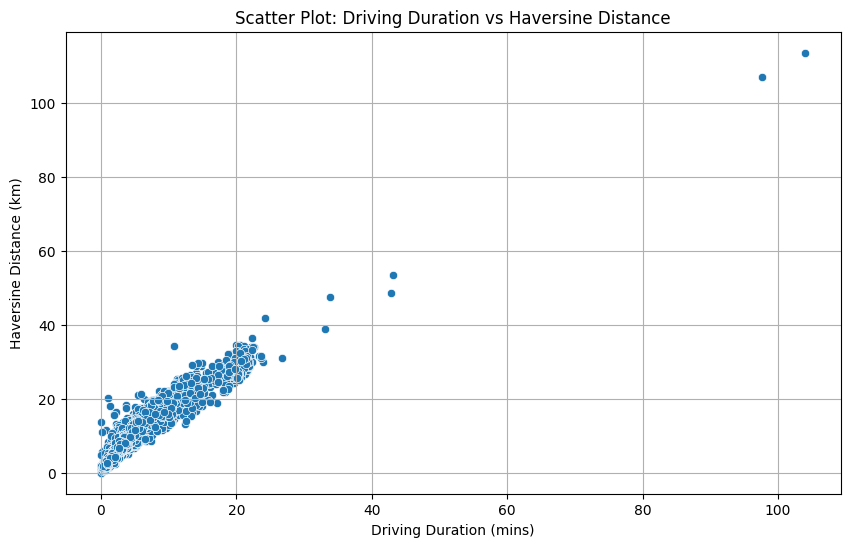

In [ ]:
plt.figure(figsize=(10, 6))

# Use Seaborn to create the scatter plot
sns.scatterplot(x='haversine_distance_in_km', y='driving_duration_in_mins', data=filtered_cab_data_distance)

# Add labels and title
plt.xlabel('Driving Duration (mins)')
plt.ylabel('Haversine Distance (km)')
plt.title('Scatter Plot: Driving Duration vs Haversine Distance')

# Show the plot
plt.grid(True)
plt.show()

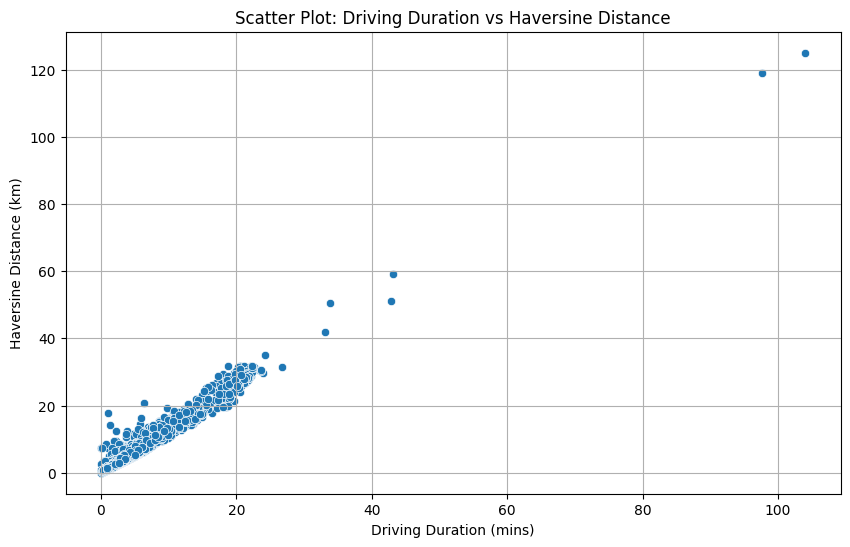

In [ ]:
plt.figure(figsize=(10, 6))

# Use Seaborn to create the scatter plot
sns.scatterplot(x='haversine_distance_in_km', y='driving_distance_in_km', data=filtered_cab_data_distance)

# Add labels and title
plt.xlabel('Driving Duration (mins)')
plt.ylabel('Haversine Distance (km)')
plt.title('Scatter Plot: Driving Duration vs Haversine Distance')

# Show the plot
plt.grid(True)
plt.show()

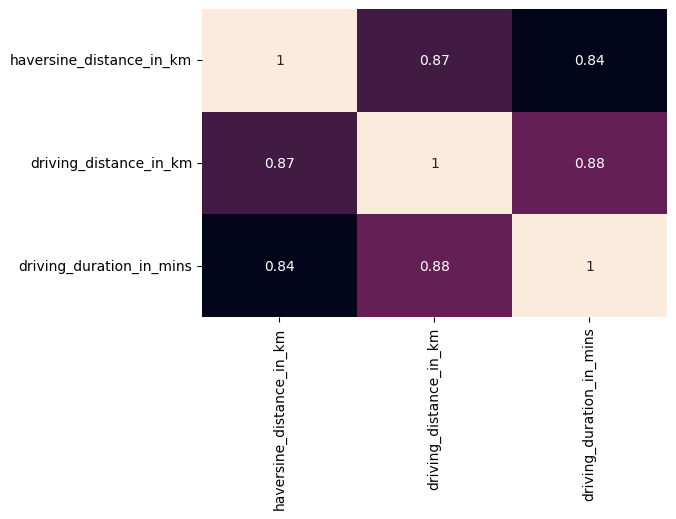

In [ ]:
# Set the figure size
plt.figure(figsize=(6, 4))

# Create a heatmap using Seaborn
sns.heatmap(filtered_cab_data_distance.corr(method='kendall'), cbar=False, annot=True)

# Show the plot
plt.show()

In [ ]:
filtered_cab_data_sample['year'].unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype=int64)

<span style="color: yellow; font-weight: bold;"> So, from the above heatmap, it is clear that our assumption that haversine_distance and driving distance are close for nearby locations. Next is building a model that can quickly predict the driving distance and duration for other rows in the original dataset. Although these three features are highly correlated and may not bring any additional information while building a model, having these features (especially the driving duration) may be helpful while trying various features in building the final model. So, what we will do next is try to build a model (if possible, with linear regression) that can predict the duration for other rows in the original dataset.</span>

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

rows_upto_2014= filtered_cab_data_sample[filtered_cab_data_sample['year']<=2014]
rows_after_2014= filtered_cab_data_sample[filtered_cab_data_sample['year']>2014]

X_train= rows_upto_2014[['haversine_distance_in_km']]
X_test= rows_after_2014[['haversine_distance_in_km']]
y_train= rows_upto_2014['driving_duration_in_mins']
y_test= rows_after_2014['driving_duration_in_mins']

# Standardize the features (Min-Max scaling)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Standardize the target variable (Min-Max scaling)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Create a linear regression model
lr_model = LinearRegression()

# Train the model on the scaled training data
lr_model.fit(X_train_scaled, y_train_scaled)

# Predict the driving duration for the test data
y_pred_scaled = lr_model.predict(X_test_scaled)

# Invert the scaling to get predictions in the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Get the coefficient (slope) and intercept (intercept) values
slope = lr_model.coef_[0][0]
intercept = lr_model.intercept_

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Coefficient (Slope): {slope}")
print(f"Intercept: {intercept}")

Root Mean Squared Error (RMSE): 1.6828746842186917
R-squared (R2): 0.915499505642081
Coefficient (Slope): 1.3236892340618638
Intercept: [0.02337771]


In [ ]:
# Assuming 'filtered_cab_data' is your DataFrame
filtered_cab_data['driving_duration_in_mins'] = slope * filtered_cab_data['haversine_distance_in_km'] + intercept* filtered_cab_data_sample['driving_duration_in_mins'].max()

filtered_cab_data.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
0                1    17      26  2009      6   15            0           0   
1                1    16      52  2010      1    5            1           0   
2                2     0      35  2011      8   18            3           0   
3                1     4      30  2012      4   21            5           1   
4                1     7      51  2010      3    9            1           0   

  minute_bin  haversine_distance_in_km  driving_duration_in_mins  
0          2                  1.030764                  4.016573  
1          4                  8.450134                 13.837513  
2          3                  1.389525                  4.491462  
3          3                  2.799270                  6.357526  
4          4                  1.999157                  5.298425

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

rows_upto_2014= filtered_cab_data_sample[filtered_cab_data_sample['year']<=2014]
rows_after_2014= filtered_cab_data_sample[filtered_cab_data_sample['year']>2014]

X_train= rows_upto_2014[['haversine_distance_in_km']]
X_test= rows_after_2014[['haversine_distance_in_km']]
y_train= rows_upto_2014['driving_distance_in_km']
y_test= rows_after_2014['driving_distance_in_km']

# Standardize the features (Min-Max scaling)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Standardize the target variable (Min-Max scaling)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Create a linear regression model
lr_model = LinearRegression()

# Train the model on the scaled training data
lr_model.fit(X_train_scaled, y_train_scaled)

# Predict the driving duration for the test data
y_pred_scaled = lr_model.predict(X_test_scaled)

# Invert the scaling to get predictions in the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Get the coefficient (slope) and intercept (intercept) values
slope = lr_model.coef_[0][0]
intercept = lr_model.intercept_

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Coefficient (Slope): {slope}")
print(f"Intercept: {intercept}")

Root Mean Squared Error (RMSE): 0.7813706835433863
R-squared (R2): 0.9744985295776154
Coefficient (Slope): 1.0952695463996929
Intercept: [0.00045433]


In [ ]:
# Assuming 'filtered_cab_data' is your DataFrame
filtered_cab_data['driving_distance_in_km'] = slope * filtered_cab_data['haversine_distance_in_km'] + intercept* filtered_cab_data_sample['driving_distance_in_km'].max()

filtered_cab_data.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
0                1    17      26  2009      6   15            0           0   
1                1    16      52  2010      1    5            1           0   
2                2     0      35  2011      8   18            3           0   
3                1     4      30  2012      4   21            5           1   
4                1     7      51  2010      3    9            1           0   

  minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0          2                  1.030764                  4.016573   
1          4                  8.450134                 13.837513   
2          3                  1.389525                  4.491462   
3          3                  2.799270                  6.357526   
4          4                  1.999157                  5.298425   

   driving_distance_in_km  
0                1.185770  
1                9.311980  
2                1.578711  
3                3.122761  
4                2.246422

In [ ]:
import calendar
import holidays

# Define a list to store the holidays
holiday_list = []

# Iterate over unique years in the 'year' column
for year in filtered_cab_data['year'].unique():
    # Convert the year to a regular integer
    year = int(year)
    
    # Generate holidays for the specific year
    year_holidays = holidays.UnitedStates(years=year)
    
    # Extend the list with the holidays for this year
    holiday_list.extend(year_holidays)

print(holiday_list)

[datetime.date(2009, 1, 19), datetime.date(2009, 2, 16), datetime.date(2009, 10, 12), datetime.date(2009, 1, 1), datetime.date(2009, 5, 25), datetime.date(2009, 7, 4), datetime.date(2009, 7, 3), datetime.date(2009, 9, 7), datetime.date(2009, 11, 11), datetime.date(2009, 11, 26), datetime.date(2009, 12, 25), datetime.date(2010, 1, 18), datetime.date(2010, 2, 15), datetime.date(2010, 10, 11), datetime.date(2010, 1, 1), datetime.date(2010, 12, 31), datetime.date(2010, 5, 31), datetime.date(2010, 7, 4), datetime.date(2010, 7, 5), datetime.date(2010, 9, 6), datetime.date(2010, 11, 11), datetime.date(2010, 11, 25), datetime.date(2010, 12, 25), datetime.date(2010, 12, 24), datetime.date(2011, 1, 17), datetime.date(2011, 2, 21), datetime.date(2011, 10, 10), datetime.date(2011, 1, 1), datetime.date(2011, 5, 30), datetime.date(2011, 7, 4), datetime.date(2011, 9, 5), datetime.date(2011, 11, 11), datetime.date(2011, 11, 24), datetime.date(2011, 12, 25), datetime.date(2011, 12, 26), datetime.date(2

In [ ]:

# Extract the date part (YYYY-MM-DD) from the 'pickup_datetime' column
filtered_cab_data['pickup_date'] = filtered_cab_data['pickup_datetime'].dt.date

# Check if each 'pickup_date' value exists in the 'holiday_list' series and create the 'is_holiday' column
filtered_cab_data['is_holiday'] = filtered_cab_data['pickup_date'].isin(holiday_list).astype(int)

# Drop the temporary 'pickup_date' column if you don't need it
filtered_cab_data.drop(columns=['pickup_date'], inplace=True)

In [ ]:
filtered_cab_data.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
0                1    17      26  2009      6   15            0           0   
1                1    16      52  2010      1    5            1           0   
2                2     0      35  2011      8   18            3           0   
3                1     4      30  2012      4   21            5           1   
4                1     7      51  2010      3    9            1           0   

  minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0          2                  1.030764                  4.016573   
1          4                  8.450134                 13.837513   
2          3                  1.389525                  4.491462   
3          3                  2.799270                  6.357526   
4          4                  1.999157                  5.298425   

   driving_distance_in_km  is_holiday  
0                1.185770           0  
1                9.311980           0  
2                1.578711           0  
3                3.122761           0  
4                2.246422           0

In [ ]:
filtered_cab_data['is_holiday'].unique()

array([0, 1])

<span style="color: yellow; font-weight: bold;"> There is no use of the feature named as key, it only serves as a unique non-null value for each ride, so we amy remove this feature.</span>

<span style="color: yellow; font-weight: bold;"> As this is Taxi fare data and we know there are many factors which affect the price of taxi like

<span style="color: yellow; font-weight: bold;">1. Travelled distance

<span style="color: yellow; font-weight: bold;">2. Time of Travel

<span style="color: yellow; font-weight: bold;">3. Availability of number of taxis at that place at a particular time

<span style="color: yellow; font-weight: bold;">4. Some special places are more costlier like Airport or other places where there might be toll</span>

<span style="color: yellow; font-weight: bold;"> To mark the co-ordinates or cluster of co-ordinates which has high fare we will build a model with distance vs fare and try to evaluate which fares are more than usual based on distances. Same can be done with distance and time of the day to spot the times of high demand.


<span style="color: yellow; font-weight: bold;">A simple linear regression model will serve our purpose.</span>

In [ ]:
filtered_cab_data_columns= list(cab_data.columns)

filtered_cab_data_columns

['key',
 'fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [ ]:
filtered_cab_data_train= filtered_cab_data[filtered_cab_data['year']<=2014]
filtered_cab_data_test= filtered_cab_data[filtered_cab_data['year']>2014]

In [ ]:
filtered_cab_data_train.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
0                1    17      26  2009      6   15            0           0   
1                1    16      52  2010      1    5            1           0   
2                2     0      35  2011      8   18            3           0   
3                1     4      30  2012      4   21            5           1   
4                1     7      51  2010      3    9            1           0   

  minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0          2                  1.030764                  4.016573   
1          4                  8.450134                 13.837513   
2          3                  1.389525                  4.491462   
3          3                  2.799270                  6.357526   
4          4                  1.999157                  5.298425   

   driving_distance_in_km  is_holiday  
0                1.185770           0  
1                9.311980           0  
2                1.578711           0  
3                3.122761           0  
4                2.246422           0

In [ ]:
filtered_cab_data_test.head()

key  fare_amount           pickup_datetime  \
31  2015-06-21 21:46:34.0000001        22.54 2015-06-21 21:46:34+00:00   
35  2015-01-11 03:15:38.0000001        58.00 2015-01-11 03:15:38+00:00   
36  2015-03-12 08:08:38.0000001         4.50 2015-03-12 08:08:38+00:00   
69  2015-05-12 23:51:42.0000007         5.00 2015-05-12 23:51:42+00:00   
89  2015-03-04 14:55:40.0000006         5.00 2015-03-04 14:55:40+00:00   

    pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
31        -74.010483        40.717667         -73.985771         40.660366   
35        -73.983330        40.738720         -73.933197         40.847225   
36        -73.990173        40.756447         -73.985619         40.762829   
69        -73.954796        40.779335         -73.944931         40.780087   
89        -73.988747        40.744953         -73.995682         40.744221   

    passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
31                1    21      46  2015      6   21            6           1   
35                1     3      15  2015      1   11            6           1   
36                1     8       8  2015      3   12            3           0   
69                1    23      51  2015      5   12            1           0   
89                2    14      55  2015      3    4            2           0   

   minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
31          4                  6.703551                 11.525581   
35          2                 12.782056                 19.571632   
36          1                  0.806699                  3.719981   
69          4                  0.834807                  3.757187   
89          4                  0.589893                  3.432997   

    driving_distance_in_km  is_holiday  
31                7.399002           0  
35               14.056602           0  
36                0.940359           0  
69                0.971145           0  
89                0.702898           0

In [ ]:
cab_data_numeric= filtered_cab_data_train[['fare_amount', 'passenger_count', 'haversine_distance_in_km', 'driving_duration_in_mins', 'driving_distance_in_km']]

cab_data_numeric.describe()

fare_amount  passenger_count  haversine_distance_in_km  \
count  794872.000000    794872.000000             794872.000000   
mean       11.194791         1.268366                  3.358504   
std         9.503672         0.544038                  3.785020   
min         2.500000         1.000000                  0.000084   
25%         6.000000         1.000000                  1.281354   
50%         8.500000         1.000000                  2.178613   
75%        12.500000         1.000000                  3.944569   
max       450.000000         3.000000                116.135048   

       driving_duration_in_mins  driving_distance_in_km  
count             794872.000000           794872.000000  
mean                   7.097778                3.735273  
std                    5.010190                4.145617  
min                    2.652273                0.056898  
25%                    4.348277                1.460234  
50%                    5.535969                2.442974  
75%                    7.873545                4.377172  
max                  156.378875              127.255988

C:\Users\sandi\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


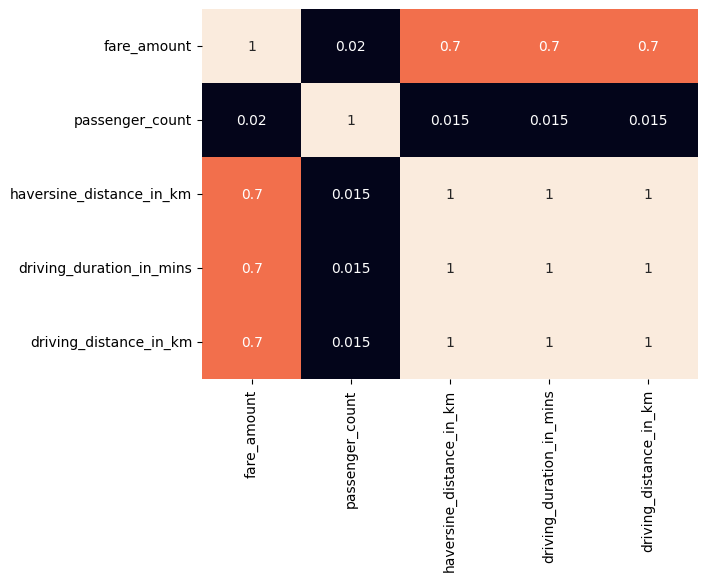

In [ ]:
sns.heatmap(cab_data_numeric.corr(method='kendall'), cbar=False, annot= True)

plt.show()

<span style="color: yellow; font-weight: bold;"> From the above correlation heatmap we can see that- haversine_distance_in_km, driving_duration_in_mins	and driving_distance_in_km

<span style="color: yellow; font-weight: bold;">has correlation of one so we will train a linear regression model with one of this (say, haversine_distance or driving duration) to flag which places or time are charging more than usual.</span>

In [ ]:
fare_distance = filtered_cab_data_train[['haversine_distance_in_km', 'fare_amount', 'driving_distance_in_km', 'driving_duration_in_mins']]

fare_distance = pd.DataFrame(fare_distance)

fare_distance.reset_index(drop=True).head()

haversine_distance_in_km  fare_amount  driving_distance_in_km  \
0                  1.030764          4.5                1.185770   
1                  8.450134         16.9                9.311980   
2                  1.389525          5.7                1.578711   
3                  2.799270          7.7                3.122761   
4                  1.999157          5.3                2.246422   

   driving_duration_in_mins  
0                  4.016573  
1                 13.837513  
2                  4.491462  
3                  6.357526  
4                  5.298425

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the DataFrame
fare_distance_scaled = scaler.fit_transform(fare_distance)

# Create a new DataFrame with the scaled values
fare_distance_scaled = pd.DataFrame(fare_distance_scaled, columns=fare_distance.columns)

In [ ]:
fare_distance_scaled.head()

haversine_distance_in_km  fare_amount  driving_distance_in_km  \
0                  0.008875     0.004469                0.008875   
1                  0.072761     0.032179                0.072761   
2                  0.011964     0.007151                0.011964   
3                  0.024103     0.011620                0.024103   
4                  0.017213     0.006257                0.017213   

   driving_duration_in_mins  
0                  0.008875  
1                  0.072761  
2                  0.011964  
3                  0.024103  
4                  0.017213

In [ ]:
fare_distance= fare_distance_scaled

<span style="color: yellow; font-weight: bold;"> Rather than considering the distances a more logical approach will be to consider the driving duration as some trips may be round trips or there may be traffic conditions involved, so considering time may be important.</span>

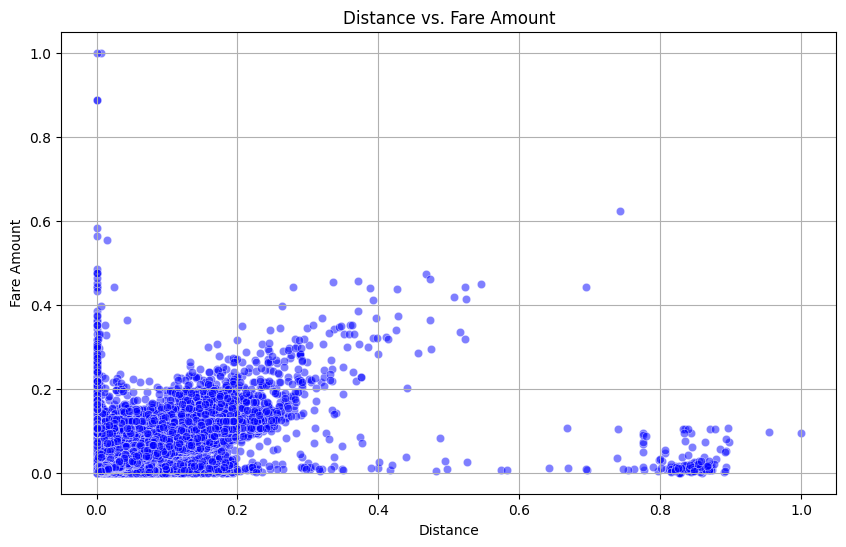

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plot of distance vs. fare_amount
sns.scatterplot(x='driving_duration_in_mins', y='fare_amount', data=fare_distance, color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Distance')
plt.ylabel('Fare Amount')
plt.title('Distance vs. Fare Amount')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Define the features (X) and target (y)
X = fare_distance[['driving_duration_in_mins']]
y = fare_distance['fare_amount']

# Split the data into training and testing sets (e.g., 80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict the fare amounts for the test data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rmse= mse**0.5

# Calculate the R-squared value
r2 = r2_score(y_test, y_pred)

# Get the coefficient (slope) and intercept (intercept) values
slope = model.coef_[0]
intercept = model.intercept_

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Coefficient (Slope): {slope}")
print(f"Intercept: {intercept}")

Mean Squared Error (MSE): 0.00014238678520878375
Mean Squared Error (RMSE): 0.011932593398284539
R-squared (R2): 0.6811226939290284
Coefficient (Slope): 0.5299356124716422
Intercept: 0.0041085928841883


In [ ]:
filtered_cab_data_train['expected_fare']= slope*filtered_cab_data_train['driving_duration_in_mins']+ intercept*filtered_cab_data_train['fare_amount'].max()

filtered_cab_data_train.head()

C:\Users\sandi\AppData\Local\Temp\ipykernel_15652\3771908086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cab_data_train['expected_fare']= slope*filtered_cab_data_train['driving_duration_in_mins']+ intercept*filtered_cab_data_train['fare_amount'].max()


key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
0                1    17      26  2009      6   15            0           0   
1                1    16      52  2010      1    5            1           0   
2                2     0      35  2011      8   18            3           0   
3                1     4      30  2012      4   21            5           1   
4                1     7      51  2010      3    9            1           0   

  minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0          2                  1.030764                  4.016573   
1          4                  8.450134                 13.837513   
2          3                  1.389525                  4.491462   
3          3                  2.799270                  6.357526   
4          4                  1.999157                  5.298425   

   driving_distance_in_km  is_holiday  expected_fare  
0                1.185770           0       3.977392  
1                9.311980           0       9.181858  
2                1.578711           0       4.229052  
3                3.122761           0       5.217946  
4                2.246422           0       4.656691

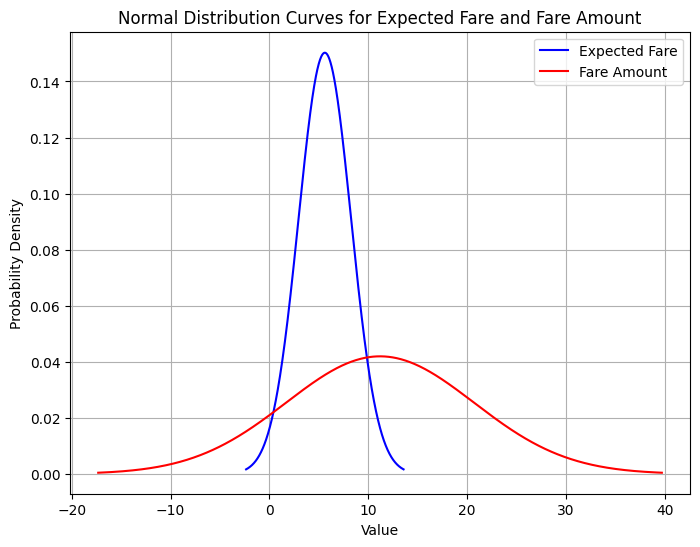

In [ ]:
mu_expected_fare = filtered_cab_data_train['expected_fare'].mean()
sigma_expected_fare = filtered_cab_data_train['expected_fare'].std()

mu_fare_amount = filtered_cab_data_train['fare_amount'].mean()
sigma_fare_amount = filtered_cab_data_train['fare_amount'].std()

# Generating data points for normal distribution curves
x_expected_fare = np.linspace(mu_expected_fare - 3 * sigma_expected_fare, mu_expected_fare + 3 * sigma_expected_fare, 1000)
y_expected_fare = (1 / (sigma_expected_fare * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_expected_fare - mu_expected_fare) / sigma_expected_fare) ** 2)

x_fare_amount = np.linspace(mu_fare_amount - 3 * sigma_fare_amount, mu_fare_amount + 3 * sigma_fare_amount, 1000)
y_fare_amount = (1 / (sigma_fare_amount * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_fare_amount - mu_fare_amount) / sigma_fare_amount) ** 2)

# Plotting the normal distribution curves
plt.figure(figsize=(8, 6))
plt.plot(x_expected_fare, y_expected_fare, color='blue', label='Expected Fare')
plt.plot(x_fare_amount, y_fare_amount, color='red', label='Fare Amount')

plt.title('Normal Distribution Curves for Expected Fare and Fare Amount')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)

plt.show()


<span style="color: yellow; font-weight: bold;"> As evident from the above graphs the expecetd fare amount can explain only  acertain portion of the fare amoount curve.</span>

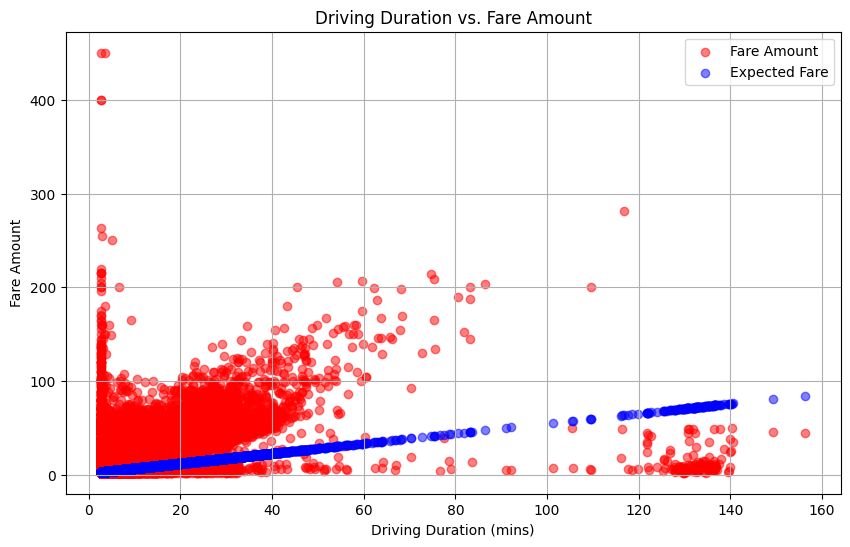

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plot of fare_amount
plt.scatter(filtered_cab_data_train['driving_duration_in_mins'], filtered_cab_data_train['fare_amount'], marker='o', color='red', alpha=0.5, label='Fare Amount')

# Scatter plot of expected_fare
plt.scatter(filtered_cab_data_train['driving_duration_in_mins'], filtered_cab_data_train['expected_fare'], marker='o', color='blue', alpha=0.5, label='Expected Fare')

# Add labels and title
plt.xlabel('Driving Duration (mins)')
plt.ylabel('Fare Amount')
plt.title('Driving Duration vs. Fare Amount')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

<span style="color: yellow; font-weight: bold;"> As we can see for very high and low values the expected fare amount is far away from the actual fare amount. To flag which data points has absurd pricing of fare we will define a value called as fare_ratio which will define the ratio of charge fare amount to expected fare amount. Very high or unusually low fare amount would be condiered as outliers in thsi case.</span>

In [ ]:
filtered_cab_data_train['fare_ratio']= filtered_cab_data_train['fare_amount']/ filtered_cab_data_train['expected_fare']

filtered_cab_data_train.head()

C:\Users\sandi\AppData\Local\Temp\ipykernel_15652\3458739115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cab_data_train['fare_ratio']= filtered_cab_data_train['fare_amount']/ filtered_cab_data_train['expected_fare']


key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
0                1    17      26  2009      6   15            0           0   
1                1    16      52  2010      1    5            1           0   
2                2     0      35  2011      8   18            3           0   
3                1     4      30  2012      4   21            5           1   
4                1     7      51  2010      3    9            1           0   

  minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0          2                  1.030764                  4.016573   
1          4                  8.450134                 13.837513   
2          3                  1.389525                  4.491462   
3          3                  2.799270                  6.357526   
4          4                  1.999157                  5.298425   

   driving_distance_in_km  is_holiday  expected_fare  fare_ratio  
0                1.185770           0       3.977392    1.131395  
1                9.311980           0       9.181858    1.840586  
2                1.578711           0       4.229052    1.347820  
3                3.122761           0       5.217946    1.475676  
4                2.246422           0       4.656691    1.138147

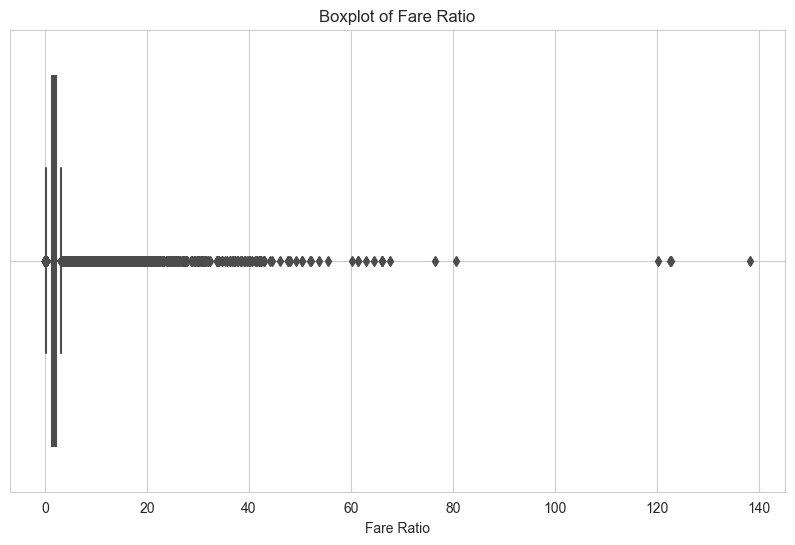

In [ ]:
# Set the style of the plot (optional)
sns.set_style("whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))

# Boxplot of fare_ratio
sns.boxplot(x=filtered_cab_data_train['fare_ratio'], color='orange')

# Add labels and title
plt.xlabel('Fare Ratio')
plt.title('Boxplot of Fare Ratio')

# Show the plot
plt.grid(True)
plt.show()

<span style="color: yellow; font-weight: bold;"> As we can see the fare_ratio has many outliers when we try to calculate the fare_amount with respect to driving durations in mins using a simple linear regression model.</span>

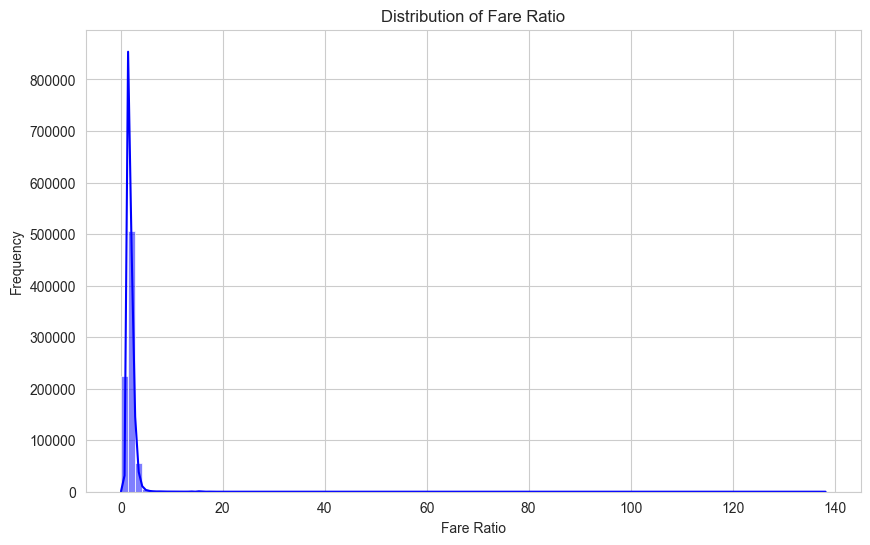

In [ ]:
sns.set_style("whitegrid")

# Plot the histogram with KDE
plt.figure(figsize=(10, 6))

# Create a histogram with a KDE overlaid
sns.histplot(filtered_cab_data_train['fare_ratio'], bins=100, kde=True, color='b')

# Add labels and title
plt.xlabel('Fare Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Fare Ratio')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
data = filtered_cab_data_train['fare_ratio']

# Calculate Mean
mean = np.mean(data)

# Calculate Median
median = np.median(data)

# Calculate Mode
mode = data.mode()[0]
# Calculate Skewness
skewness = data.skew()

print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)
print("Skewness:", skewness)

Mean: 1.8560982744408212
Median: 1.6944409779775786
Mode: 0.7681860387465455
Skewness: 22.072997178568297


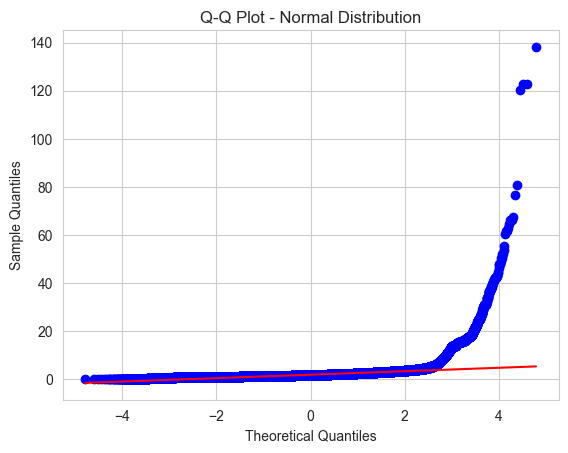

In [ ]:
import scipy.stats as stats

data = filtered_cab_data_train['fare_ratio']
# Creating Q-Q plot
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot - Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

<span style="color: yellow; font-weight: bold;"> As we can see, the 'fare_ratio' column doesn't follow a noral distribution and has many outliers. We will try a logarithmic value of the column to if we can have  normal disribution of fare_ratio.</span>

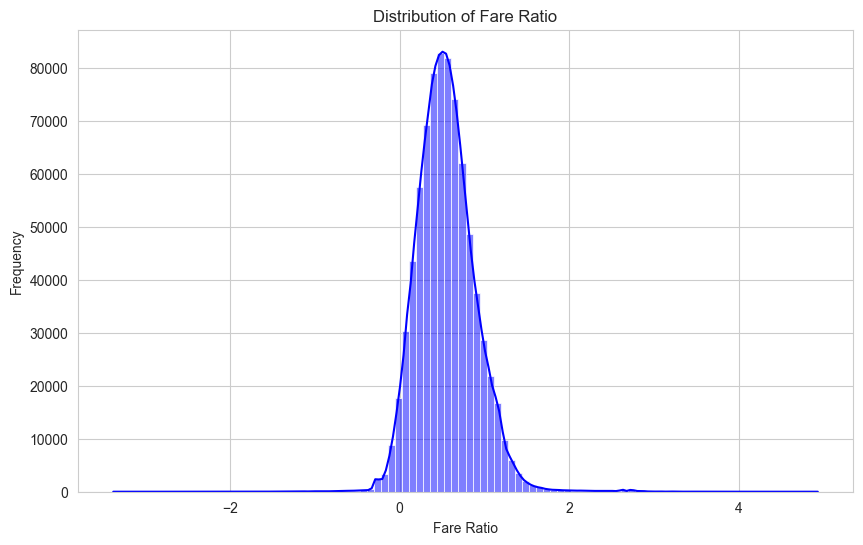

In [ ]:
sns.set_style("whitegrid")

# Plot the histogram with KDE
plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Create a histogram with a KDE overlaid
sns.histplot(np.log(filtered_cab_data_train['fare_ratio']), bins=100, kde=True, color='b')

# Add labels and title
plt.xlabel('Fare Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Fare Ratio')

# Show the plot
plt.grid(True)
plt.show()

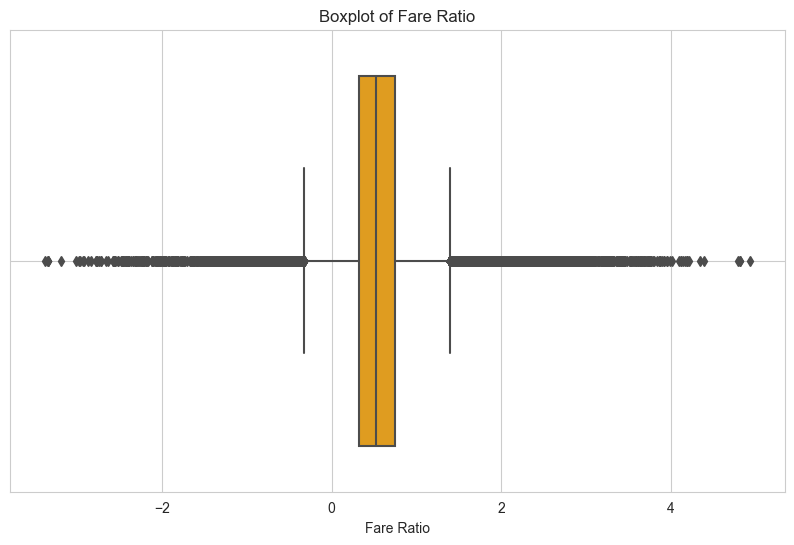

In [ ]:
# Set the style of the plot (optional)
sns.set_style("whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))

# Boxplot of fare_ratio
sns.boxplot(x= np.log(filtered_cab_data_train['fare_ratio']), color='orange')

# Add labels and title
plt.xlabel('Fare Ratio')
plt.title('Boxplot of Fare Ratio')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
data = np.log(filtered_cab_data_train['fare_ratio'])

# Calculate Mean
mean = np.mean(data)

# Calculate Median
median = np.median(data)

# Calculate Mode
mode = data.mode()[0]
# Calculate Skewness
skewness = data.skew()

print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)
print("Skewness:", skewness)

Mean: 0.5488577119874842
Median: 0.5273528799313842
Mode: -0.2637233372181091
Skewness: 0.7038390096492528


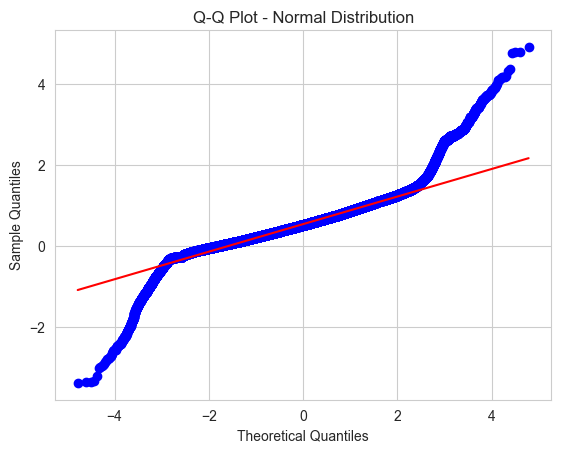

In [ ]:
import scipy.stats as stats

data = np.log(filtered_cab_data_train['fare_ratio'])
# Creating Q-Q plot
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot - Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

<span style="color: yellow; font-weight: bold;"> The above plots show that some part of the logarithm of fare ratio data follows a normal distribution.</span>

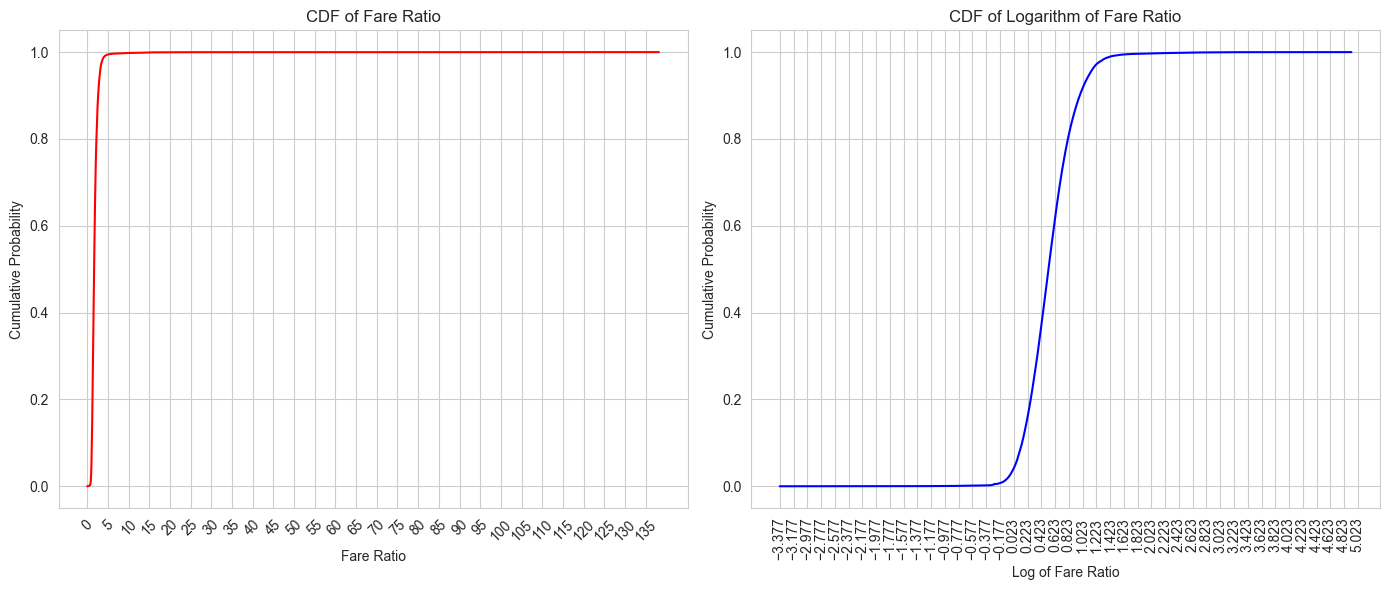

In [ ]:
data = filtered_cab_data_train['fare_ratio']

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# CDF of the original data
sorted_data = np.sort(data)
yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
axs[0].plot(sorted_data, yvals, color='r')
axs[0].set_xlabel('Fare Ratio')
axs[0].set_ylabel('Cumulative Probability')
axs[0].set_title('CDF of Fare Ratio')
axs[0].set_xticks(np.arange(min(sorted_data), max(sorted_data) + 1, 5)) 
axs[0].tick_params(axis='x', rotation=45)

# CDF of the logarithm of the data
log_data = np.log(data)
sorted_log_data = np.sort(log_data)
yvals_log = np.arange(len(sorted_log_data)) / float(len(sorted_log_data))
axs[1].plot(sorted_log_data, yvals_log, color='b')
axs[1].set_xlabel('Log of Fare Ratio')
axs[1].set_ylabel('Cumulative Probability')
axs[1].set_title('CDF of Logarithm of Fare Ratio')
axs[1].set_xticks(np.arange(min(sorted_log_data), max(sorted_log_data) + 0.2, 0.2))
axs[1].tick_params(axis='x', rotation=90)

# Display the plots
plt.tight_layout()
plt.show()

<span style="color: yellow; font-weight: bold;"> Based on the CDF above we see the fare ratio above 5 are rare while looking at the logarithm we can see fare ratio below -0.377 and above 1.423 are rare. We can label the data points in fare_ratio column based on it's logarithmic values, as the logrithm of fare_ratio follows a normal distrbution we can label the data pint avlues as  follows, as shown in the code below-</span>

In [ ]:
# Calculate mean and standard deviation of 'fare_ratio'
fare_ratio_log_mean = np.log(filtered_cab_data_train['fare_ratio']).mean()
fare_ratio_log_std = np.log(filtered_cab_data_train['fare_ratio']).std()

# Define boundaries based on standard deviations from the mean
lower_bound_3std = fare_ratio_log_mean - 3 * fare_ratio_log_std
lower_bound_2std = fare_ratio_log_mean - 2 * fare_ratio_log_std
lower_bound_1std = fare_ratio_log_mean - fare_ratio_log_std
upper_bound_1std = fare_ratio_log_mean + fare_ratio_log_std
upper_bound_2std = fare_ratio_log_mean + 2 * fare_ratio_log_std
upper_bound_3std = fare_ratio_log_mean + 3 * fare_ratio_log_std

# Function to label fare_ratio based on boundaries
def label_fare_ratio(row):
    if row <= lower_bound_3std:
        return 'unusually low'
    elif row >= upper_bound_3std:
        return 'unusually high'
    elif lower_bound_3std < row <= lower_bound_1std:
        return 'low'
    elif lower_bound_1std < row <= fare_ratio_log_mean or fare_ratio_log_mean <= row < upper_bound_1std:
        return 'expected'
    elif upper_bound_1std <= row < upper_bound_3std:
        return 'high'

# Create 'fare_ratio_label' column based on the conditions
filtered_cab_data_train['fare_ratio_label'] = np.log(filtered_cab_data_train['fare_ratio']).apply(label_fare_ratio)

filtered_cab_data_train.head()

C:\Users\sandi\AppData\Local\Temp\ipykernel_15652\733683745.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cab_data_train['fare_ratio_label'] = np.log(filtered_cab_data_train['fare_ratio']).apply(label_fare_ratio)


key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
0                1    17      26  2009      6   15            0           0   
1                1    16      52  2010      1    5            1           0   
2                2     0      35  2011      8   18            3           0   
3                1     4      30  2012      4   21            5           1   
4                1     7      51  2010      3    9            1           0   

  minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0          2                  1.030764                  4.016573   
1          4                  8.450134                 13.837513   
2          3                  1.389525                  4.491462   
3          3                  2.799270                  6.357526   
4          4                  1.999157                  5.298425   

   driving_distance_in_km  is_holiday  expected_fare  fare_ratio  \
0                1.185770           0       3.977392    1.131395   
1                9.311980           0       9.181858    1.840586   
2                1.578711           0       4.229052    1.347820   
3                3.122761           0       5.217946    1.475676   
4                2.246422           0       4.656691    1.138147   

  fare_ratio_label  
0              low  
1         expected  
2         expected  
3         expected  
4              low

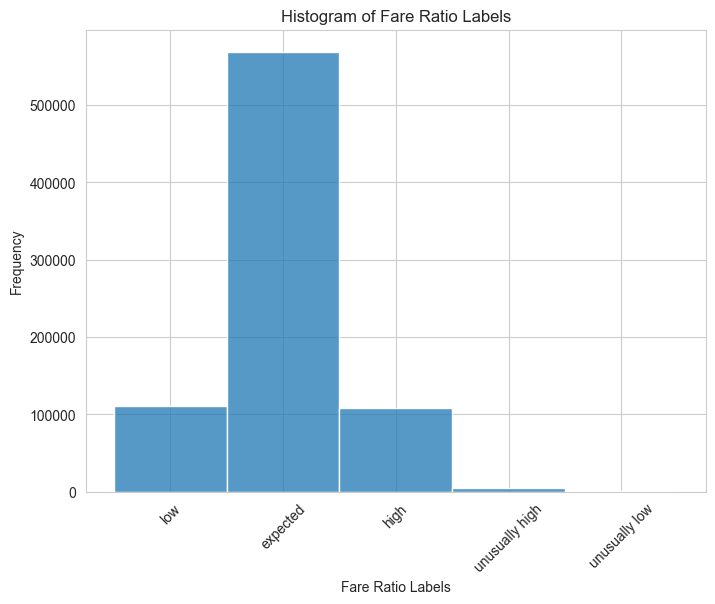

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.histplot(filtered_cab_data_train['fare_ratio_label'])

# Rotate x-labels by 45 degrees
plt.xticks(rotation=45)

plt.title('Histogram of Fare Ratio Labels')
plt.xlabel('Fare Ratio Labels')
plt.ylabel('Frequency')

plt.show()

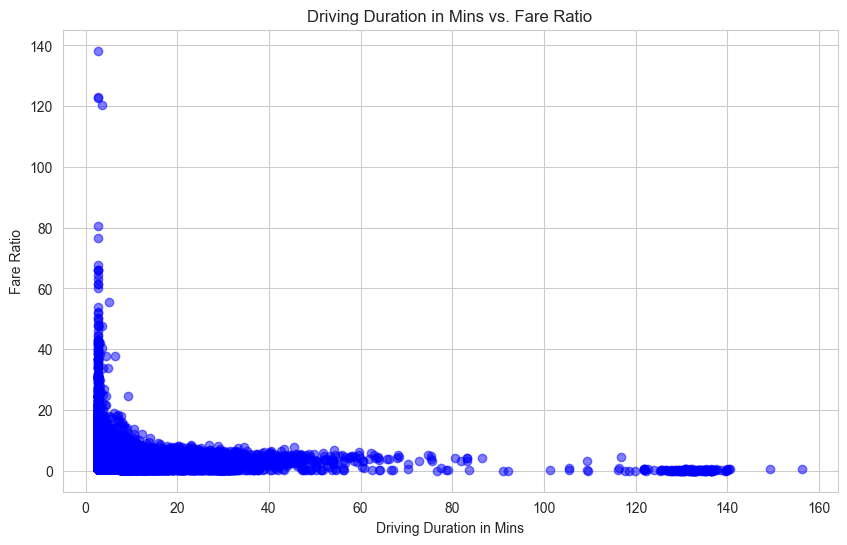

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plot of distance vs. fare_amount
plt.scatter(filtered_cab_data_train['driving_duration_in_mins'], filtered_cab_data_train['fare_ratio'], marker='o', color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Driving Duration in Mins')
plt.ylabel('Fare Ratio')
plt.title('Driving Duration in Mins vs. Fare Ratio')

# Show the plot
plt.grid(True)
plt.show()

<span style="color: yellow; font-weight: bold;"> The graph above shows the Fare Ratio v/s Distance relation. It is evident from the graph that for lesser distances the Fare Ratio is quite high whereas for increasing distance the ratio keeps on approaching 1. The relation almost resembles an inverse square relation.</span>

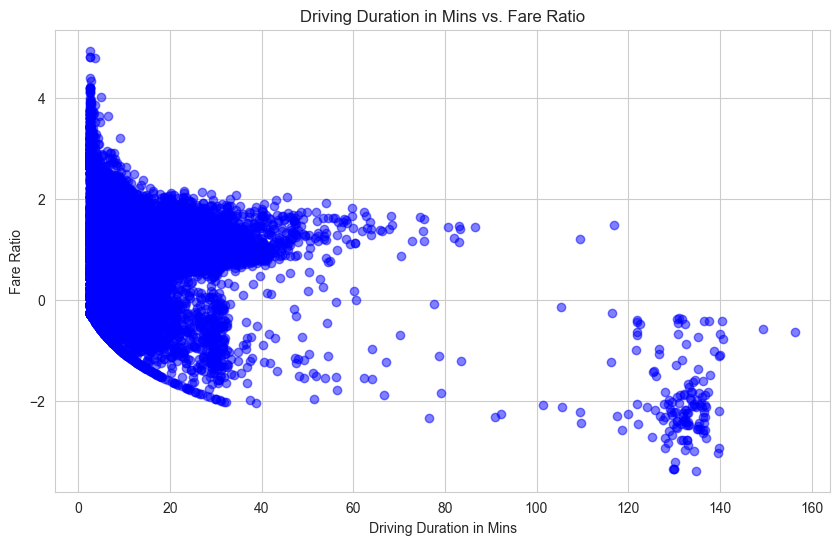

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plot of distance vs. fare_amount
plt.scatter(filtered_cab_data_train['driving_duration_in_mins'], np.log(filtered_cab_data_train['fare_ratio']), marker='o', color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Driving Duration in Mins')
plt.ylabel('Fare Ratio')
plt.title('Driving Duration in Mins vs. Fare Ratio')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import kendalltau

tau, p_value = kendalltau(filtered_cab_data_train['driving_duration_in_mins'], filtered_cab_data_train['fare_ratio'])
print("Kendall's correlation coefficient (tau):", tau)
print("P-value:", p_value)

Kendall's correlation coefficient (tau): 0.46478122037416136
P-value: 0.0


<span style="color: yellow; font-weight: bold;"> Being that said the graph above shows the Fare ratio v/s The Inverse of Driving Duration in mins relation.</span>

In [ ]:
fare_ratio = filtered_cab_data_train['fare_ratio']

# Specify the percentiles you are interested in
percentiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 98, 99, 99.5, 99.99]

# Calculate the percentiles
percentile_values = np.percentile(fare_ratio, percentiles)

# Count the number of data points above each percentile
data_points_above_percentiles = [np.sum(fare_ratio > value) for value in percentile_values]

# Print the results
for percentile, value, count in zip(percentiles, percentile_values, data_points_above_percentiles):
    print(f"Number of data points above {percentile}th percentile value {value}: {count}")

Number of data points above 0th percentile value 0.03413383174191703: 794871
Number of data points above 10th percentile value 1.1542503853847899: 715384
Number of data points above 20th percentile value 1.3084085960233043: 635897
Number of data points above 30th percentile value 1.4396864258620117: 556410
Number of data points above 40th percentile value 1.5644419319932068: 476923
Number of data points above 50th percentile value 1.6944409779775786: 397436
Number of data points above 60th percentile value 1.836680607277584: 317949
Number of data points above 70th percentile value 2.0084428826668033: 238462
Number of data points above 80th percentile value 2.2468088794647523: 158975
Number of data points above 90th percentile value 2.6683639115381315: 79488
Number of data points above 95th percentile value 3.0838089014214467: 39744
Number of data points above 98th percentile value 3.6337406667633165: 15898
Number of data points above 99th percentile value 4.178383216737367: 7949
Number

<span style="color: yellow; font-weight: bold;"> Now let's try to cluster the pickup co-ordinates based on their pickup longitudes and latitudes, the aim is to cluster these co-ordinates and figure out the number of pickups done in any given time interval bins say of 15 mins.</span>

In [ ]:
pickup_location_df= filtered_cab_data_train[['pickup_longitude', 'pickup_latitude']]

pickup_location_df.head()


pickup_longitude  pickup_latitude
0        -73.844311        40.721319
1        -74.016048        40.711303
2        -73.982738        40.761270
3        -73.987130        40.733143
4        -73.968095        40.768008

In [ ]:
from sklearn.cluster import KMeans

wcss = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state= 43)
    kmeans.fit(pickup_location_df)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

: 

<span style="color: yellow; font-weight: bold;"> So from the above elbow curve it is evident that 6 or more clusters will be optimal for this task</span>

C:\Users\sandi\AppData\Local\Temp\ipykernel_21396\3580046965.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\sandi\anaconda3\envs\work_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


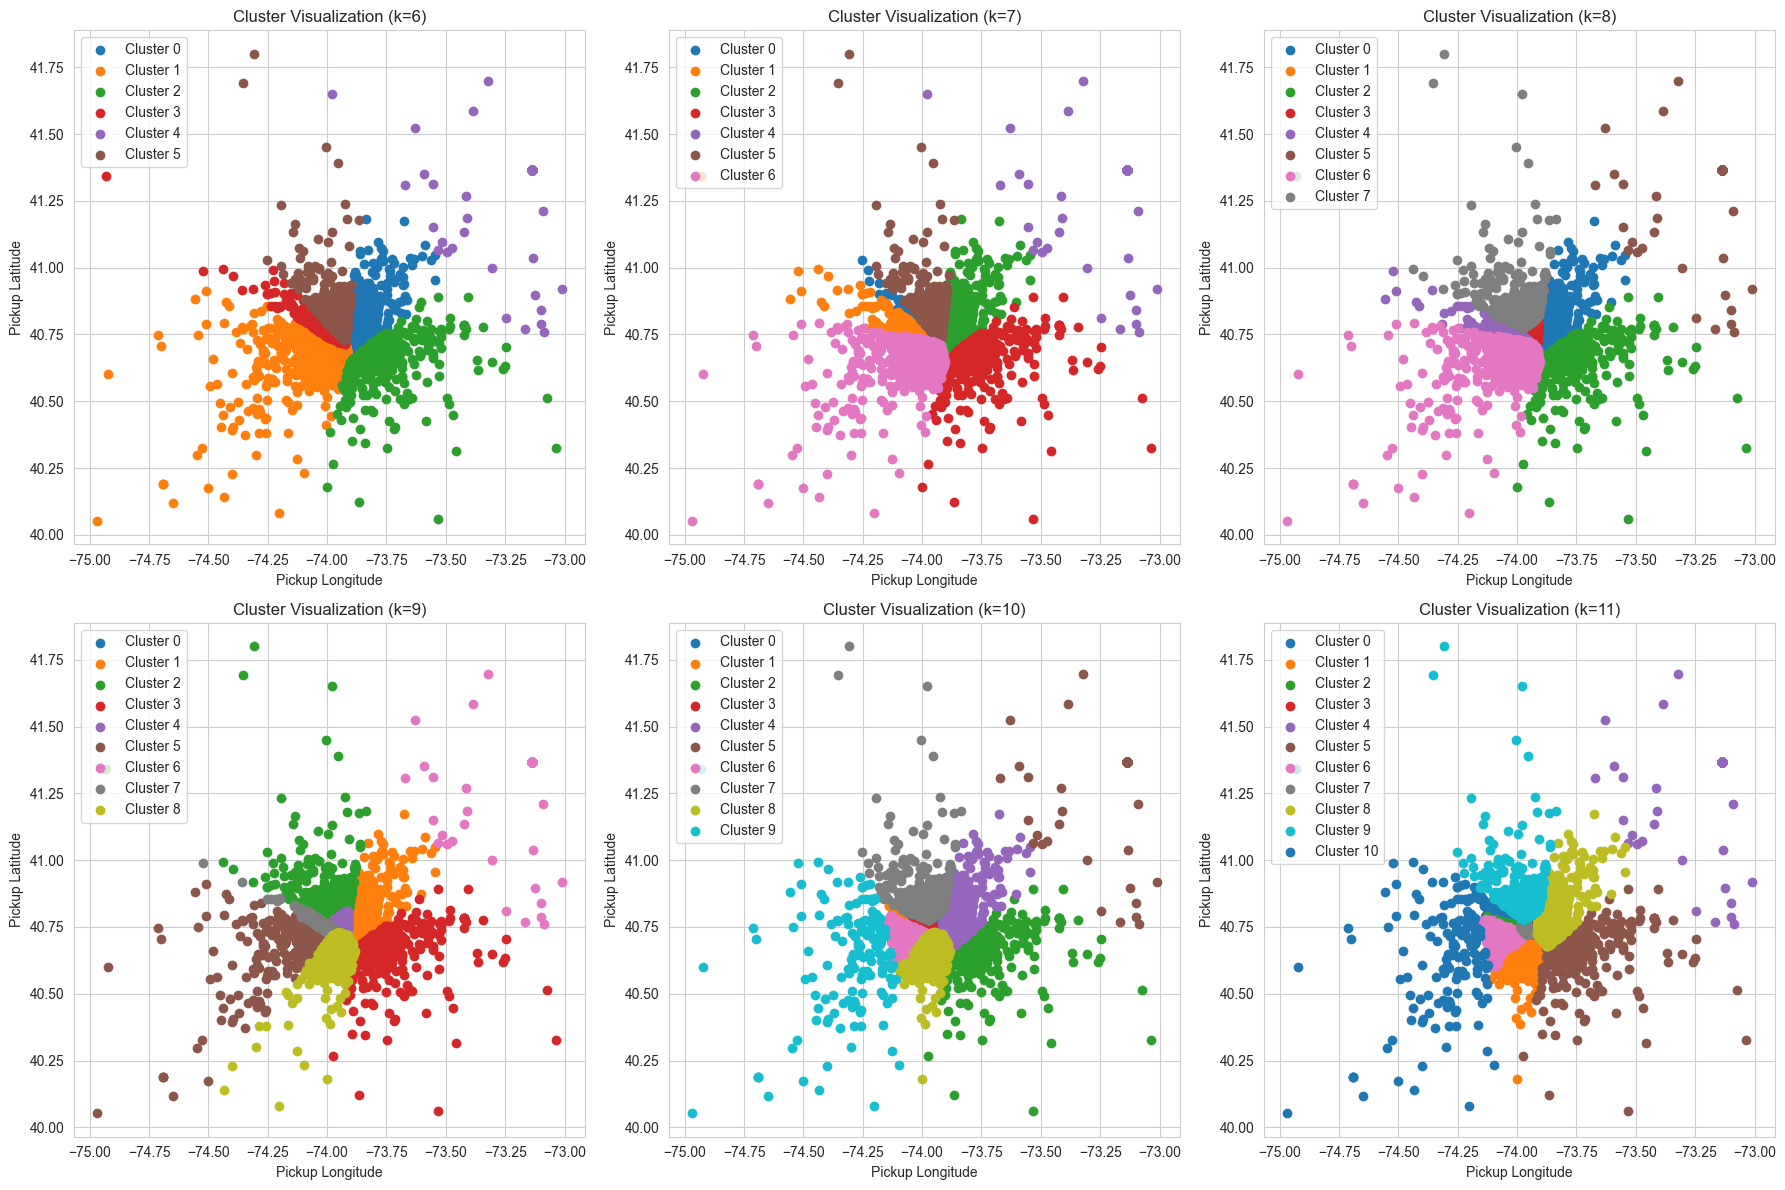

In [ ]:
from sklearn.cluster import KMeans

# Creating subplots for k=6 to 10 in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, optimal_k in enumerate(range(6, 12)):
    row = i // 3  # Row index for subplot
    col = i % 3   # Column index for subplot

    kmeans = KMeans(n_clusters=optimal_k, random_state= 43)
    clusters = kmeans.fit_predict(pickup_location_df)

    # Creating a new DataFrame with cluster labels
    clustered_data = pickup_location_df.copy()
    clustered_data['Cluster'] = clusters

    # Plotting clustered data in each subplot
    ax = axes[row, col]
    for cluster in range(optimal_k):
        cluster_data = clustered_data[clustered_data['Cluster'] == cluster]
        ax.scatter(cluster_data['pickup_longitude'], cluster_data['pickup_latitude'], label=f'Cluster {cluster}')

    ax.set_xlabel('Pickup Longitude')
    ax.set_ylabel('Pickup Latitude')
    ax.set_title(f'Cluster Visualization (k={optimal_k})')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(pickup_location_df)

# Assign cluster labels to the dataframe
pickup_location_df['Cluster'] = clusters

# Calculate mean and standard deviation for each cluster
cluster_stats = pickup_location_df.groupby('Cluster').agg({'pickup_longitude': ['mean', 'std'],
                                                           'pickup_latitude': ['mean', 'std']})

# Display cluster statistics
print(cluster_stats)

        pickup_longitude           pickup_latitude          
                    mean       std            mean       std
Cluster                                                     
0             -73.982479  0.009750       40.755649  0.008903
1             -73.784285  0.026289       40.647007  0.019874
2             -73.996213  0.014866       40.725656  0.015285
3             -73.873408  0.019467       40.768393  0.020849
4             -73.182241  0.137522       41.322917  0.147735
5             -73.960820  0.011813       40.779930  0.014742


C:\Users\sandi\AppData\Local\Temp\ipykernel_8484\2032473618.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pickup_location_df['Cluster'] = clusters


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(pickup_location_df[['pickup_longitude', 'pickup_latitude']])

# Assign cluster labels to the dataframe
pickup_location_df.loc[:, 'Cluster'] = clusters

# Initialize a dictionary to store cluster coordinates
cluster_coordinates = {}

# Iterate through each cluster
for cluster_num in range(8):  # For 8 clusters
    # Filter dataframe based on cluster
    cluster_data = pickup_location_df[pickup_location_df['Cluster'] == cluster_num].copy()
    
    # Extract pickup_longitudes and pickup_latitudes
    longitudes = cluster_data['pickup_longitude'].tolist()
    latitudes = cluster_data['pickup_latitude'].tolist()
    
    # Store the coordinates in the dictionary
    cluster_coordinates[f'cluster_{cluster_num}'] = {'pickup_longitudes': longitudes, 'pickup_latitudes': latitudes}

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import xgboost as xgb
import warnings
import subprocess
pd.set_option('display.max_columns', 500)
warnings.simplefilter(action='ignore', category=FutureWarning)

file_path_windows = r"C:\Users\sandi\Desktop\ML Working Folder\New York City Taxi Fare Prediction\filtered_cab_data_train.csv"
file_path_wsl = '/mnt/c/Users/sandi/Desktop/ML Working Folder/New York City Taxi Fare Prediction/filtered_cab_data_train.csv'

try:
    # Try loading the file using the Windows path
    loaded_data = pd.read_csv(file_path_windows)
    print("File loaded successfully!")

except FileNotFoundError:
    print("File not found using Windows path. Trying WSL path...")

    try:
        # Try loading the file using the WSL path
        loaded_data = pd.read_csv(file_path_wsl)
        print("File loaded successfully using WSL path!")
        import cudf
        import cupy as cp
        import cuml

    except FileNotFoundError:
        print("File not found using WSL path. Executing the provided code...")

        # Rest of the provided code for assigning cluster numbers
        for index, row in filtered_cab_data_train.iterrows():
            longitude = row['pickup_longitude']
            latitude = row['pickup_latitude']
            
            # Check if the longitude and latitude values fall within any cluster
            for cluster_name, values in cluster_coordinates.items():
                if (longitude in values['pickup_longitudes']) and (latitude in values['pickup_latitudes']):
                    # Assign the cluster number to the 'cluster_number' column in filtered_cab_data_train
                    filtered_cab_data_train.at[index, 'cluster_number'] = int(cluster_name.split('_')[1])
                    break  # Break the loop once assigned
        
        # Saving the modified DataFrame as a CSV file (using the WSL path)
        filtered_cab_data_train.to_csv(file_path_wsl, index=False)
        print(f"Modified DataFrame saved at: {file_path_wsl}")

File loaded successfully!


In [ ]:
filtered_cab_data_train.isnull().mean()

key                         0.0
fare_amount                 0.0
pickup_datetime             0.0
pickup_longitude            0.0
pickup_latitude             0.0
dropoff_longitude           0.0
dropoff_latitude            0.0
passenger_count             0.0
hour                        0.0
minute                      0.0
year                        0.0
month                       0.0
day                         0.0
day_of_week                 0.0
is_weekend                  0.0
minute_bin                  0.0
haversine_distance_in_km    0.0
driving_duration_in_mins    0.0
driving_distance_in_km      0.0
is_holiday                  0.0
expected_fare               0.0
fare_ratio                  0.0
fare_ratio_label            0.0
dtype: float64

In [ ]:
# Set the maximum displayed columns to 500
pd.set_option('display.max_columns', 500)

filtered_cab_data_train= loaded_data

# Display the first few rows of filtered_cab_data_train
filtered_cab_data_train.head()

key  fare_amount            pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
0                1    17      26  2009      6   15            0           0   
1                1    16      52  2010      1    5            1           0   
2                2     0      35  2011      8   18            3           0   
3                1     4      30  2012      4   21            5           1   
4                1     7      51  2010      3    9            1           0   

   minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0           2                  1.030764                  4.016573   
1           4                  8.450134                 13.837513   
2           3                  1.389525                  4.491462   
3           3                  2.799270                  6.357526   
4           4                  1.999157                  5.298425   

   driving_distance_in_km  is_holiday  expected_fare  fare_ratio  \
0                1.185770           0       3.977392    1.131395   
1                9.311980           0       9.181858    1.840586   
2                1.578711           0       4.229052    1.347820   
3                3.122761           0       5.217946    1.475676   
4                2.246422           0       4.656691    1.138147   

  fare_ratio_label  cluster_number  
0              low             1.0  
1         expected             4.0  
2         expected             0.0  
3         expected             0.0  
4              low             0.0

In [ ]:
filtered_cab_data_train['cluster_number'].unique()

array([1., 4., 0., 2., 3., 5.])

In [ ]:
filtered_cab_data_train['cluster_number'] = filtered_cab_data_train['cluster_number'] + 1

filtered_cab_data_train.head()

key  fare_amount            pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
0                1    17      26  2009      6   15            0           0   
1                1    16      52  2010      1    5            1           0   
2                2     0      35  2011      8   18            3           0   
3                1     4      30  2012      4   21            5           1   
4                1     7      51  2010      3    9            1           0   

   minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0           2                  1.030764                  4.016573   
1           4                  8.450134                 13.837513   
2           3                  1.389525                  4.491462   
3           3                  2.799270                  6.357526   
4           4                  1.999157                  5.298425   

   driving_distance_in_km  is_holiday  expected_fare  fare_ratio  \
0                1.185770           0       3.977392    1.131395   
1                9.311980           0       9.181858    1.840586   
2                1.578711           0       4.229052    1.347820   
3                3.122761           0       5.217946    1.475676   
4                2.246422           0       4.656691    1.138147   

  fare_ratio_label  cluster_number  
0              low             2.0  
1         expected             5.0  
2         expected             1.0  
3         expected             1.0  
4              low             1.0

In [ ]:
filtered_cab_data_train['cluster_number'].unique()

array([2., 5., 1., 3., 4., 6.])

In [ ]:
filtered_cab_data_train.drop(columns=['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace= True)

filtered_cab_data_train.head()

fare_amount  passenger_count  hour  minute  year  month  day  day_of_week  \
0          4.5                1    17      26  2009      6   15            0   
1         16.9                1    16      52  2010      1    5            1   
2          5.7                2     0      35  2011      8   18            3   
3          7.7                1     4      30  2012      4   21            5   
4          5.3                1     7      51  2010      3    9            1   

   is_weekend  minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0           0           2                  1.030764                  4.016573   
1           0           4                  8.450134                 13.837513   
2           0           3                  1.389525                  4.491462   
3           1           3                  2.799270                  6.357526   
4           0           4                  1.999157                  5.298425   

   driving_distance_in_km  is_holiday  expected_fare  fare_ratio  \
0                1.185770           0       3.977392    1.131395   
1                9.311980           0       9.181858    1.840586   
2                1.578711           0       4.229052    1.347820   
3                3.122761           0       5.217946    1.475676   
4                2.246422           0       4.656691    1.138147   

  fare_ratio_label  cluster_number  
0              low             2.0  
1         expected             5.0  
2         expected             1.0  
3         expected             1.0  
4              low             1.0

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import xgboost as xgb
import warnings
import subprocess
import dateutil
pd.set_option('display.max_columns', 500)
warnings.simplefilter(action='ignore', category=FutureWarning)

# File paths for Windows and WSL
file_path_windows = r'C:\Users\sandi\Desktop\ML Working Folder\New York City Taxi Fare Prediction\aggregated_data.csv'
file_path_wsl = '/mnt/c/Users/sandi/Desktop/ML Working Folder/New York City Taxi Fare Prediction/aggregated_data.csv'

try:
    # Try loading from Windows path
     aggregated_data = pd.read_csv(file_path_windows)  # Replace cudf with pd for pandas DataFrame
     print("Data loaded from windows path succesfully.")
except FileNotFoundError:
    try:
        # Try loading from WSL path if Windows path not found
         aggregated_data = cudf.read_csv(file_path_wsl)  # Replace cudf with pd for pandas DataFrame
         import cudf
         import cupy as cp
         import cuml
         print("Data loaded from WSL path succesfully and the related libraries sucessfully loaded...")
    except FileNotFoundError:
        # If file not found in both paths, execute the provided code
        
        def perform_chunked_aggregation(filtered_cab_data, chunk_size=10):
            # Initialize an empty list to store the aggregated results
            aggregated_chunks = []

            # Determine the unique chunks based on the specified columns
            unique_chunks = filtered_cab_data[['cluster_number', 'year', 'month', 'day', 'hour', 'minute_bin']].drop_duplicates()

            # Iterate through the unique chunks
            for i in range(0, len(unique_chunks), chunk_size):
                chunk = unique_chunks.iloc[i:i+chunk_size]  # Get a chunk of data
                
                # Merge the chunk with the original data to filter rows
                merged_data = filtered_cab_data.merge(chunk, on=['cluster_number', 'year', 'month', 'day', 'hour', 'minute_bin'], how='inner')
                
                # Perform grouping and aggregation within the chunk
                chunk_grouped_data = merged_data.groupby(['cluster_number', 'year', 'month', 'day', 'hour', 'minute_bin']).size().reset_index(name='rides_per_minute_bin')
                
                # Append chunk_grouped_data to the list
                aggregated_chunks.append(chunk_grouped_data)

            # Concatenate the aggregated chunks together
            aggregated_data = pd.concat(aggregated_chunks)

            # Perform a final aggregation on the concatenated data to get the overall result
            final_aggregation = aggregated_data.groupby(['cluster_number', 'year', 'month', 'day', 'hour', 'minute_bin'])['rides_per_minute_bin'].sum().reset_index()

            return final_aggregation.to_pandas()  # Convert back to Pandas DataFrame if necessary

        # Now perform the chunked aggregation
        aggregated_data = perform_chunked_aggregation(filtered_cab_data_train)
        aggregated_data.head()

Data loaded from windows path succesfully.


In [ ]:
aggregated_data.shape

(301436, 7)

In [ ]:
filtered_cab_data_train = pd.merge(filtered_cab_data_train, aggregated_data, on=['cluster_number', 'year', 'month', 'day', 'hour', 'minute_bin'], how='inner')

filtered_cab_data_train.head()

fare_amount  passenger_count  hour  minute  year  month  day  day_of_week  \
0          4.5                1    17      26  2009      6   15            0   
1         16.9                1    16      52  2010      1    5            1   
2         15.7                1    16      51  2010      1    5            1   
3          5.7                2     0      35  2011      8   18            3   
4          4.9                1     0      40  2011      8   18            3   

   is_weekend  minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0           0           2                  1.030764                  4.016573   
1           0           4                  8.450134                 13.837513   
2           0           4                  6.253716                 10.930138   
3           0           3                  1.389525                  4.491462   
4           0           3                  1.842285                  5.090775   

   driving_distance_in_km  is_holiday  expected_fare  fare_ratio  \
0                1.185770           0       3.977392    1.131395   
1                9.311980           0       9.181858    1.840586   
2                6.906310           0       7.641136    2.054668   
3                1.578711           0       4.229052    1.347820   
4                2.074604           0       4.546650    1.077717   

  fare_ratio_label  cluster_number  rides_per_minute_bin  
0              low             2.0                     1  
1         expected             5.0                     2  
2         expected             5.0                     2  
3         expected             1.0                     2  
4              low             1.0                     2

In [ ]:
filtered_cab_data_train.isnull().mean()

fare_amount                 0.0
passenger_count             0.0
hour                        0.0
minute                      0.0
year                        0.0
month                       0.0
day                         0.0
day_of_week                 0.0
is_weekend                  0.0
minute_bin                  0.0
haversine_distance_in_km    0.0
driving_duration_in_mins    0.0
driving_distance_in_km      0.0
is_holiday                  0.0
expected_fare               0.0
fare_ratio                  0.0
fare_ratio_label            0.0
cluster_number              0.0
rides_per_minute_bin        0.0
dtype: float64

In [ ]:
min_value=filtered_cab_data_train['rides_per_minute_bin'].min()
max_value=filtered_cab_data_train['rides_per_minute_bin'].max()

print(f"Minimum number of rides per minute bin in any given cluster is {min_value}")
print(f"Maximum number of rides per minute bin in any given cluster is {max_value}")

Minimum number of rides per minute bin in any given cluster is 1
Maximum number of rides per minute bin in any given cluster is 18


In [ ]:
filtered_cab_data_train.describe()

fare_amount  passenger_count           hour         minute  \
count  794872.000000    794872.000000  794872.000000  794872.000000   
mean       11.194791         1.268366      13.490879      29.571513   
std         9.503672         0.544038       6.506217      17.330155   
min         2.500000         1.000000       0.000000       0.000000   
25%         6.000000         1.000000       9.000000      15.000000   
50%         8.500000         1.000000      14.000000      30.000000   
75%        12.500000         1.000000      19.000000      45.000000   
max       450.000000         3.000000      23.000000      59.000000   

                year          month            day    day_of_week  \
count  794872.000000  794872.000000  794872.000000  794872.000000   
mean     2011.495026       6.478844      15.691724       3.021988   
std         1.698139       3.446052       8.682837       1.948571   
min      2009.000000       1.000000       1.000000       0.000000   
25%      2010.000000       4.000000       8.000000       1.000000   
50%      2012.000000       6.000000      16.000000       3.000000   
75%      2013.000000      10.000000      23.000000       5.000000   
max      2014.000000      12.000000      31.000000       6.000000   

          is_weekend     minute_bin  haversine_distance_in_km  \
count  794872.000000  794872.000000             794872.000000   
mean        0.278621       2.505023                  3.358504   
std         0.448321       1.119504                  3.785020   
min         0.000000       1.000000                  0.000084   
25%         0.000000       2.000000                  1.281354   
50%         0.000000       3.000000                  2.178613   
75%         1.000000       4.000000                  3.944569   
max         1.000000       4.000000                116.135048   

       driving_duration_in_mins  driving_distance_in_km     is_holiday  \
count             794872.000000           794872.000000  794872.000000   
mean                   7.097778                3.735273       0.022937   
std                    5.010190                4.145617       0.149703   
min                    2.652273                0.056898       0.000000   
25%                    4.348277                1.460234       0.000000   
50%                    5.535969                2.442974       0.000000   
75%                    7.873545                4.377172       0.000000   
max                  156.378875              127.255988       1.000000   

       expected_fare     fare_ratio  cluster_number  rides_per_minute_bin  
count  794872.000000  794872.000000   794872.000000         794872.000000  
mean        5.610232       1.856098        1.301150              4.272975  
std         2.655078       1.039496        0.766243              2.583508  
min         3.254401       0.034134        1.000000              1.000000  
25%         4.153173       1.375095        1.000000              2.000000  
50%         4.782574       1.694441        1.000000              4.000000  
75%         6.021339       2.115438        1.000000              6.000000  
max        84.719602     138.233657        6.000000             18.000000

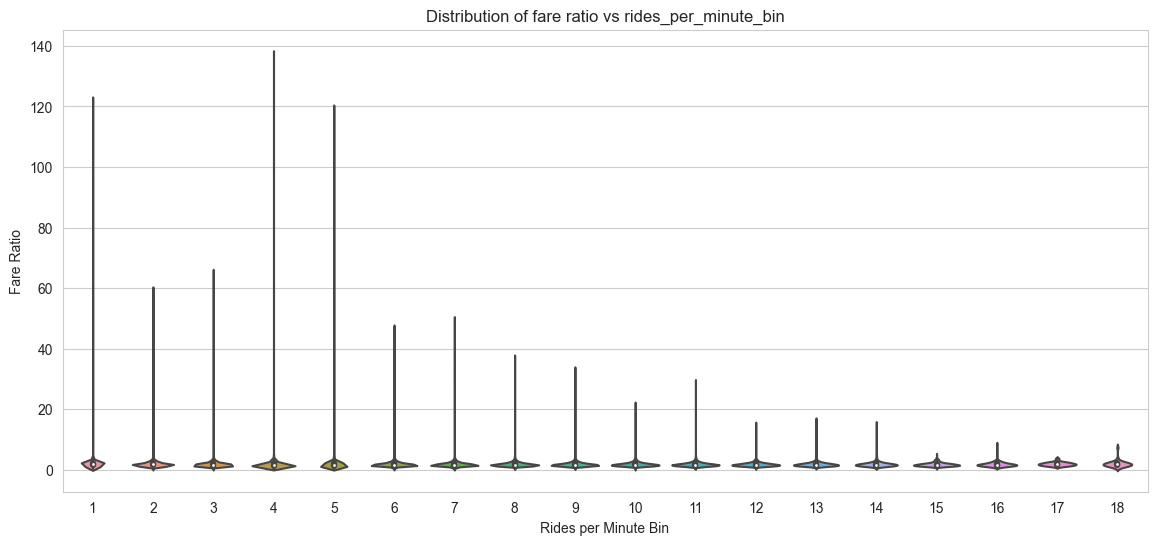

In [ ]:
# Set up the violin plot
plt.figure(figsize=(14, 6))
sns.violinplot(x='rides_per_minute_bin', y='fare_ratio', data=filtered_cab_data_train)
plt.title('Distribution of fare ratio vs rides_per_minute_bin')
plt.xlabel('Rides per Minute Bin')
plt.ylabel('Fare Ratio')
plt.show()

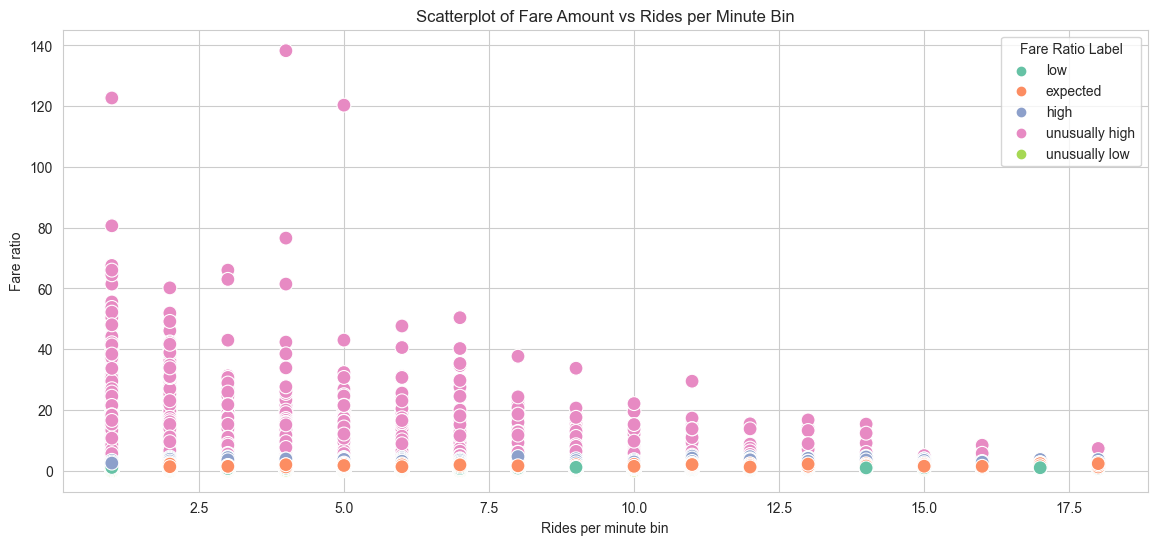

In [ ]:
plt.figure(figsize=(14, 6))
sns.set_style('whitegrid')
sns.scatterplot(x='rides_per_minute_bin', y='fare_ratio', data=filtered_cab_data_train, hue='fare_ratio_label', palette='Set2', s=100)
plt.title('Scatterplot of Fare Amount vs Rides per Minute Bin')
plt.xlabel('Rides per minute bin')
plt.ylabel('Fare ratio')
plt.legend(title='Fare Ratio Label')
plt.show()

<span style="color: yellow; font-weight: bold;"> From above it is evident that for low number of pickups per zone for that particular time slot the fare ratio  can have a wide range of values which may vary from very low to extremely high, whereas when the number of pickups per cluster zone for that particular time slot is high the fare_ratio range is mostly narrow.</span>

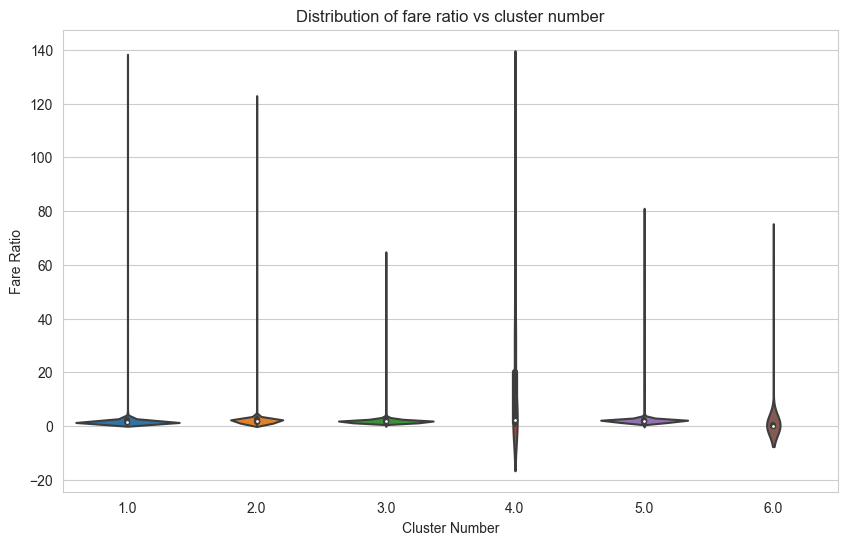

In [ ]:
# Set up the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='cluster_number', y='fare_ratio', data=filtered_cab_data_train)
plt.title('Distribution of fare ratio vs cluster number')
plt.xlabel('Cluster Number')
plt.ylabel('Fare Ratio')
plt.show()

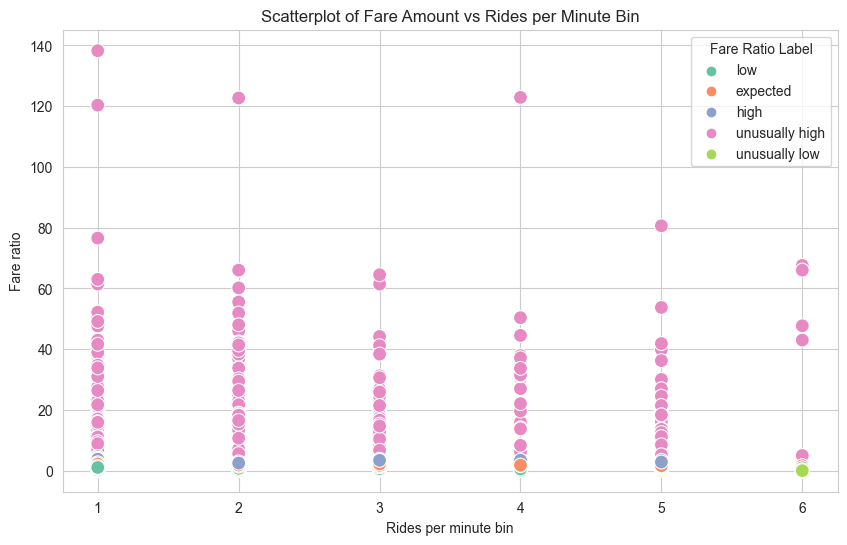

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cluster_number', y='fare_ratio', data=filtered_cab_data_train, hue='fare_ratio_label', palette='Set2', s=100)
plt.title('Scatterplot of Fare Amount vs Rides per Minute Bin')
plt.xlabel('Rides per minute bin')
plt.ylabel('Fare ratio')
plt.legend(title='Fare Ratio Label')
plt.show()

In [ ]:
filtered_cab_data_train['fare_ratio_label'].unique()

array(['low', 'expected', 'high', 'unusually high', 'unusually low'],
      dtype=object)

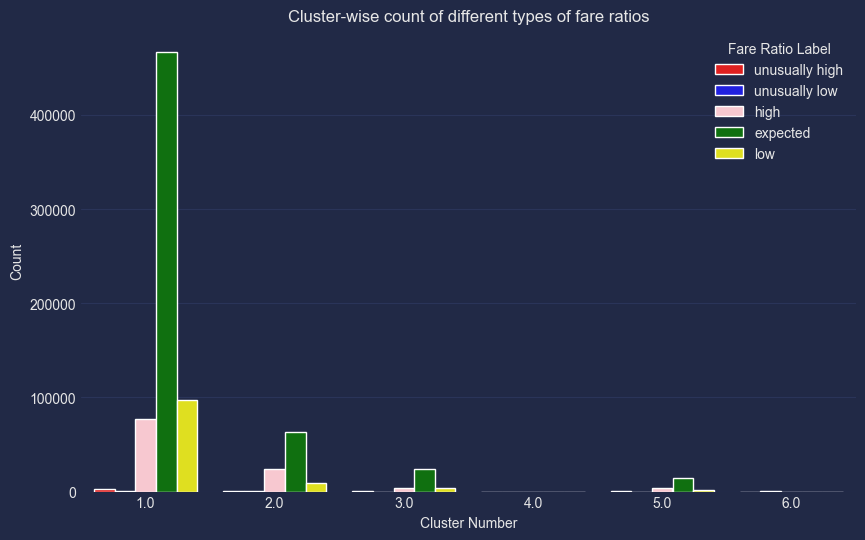

In [ ]:
import mplcyberpunk

with plt.style.context('cyberpunk'):
    unusually_high_data = filtered_cab_data_train[filtered_cab_data_train['fare_ratio_label'] == 'unusually high']
    unusually_low_data = filtered_cab_data_train[filtered_cab_data_train['fare_ratio_label'] == 'unusually low']
    high_data = filtered_cab_data_train[filtered_cab_data_train['fare_ratio_label'] == 'high']
    expected_data = filtered_cab_data_train[filtered_cab_data_train['fare_ratio_label'] == 'expected']
    low_data = filtered_cab_data_train[filtered_cab_data_train['fare_ratio_label'] == 'low']

    # Concatenate the filtered data for plotting
    combined_plot = pd.concat([unusually_high_data, unusually_low_data, high_data, expected_data, low_data])

    # Create a countplot with hue
    plt.figure(figsize=(10, 6))
    sns.countplot(x='cluster_number', hue='fare_ratio_label', data=combined_plot,
                  palette={'unusually high': 'red', 'high': 'pink', 'expected': 'green', 'low': 'yellow', 'unusually low': 'blue'})
    plt.title("Cluster-wise count of different types of fare ratios")
    plt.xlabel('Cluster Number')
    plt.ylabel('Count')
    plt.legend(title='Fare Ratio Label')
    plt.show()

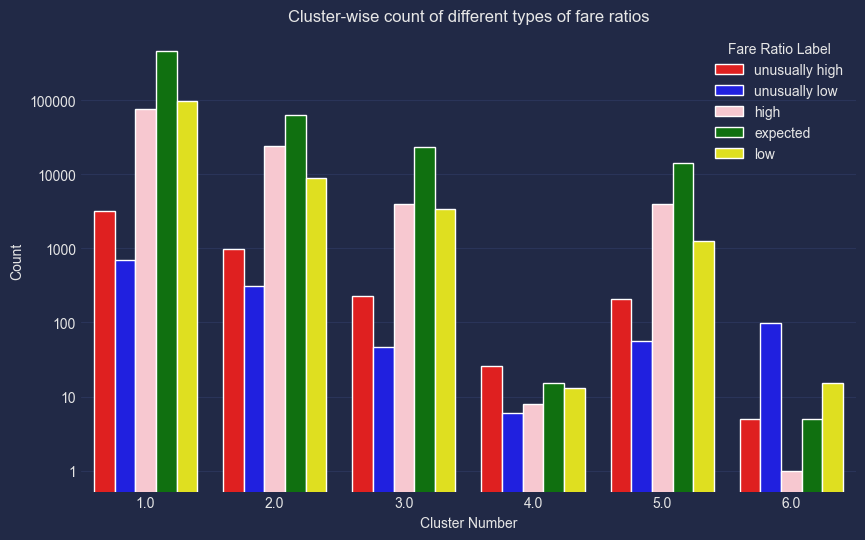

In [ ]:
with plt.style.context('cyberpunk'):
    unusually_high_data = filtered_cab_data_train[filtered_cab_data_train['fare_ratio_label'] == 'unusually high']
    unusually_low_data = filtered_cab_data_train[filtered_cab_data_train['fare_ratio_label'] == 'unusually low']
    high_data = filtered_cab_data_train[filtered_cab_data_train['fare_ratio_label'] == 'high']
    expected_data = filtered_cab_data_train[filtered_cab_data_train['fare_ratio_label'] == 'expected']
    low_data = filtered_cab_data_train[filtered_cab_data_train['fare_ratio_label'] == 'low']

    # Concatenate the filtered data for plotting
    combined_plot = pd.concat([unusually_high_data, unusually_low_data, high_data, expected_data, low_data])

    # Create a countplot with hue
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='cluster_number', hue='fare_ratio_label', data=combined_plot,
                       palette={'unusually high': 'red', 'high': 'pink', 'expected': 'green', 'low': 'yellow', 'unusually low': 'blue'})
    plt.title("Cluster-wise count of different types of fare ratios")
    plt.xlabel('Cluster Number')
    plt.ylabel('Count')
    plt.legend(title='Fare Ratio Label')

    # Set y-axis scale to logarithmic
    plt.yscale('log')

    # Adjust y-axis ticks if needed
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


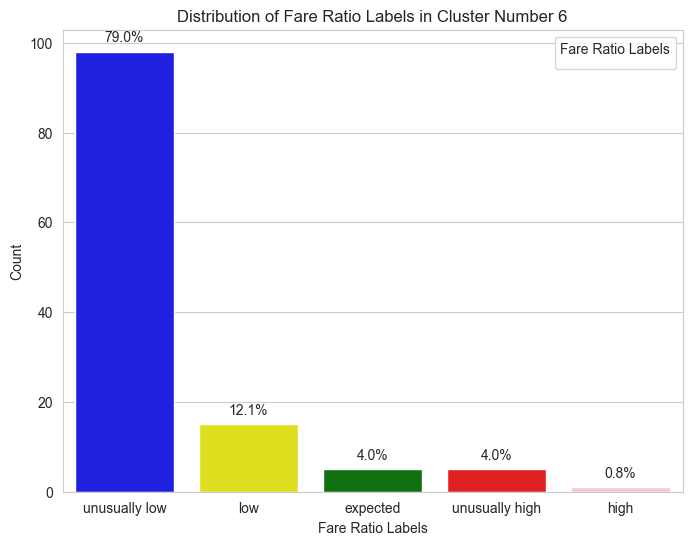

In [ ]:
cluster_number_6_data = filtered_cab_data_train[filtered_cab_data_train['cluster_number'] == 6]

plt.figure(figsize=(8, 6))

ax = sns.countplot(x='fare_ratio_label', data=cluster_number_6_data, palette={'unusually high': 'red', 'high': 'pink', 'expected': 'green', 'low': 'yellow', 'unusually low': 'blue'})

plt.title('Distribution of Fare Ratio Labels in Cluster Number 6')  # Updated title
plt.xlabel('Fare Ratio Labels')
plt.ylabel('Count')

# Annotate bars with percentages
total = len(cluster_number_6_data)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total:.1%}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

# Set legend outside the plot
plt.legend(title='Fare Ratio Labels', loc='upper right')

sns.set_style('whitegrid')
plt.show()


<span style="color: yellow; font-weight: bold;"> Based on the above boxplots we can see that most clusters has very few numbers of unlikely fare_ratio except cluster 6.</span>

In [ ]:
filtered_cab_data_train.head()

fare_amount  passenger_count  hour  minute  year  month  day  day_of_week  \
0          4.5                1    17      26  2009      6   15            0   
1         16.9                1    16      52  2010      1    5            1   
2         15.7                1    16      51  2010      1    5            1   
3          5.7                2     0      35  2011      8   18            3   
4          4.9                1     0      40  2011      8   18            3   

   is_weekend  minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0           0           2                  1.030764                  4.016573   
1           0           4                  8.450134                 13.837513   
2           0           4                  6.253716                 10.930138   
3           0           3                  1.389525                  4.491462   
4           0           3                  1.842285                  5.090775   

   driving_distance_in_km  is_holiday  expected_fare  fare_ratio  \
0                1.185770           0       3.977392    1.131395   
1                9.311980           0       9.181858    1.840586   
2                6.906310           0       7.641136    2.054668   
3                1.578711           0       4.229052    1.347820   
4                2.074604           0       4.546650    1.077717   

  fare_ratio_label  cluster_number  rides_per_minute_bin  
0              low             2.0                     1  
1         expected             5.0                     2  
2         expected             5.0                     2  
3         expected             1.0                     2  
4              low             1.0                     2

In [ ]:
filtered_cab_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794872 entries, 0 to 794871
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   fare_amount               794872 non-null  float64
 1   passenger_count           794872 non-null  int64  
 2   hour                      794872 non-null  int64  
 3   minute                    794872 non-null  int64  
 4   year                      794872 non-null  int64  
 5   month                     794872 non-null  int64  
 6   day                       794872 non-null  int64  
 7   day_of_week               794872 non-null  int64  
 8   is_weekend                794872 non-null  int64  
 9   minute_bin                794872 non-null  int64  
 10  haversine_distance_in_km  794872 non-null  float64
 11  driving_duration_in_mins  794872 non-null  float64
 12  driving_distance_in_km    794872 non-null  float64
 13  is_holiday                794872 non-null  i

In [ ]:
# List of columns to be converted to object type
columns_to_convert = ['hour', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'minute_bin', 'cluster_number']

# Convert specified columns to object type
filtered_cab_data_train[columns_to_convert] = filtered_cab_data_train[columns_to_convert].astype('object')

filtered_cab_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794872 entries, 0 to 794871
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   fare_amount               794872 non-null  float64
 1   passenger_count           794872 non-null  int64  
 2   hour                      794872 non-null  object 
 3   minute                    794872 non-null  int64  
 4   year                      794872 non-null  object 
 5   month                     794872 non-null  object 
 6   day                       794872 non-null  object 
 7   day_of_week               794872 non-null  object 
 8   is_weekend                794872 non-null  object 
 9   minute_bin                794872 non-null  object 
 10  haversine_distance_in_km  794872 non-null  float64
 11  driving_duration_in_mins  794872 non-null  float64
 12  driving_distance_in_km    794872 non-null  float64
 13  is_holiday                794872 non-null  i

In [ ]:
filtered_cab_data_train= filtered_cab_data_train.drop(columns=['minute'], axis=1)

filtered_cab_data_train.head()

fare_amount  passenger_count hour  year month day day_of_week is_weekend  \
0          4.5                1   17  2009     6  15           0          0   
1         16.9                1   16  2010     1   5           1          0   
2         15.7                1   16  2010     1   5           1          0   
3          5.7                2    0  2011     8  18           3          0   
4          4.9                1    0  2011     8  18           3          0   

  minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0          2                  1.030764                  4.016573   
1          4                  8.450134                 13.837513   
2          4                  6.253716                 10.930138   
3          3                  1.389525                  4.491462   
4          3                  1.842285                  5.090775   

   driving_distance_in_km  is_holiday  expected_fare  fare_ratio  \
0                1.185770           0       3.977392    1.131395   
1                9.311980           0       9.181858    1.840586   
2                6.906310           0       7.641136    2.054668   
3                1.578711           0       4.229052    1.347820   
4                2.074604           0       4.546650    1.077717   

  fare_ratio_label cluster_number  rides_per_minute_bin  
0              low            2.0                     1  
1         expected            5.0                     2  
2         expected            5.0                     2  
3         expected            1.0                     2  
4              low            1.0                     2

C:\Users\sandi\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


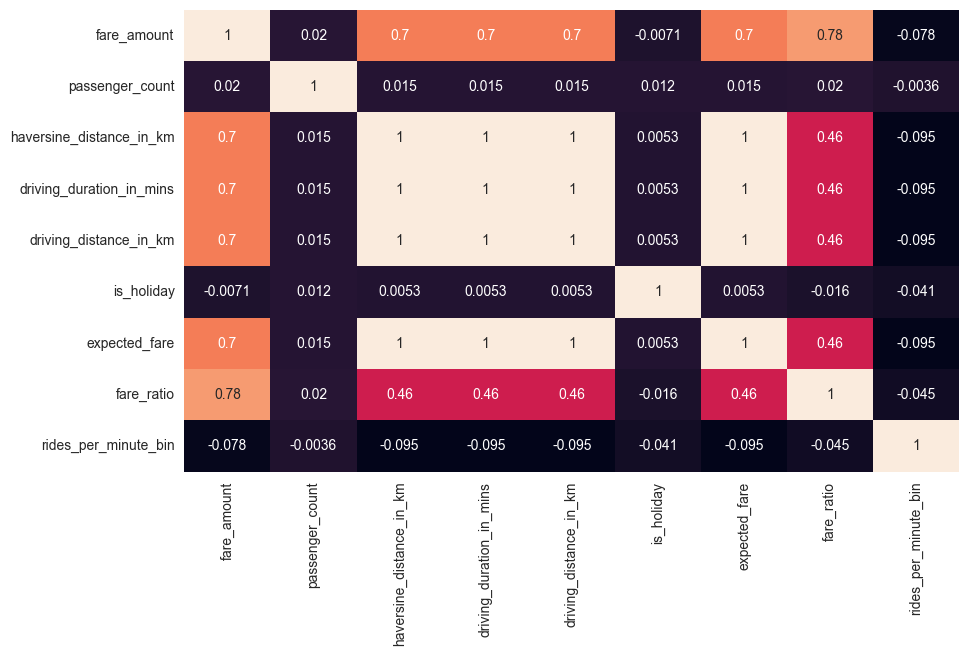

In [ ]:
plt.figure(figsize=(10, 6))

numerical_columns = filtered_cab_data_train.select_dtypes(include=['number'])

sns.heatmap(numerical_columns.corr(method='kendall'), cbar=False, annot= True )

plt.show()

<span style="color: yellow; font-weight: bold;"> Next what we will do is we will try to build a model which can predict these fare_ratio_labels based on available features.</span>

In [ ]:
filtered_cab_data_train.head(1)

fare_amount  passenger_count hour  year month day day_of_week is_weekend  \
0          4.5                1   17  2009     6  15           0          0   

  minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0          2                  1.030764                  4.016573   

   driving_distance_in_km  is_holiday  expected_fare  fare_ratio  \
0                 1.18577           0       3.977392    1.131395   

  fare_ratio_label cluster_number  rides_per_minute_bin  
0              low            2.0                     1

<span style="color: yellow; font-weight: bold;"> Let us ananlyze the variation of fare_ratio and fare_amount across various categorical and numerical variables.</span>

<Figure size 800x600 with 0 Axes>

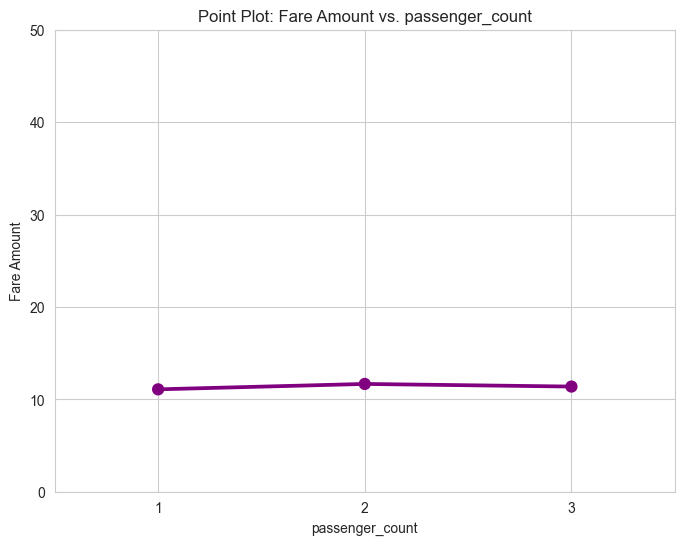

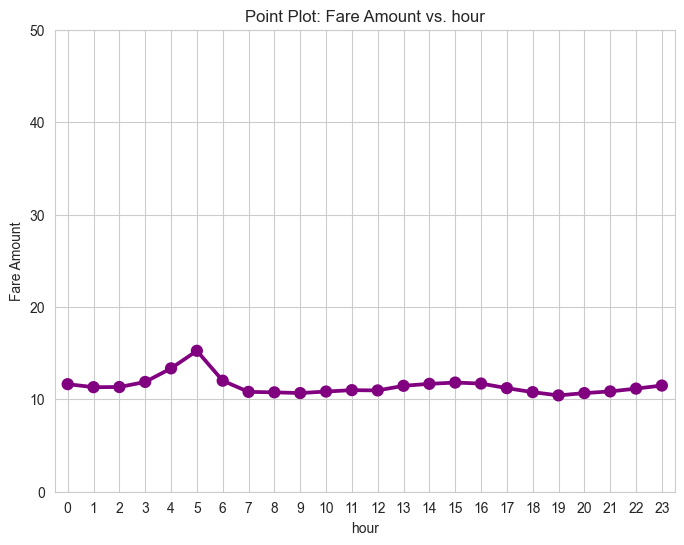

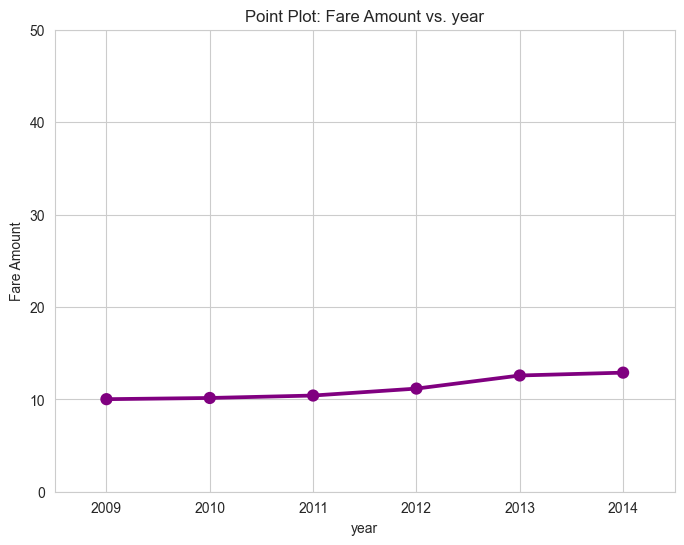

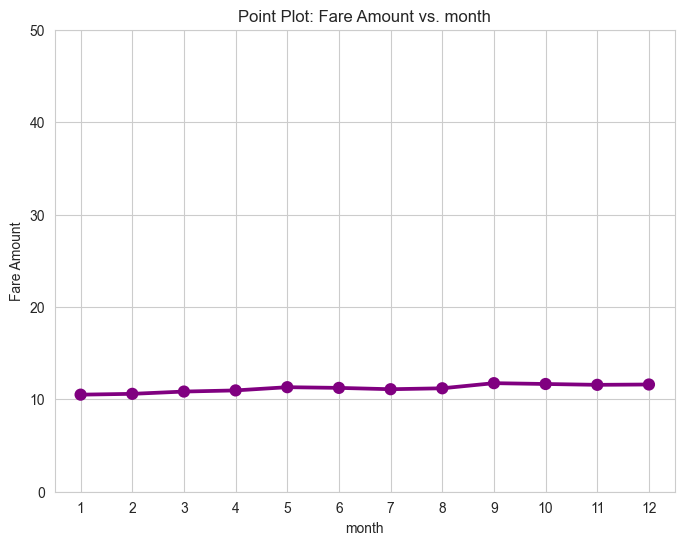

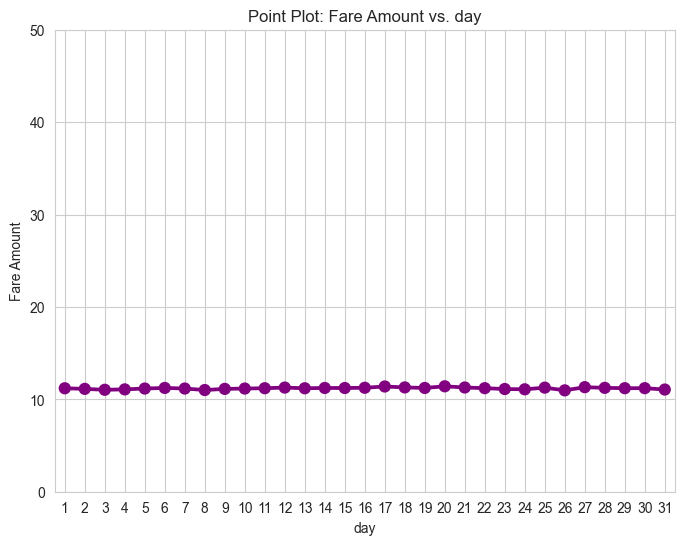

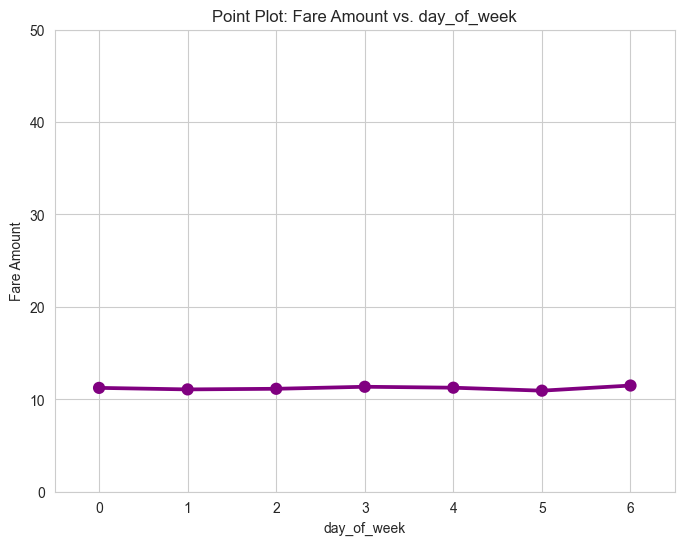

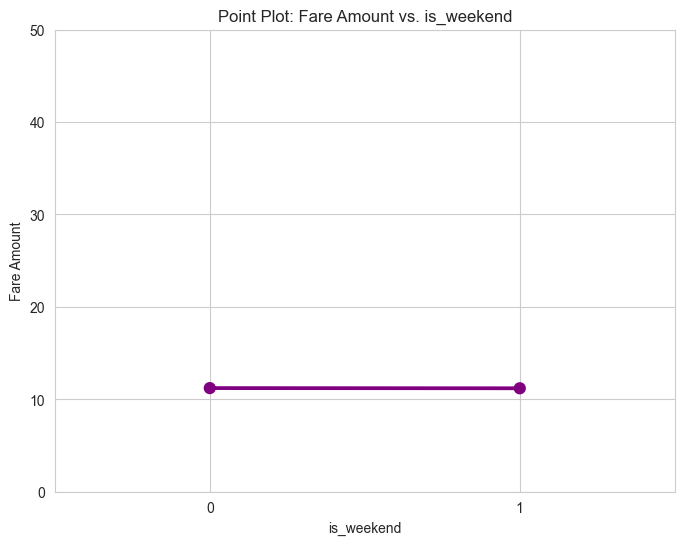

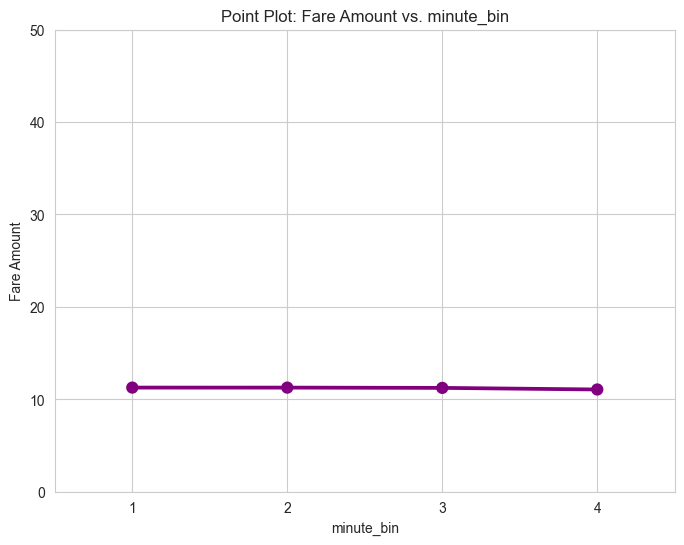

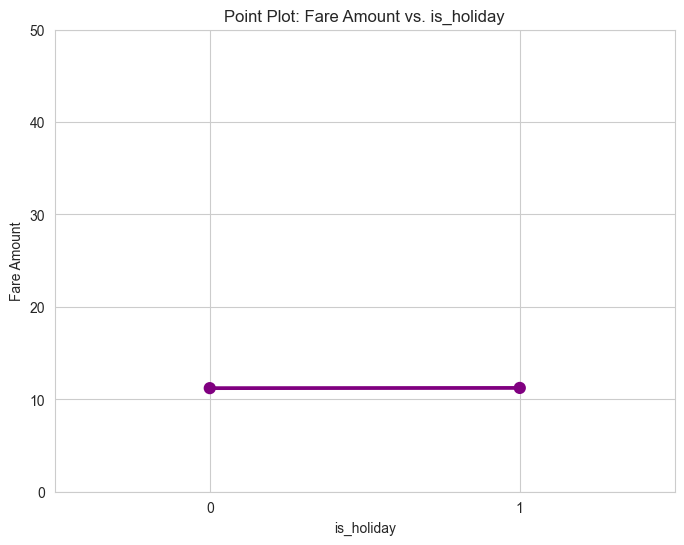

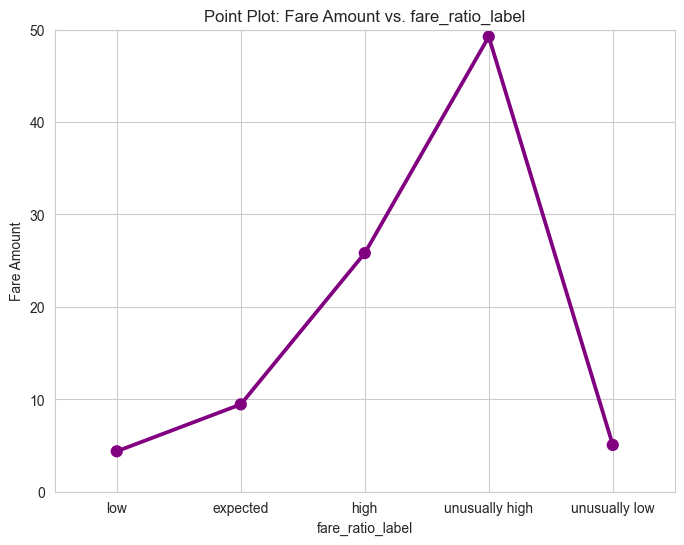

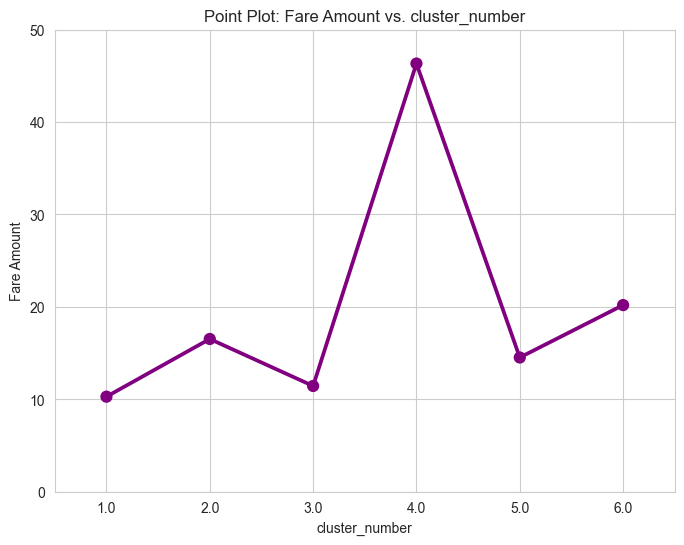

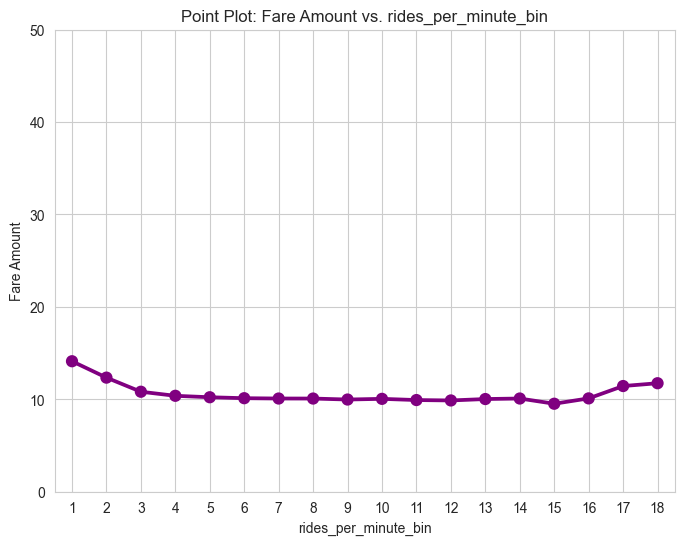

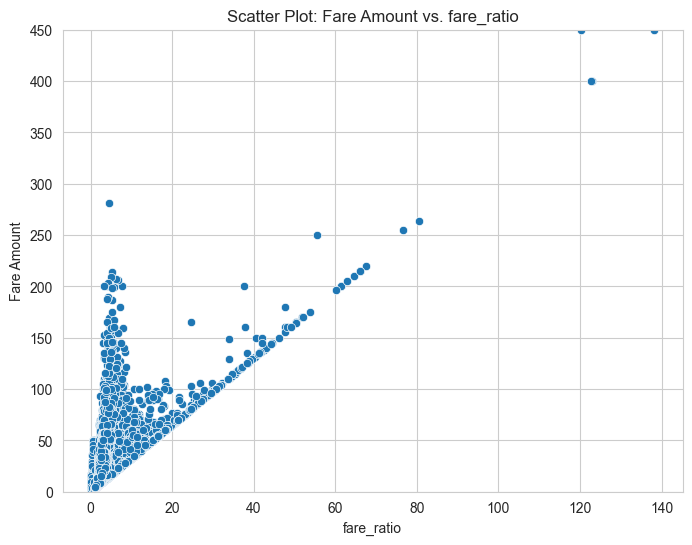

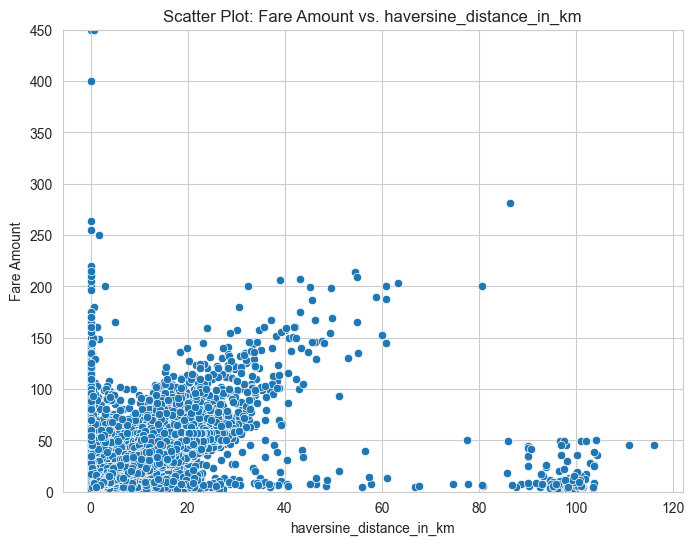

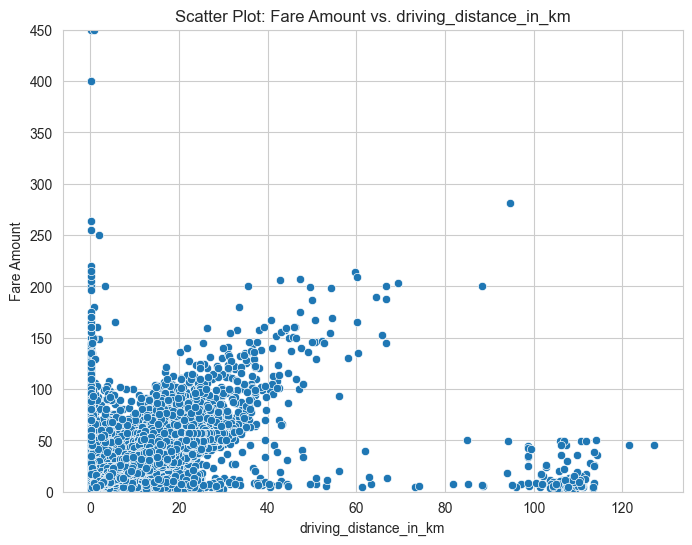

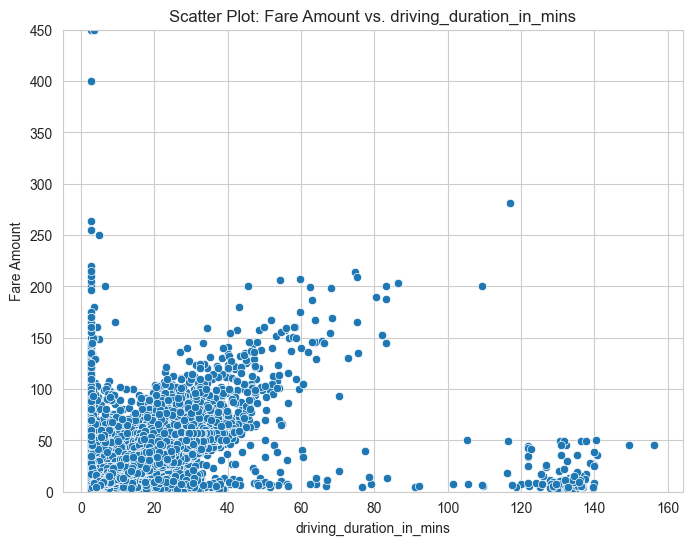

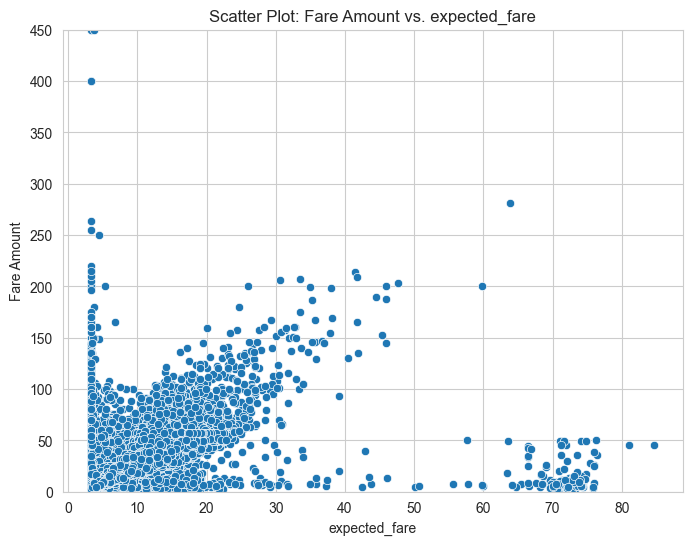

In [ ]:
plt.figure(figsize=(8, 6))

bar_cols = filtered_cab_data_train.columns.drop(['fare_amount', 'fare_ratio', 'expected_fare', 'haversine_distance_in_km', 'driving_distance_in_km', 'driving_duration_in_mins'])
scatter_cols = ['fare_ratio', 'haversine_distance_in_km', 'driving_distance_in_km', 'driving_duration_in_mins', 'expected_fare']

# Create point plots for selected columns
for col in bar_cols:
    plt.figure(figsize=(8, 6))
    
    # Use Seaborn to create the point plot
    sns.pointplot(x=col, y='fare_amount', data=filtered_cab_data_train, color='purple', ci=None)
    
    # Set y-axis starting value to 0
    plt.ylim(0, 50)
    
    # Add labels and title
    plt.xlabel(col)
    plt.ylabel('Fare Amount')
    plt.title(f'Point Plot: Fare Amount vs. {col}')
    
    # Show the plot
    plt.grid(True)
    plt.show()

# Create scatter plots for selected columns
for col in scatter_cols:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=col, y='fare_amount', data=filtered_cab_data_train)
    
    # Set y-axis starting value to 0
    plt.ylim(0, filtered_cab_data_train['fare_amount'].max())
    
    plt.xlabel(col)
    plt.ylabel('Fare Amount')
    plt.title(f'Scatter Plot: Fare Amount vs. {col}')
    plt.grid(True)
    plt.show()

<Figure size 800x600 with 0 Axes>

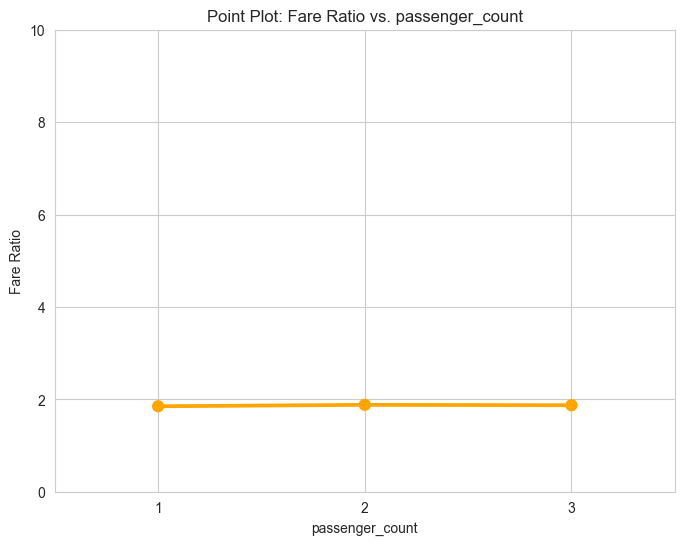

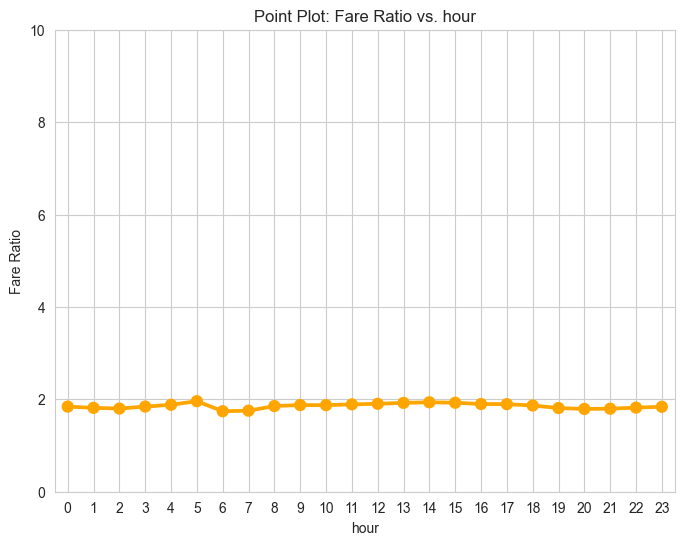

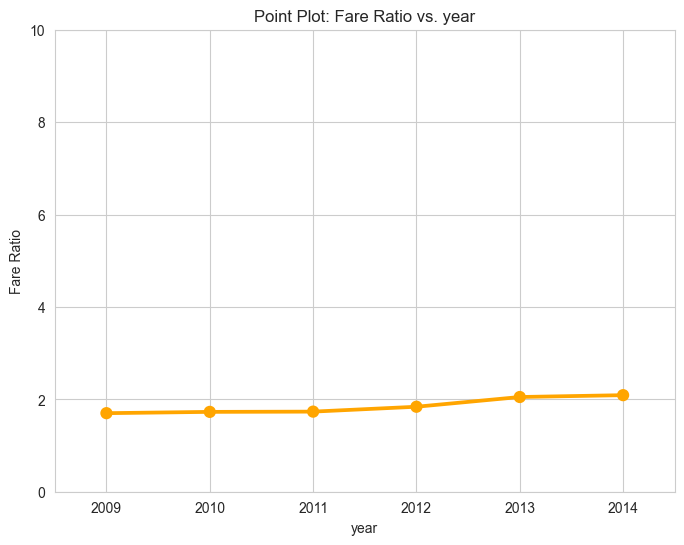

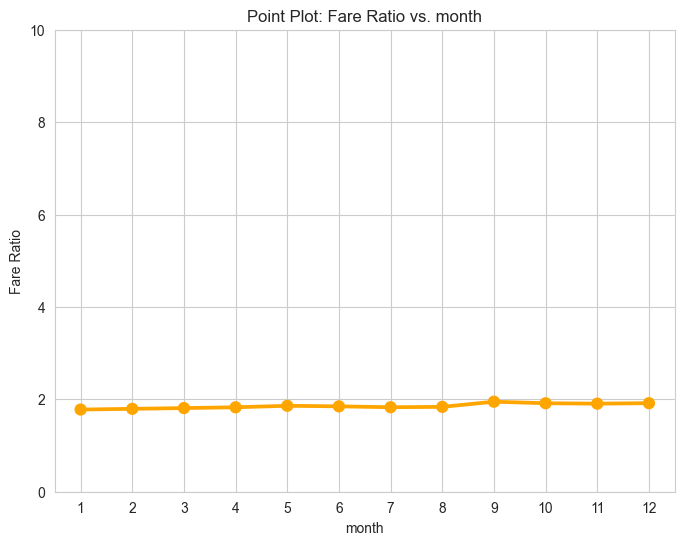

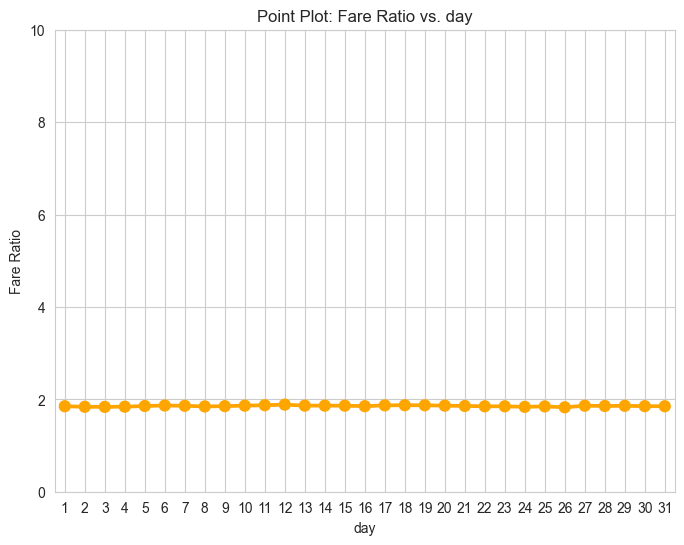

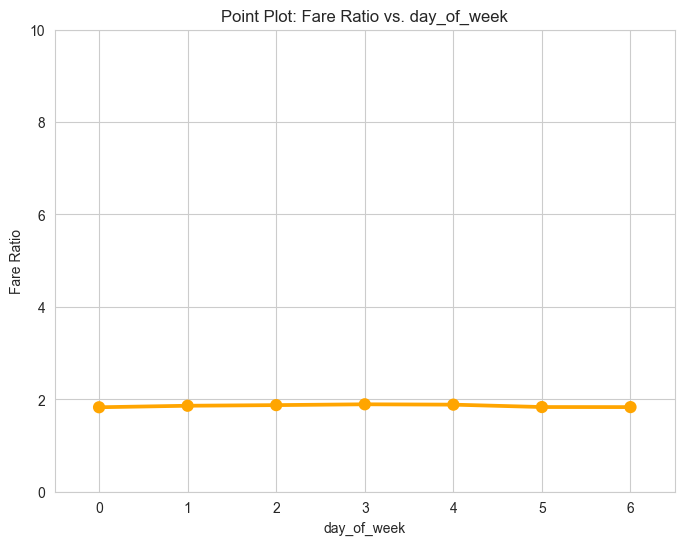

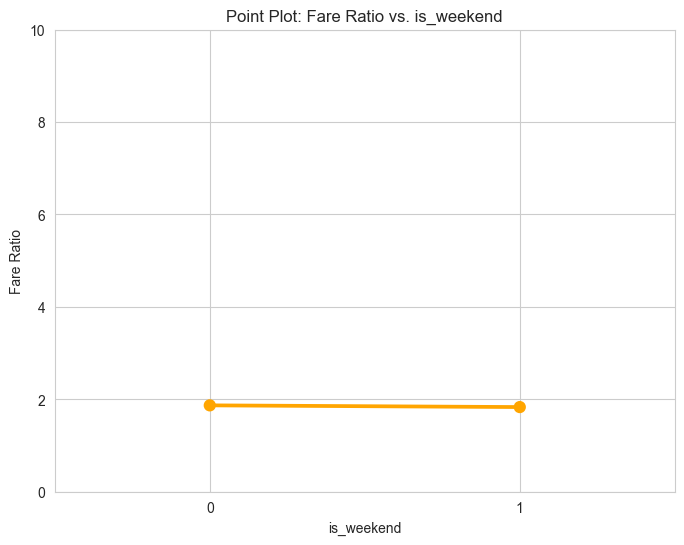

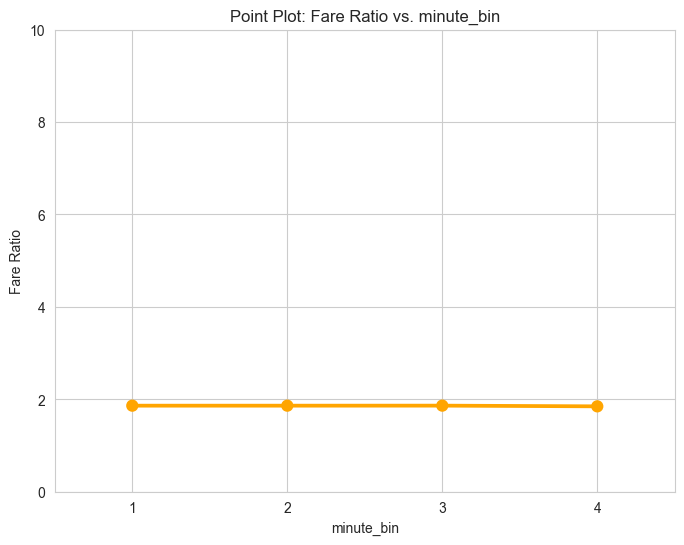

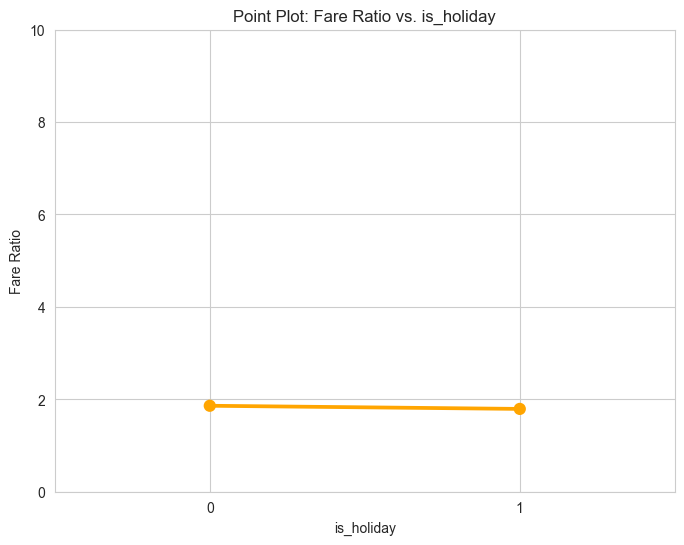

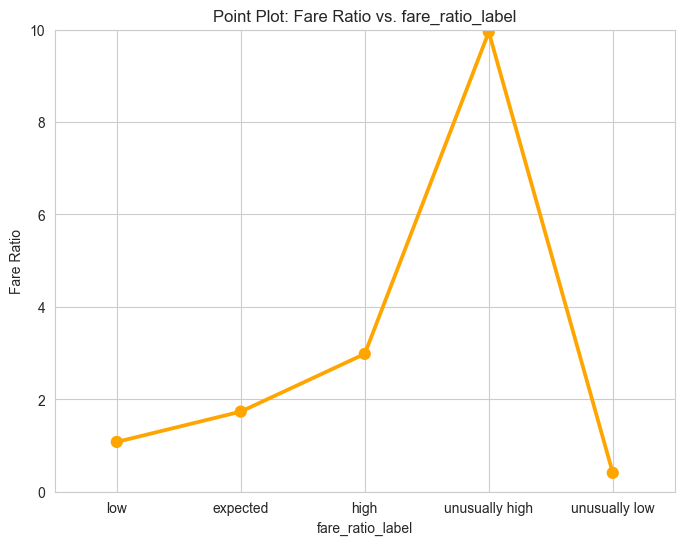

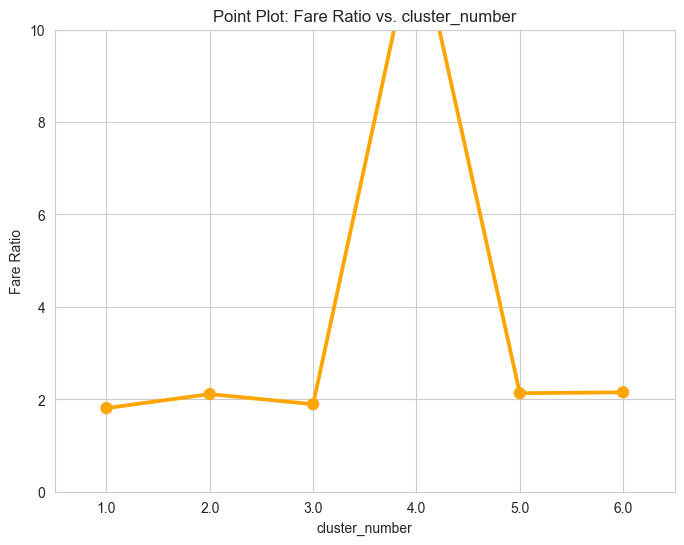

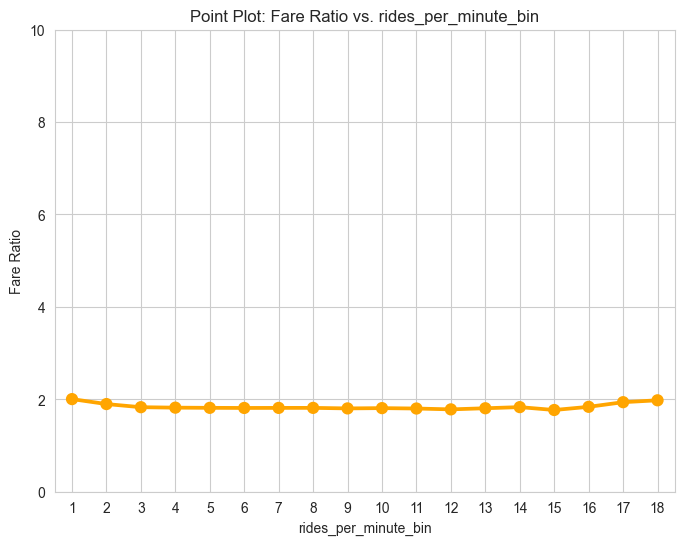

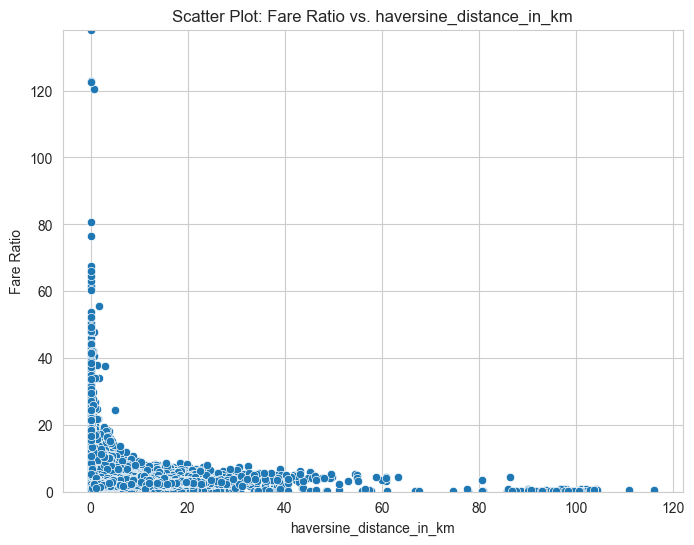

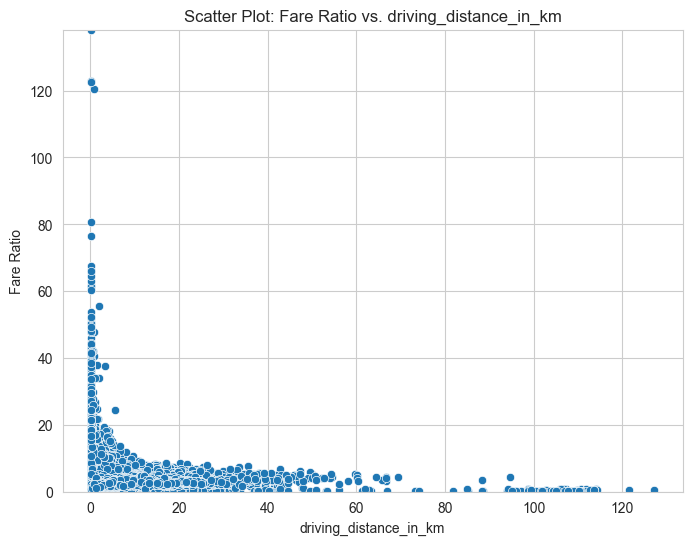

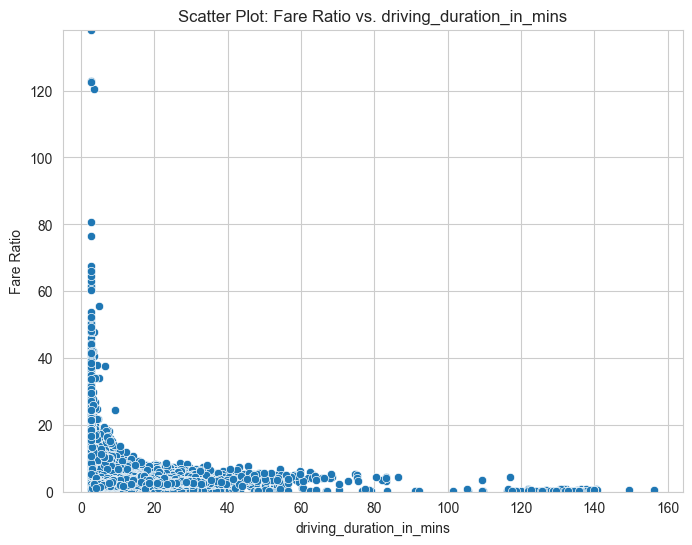

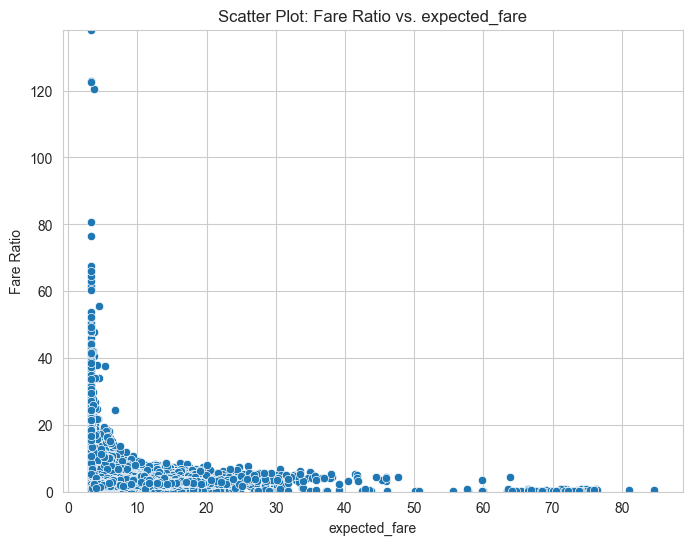

In [ ]:
plt.figure(figsize=(8, 6))

bar_cols = filtered_cab_data_train.columns.drop(['fare_amount', 'fare_ratio', 'expected_fare', 'haversine_distance_in_km', 'driving_distance_in_km', 'driving_duration_in_mins'])
scatter_cols = ['haversine_distance_in_km', 'driving_distance_in_km', 'driving_duration_in_mins', 'expected_fare']

# Create point plots for selected columns
for col in bar_cols:
    plt.figure(figsize=(8, 6))
    
    # Use Seaborn to create the point plot
    sns.pointplot(x=col, y='fare_ratio', data=filtered_cab_data_train, color='orange', ci=None)
    
    # Set y-axis starting value to 0
    plt.ylim(0, 10)
    
    # Add labels and title
    plt.xlabel(col)
    plt.ylabel('Fare Ratio')
    plt.title(f'Point Plot: Fare Ratio vs. {col}')
    
    # Show the plot
    plt.grid(True)
    plt.show()

# Create scatter plots for selected columns
for col in scatter_cols:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=col, y='fare_ratio', data=filtered_cab_data_train)
    
    # Set y-axis starting value to 0
    plt.ylim(0, filtered_cab_data_train['fare_ratio'].max())
    
    plt.xlabel(col)
    plt.ylabel('Fare Ratio')
    plt.title(f'Scatter Plot: Fare Ratio vs. {col}')
    plt.grid(True)
    plt.show()

<span style="color: yellow; font-weight: bold;"> Let's inspect the variation of fare ratio with year and month in detail.</span>

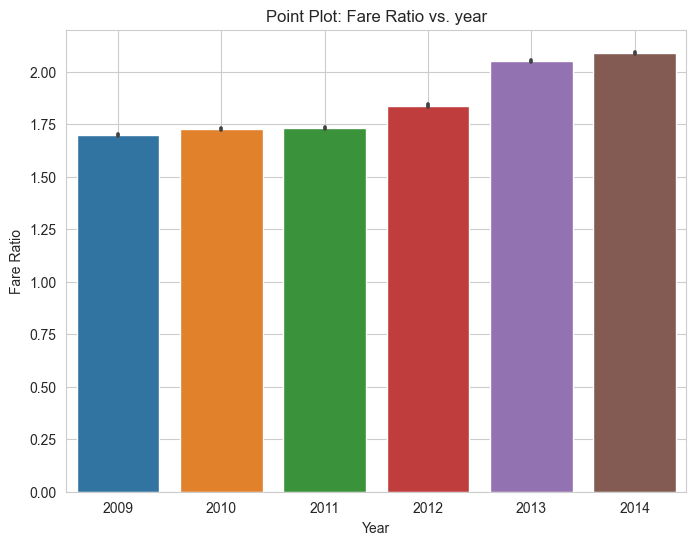

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn to create the point plot
sns.barplot(x='year', y='fare_ratio', data=filtered_cab_data_train)
# Add labels and title
plt.xlabel('Year')
plt.ylabel('Fare Ratio')
plt.title(f'Point Plot: Fare Ratio vs. year')
plt.grid(True)
plt.show()

In [ ]:
filtered_cab_data_train_year_values = list(filtered_cab_data_train['year'].unique())

mean_values_by_year = []
std_values_by_year = []

mean_of_dataset = filtered_cab_data_train['fare_ratio'].mean()

for year in filtered_cab_data_train_year_values:
    mean_of_year = filtered_cab_data_train[filtered_cab_data_train['year'] == year]['fare_ratio'].mean()
    mean_values_by_year.append({'year': year, 'mean_of_year': mean_of_year})
    std_values_by_year.append(mean_of_year)

std_fare_ratio_by_year = np.std(std_values_by_year)

mean_values_by_year= pd.DataFrame(mean_values_by_year)

print(f"Mean value of fare_ratio for the total dataset is:\n {mean_values_by_year}\n")
print(f"Mean value of fare_ratio for the total dataset is: {mean_of_dataset}\n")
print(f"Standard deviation of fare_ratio mean by year is: {std_fare_ratio_by_year}")


Mean value of fare_ratio for the total dataset is:
    year  mean_of_year
0  2009      1.700190
1  2010      1.728308
2  2011      1.733723
3  2012      1.839464
4  2013      2.050114
5  2014      2.089936

Mean value of fare_ratio for the total dataset is: 1.8560982744409051

Standard deviation of fare_ratio mean by year is: 0.15716629486202205


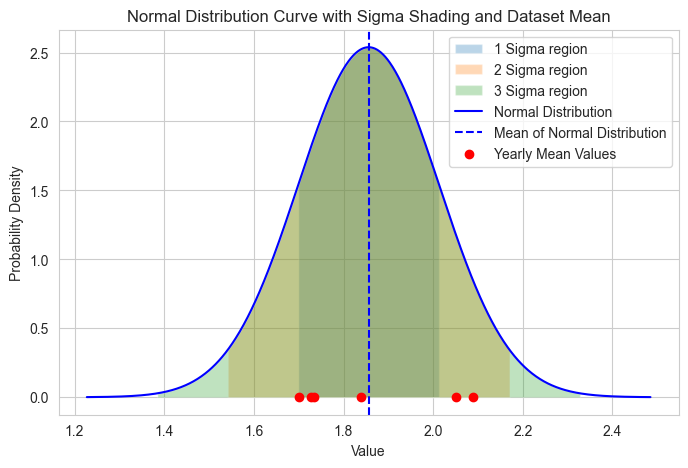

In [ ]:
mean_values = mean_values_by_year['mean_of_year']

# Create a range of x values
x = np.linspace(mean_of_dataset - 4 * std_fare_ratio_by_year, mean_of_dataset + 4 * std_fare_ratio_by_year, 1000)

# Calculate corresponding y values from a normal distribution
y = (1 / (std_fare_ratio_by_year * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_of_dataset) / std_fare_ratio_by_year) ** 2)

# Plotting the normal distribution curve
plt.figure(figsize=(8, 5))

# Plotting shaded regions for different sigma values
for i in range(1, 4):
    plt.fill_between(x, 0, y, where=np.abs(x - mean_of_dataset) <= i * std_fare_ratio_by_year, alpha=0.3,
                     label=f'{i} Sigma region')

# Plotting the normal distribution curve
plt.plot(x, y, label='Normal Distribution', color='blue')

# Marking mean as a blue vertical line
plt.axvline(x=mean_of_dataset, color='blue', linestyle='--', label='Mean of Normal Distribution')

# Plotting red dots for yearly mean values
plt.scatter(mean_values, np.zeros_like(mean_values), color='red', label='Yearly Mean Values', zorder=5)

# Create a separate legend for shaded regions, red dots, and blue line
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='best')

plt.title('Normal Distribution Curve with Sigma Shading and Dataset Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

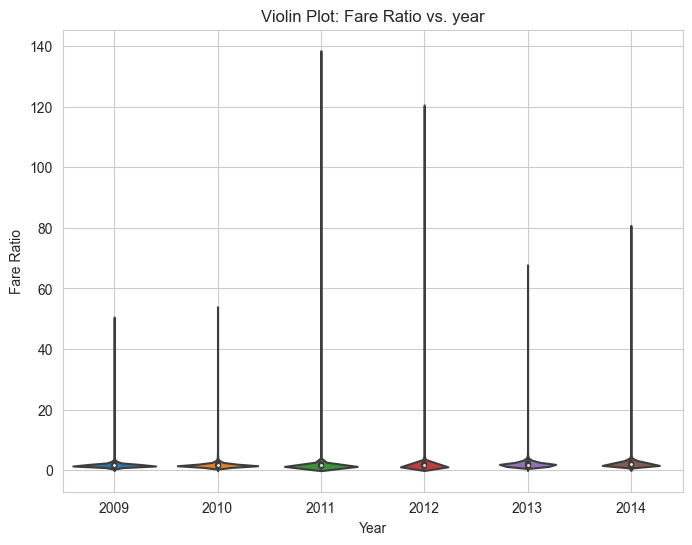

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn to create the violin plot
sns.violinplot(x='year', y='fare_ratio', data=filtered_cab_data_train)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Fare Ratio')
plt.title('Violin Plot: Fare Ratio vs. year')

plt.grid(True)
plt.show()

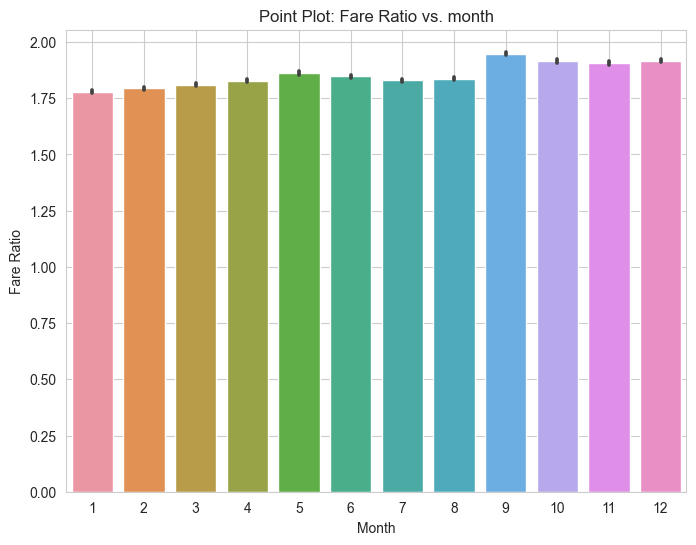

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn to create the point plot
sns.barplot(x='month', y='fare_ratio', data=filtered_cab_data_train)
# Add labels and title
plt.xlabel('Month')
plt.ylabel('Fare Ratio')
plt.title(f'Point Plot: Fare Ratio vs. month')
plt.grid(True)
plt.show()

In [ ]:
filtered_cab_data_train_month_values = list(filtered_cab_data_train['month'].unique())

mean_values_by_month = []
std_values_by_month = []

mean_of_dataset = filtered_cab_data_train['fare_ratio'].mean()

for month in filtered_cab_data_train_month_values:
    mean_of_month = filtered_cab_data_train[filtered_cab_data_train['month'] == month]['fare_ratio'].mean()
    mean_values_by_month.append({'month': month, 'mean_of_month': mean_of_month})
    std_values_by_month.append(mean_of_month)

std_fare_ratio_by_month = np.std(std_values_by_month)

mean_values_by_month= pd.DataFrame(mean_values_by_month)

print(f"Mean value of fare_ratio for the total dataset by month is:\n {mean_values_by_month}\n")
print(f"Mean value of fare_ratio for the total dataset is: {mean_of_dataset}\n")
print(f"Standard deviation of fare_ratio mean by month is: {std_fare_ratio_by_month}")

Mean value of fare_ratio for the total dataset by month is:
     month  mean_of_month
0       6       1.847860
1       1       1.778730
2       8       1.836849
3       4       1.827726
4       3       1.810558
5      11       1.906039
6      12       1.916731
7       9       1.948396
8       7       1.828755
9       2       1.794272
10      5       1.860060
11     10       1.915286

Mean value of fare_ratio for the total dataset is: 1.8560982744409051

Standard deviation of fare_ratio mean by month is: 0.05170514005048929


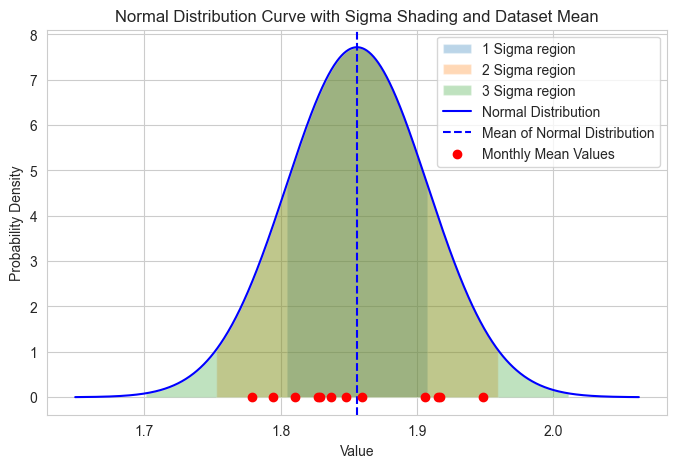

In [ ]:
mean_values = mean_values_by_month['mean_of_month']

# Create a range of x values
x = np.linspace(mean_of_dataset - 4 * std_fare_ratio_by_month, mean_of_dataset + 4 * std_fare_ratio_by_month, 1000)

# Calculate corresponding y values from a normal distribution
y = (1 / (std_fare_ratio_by_month * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_of_dataset) / std_fare_ratio_by_month) ** 2)

# Plotting the normal distribution curve
plt.figure(figsize=(8, 5))

# Plotting shaded regions for different sigma values
for i in range(1, 4):
    plt.fill_between(x, 0, y, where=np.abs(x - mean_of_dataset) <= i * std_fare_ratio_by_month, alpha=0.3,
                     label=f'{i} Sigma region')

# Plotting the normal distribution curve
plt.plot(x, y, label='Normal Distribution', color='blue')

# Marking mean as a blue vertical line
plt.axvline(x=mean_of_dataset, color='blue', linestyle='--', label='Mean of Normal Distribution')

# Plotting red dots for yearly mean values
plt.scatter(mean_values, np.zeros_like(mean_values), color='red', label='Monthly Mean Values', zorder=5)

# Create a separate legend for shaded regions, red dots, and blue line
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='best')

plt.title('Normal Distribution Curve with Sigma Shading and Dataset Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

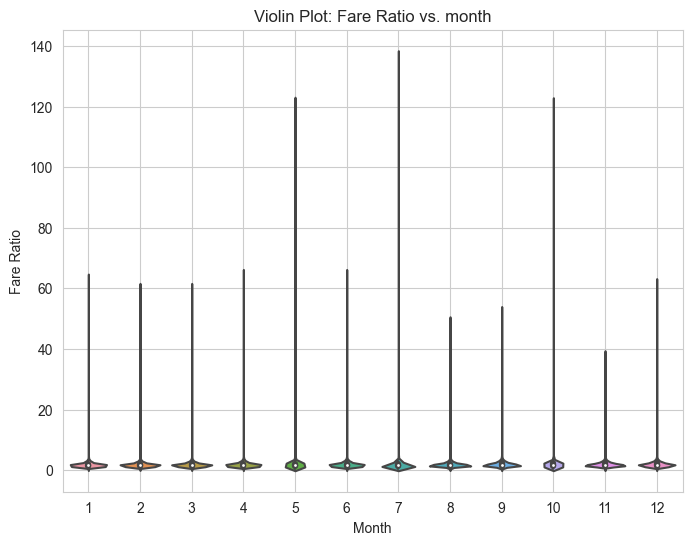

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn to create the violin plot
sns.violinplot(x='month', y='fare_ratio', data=filtered_cab_data_train)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Fare Ratio')
plt.title('Violin Plot: Fare Ratio vs. month')

plt.grid(True)
plt.show()

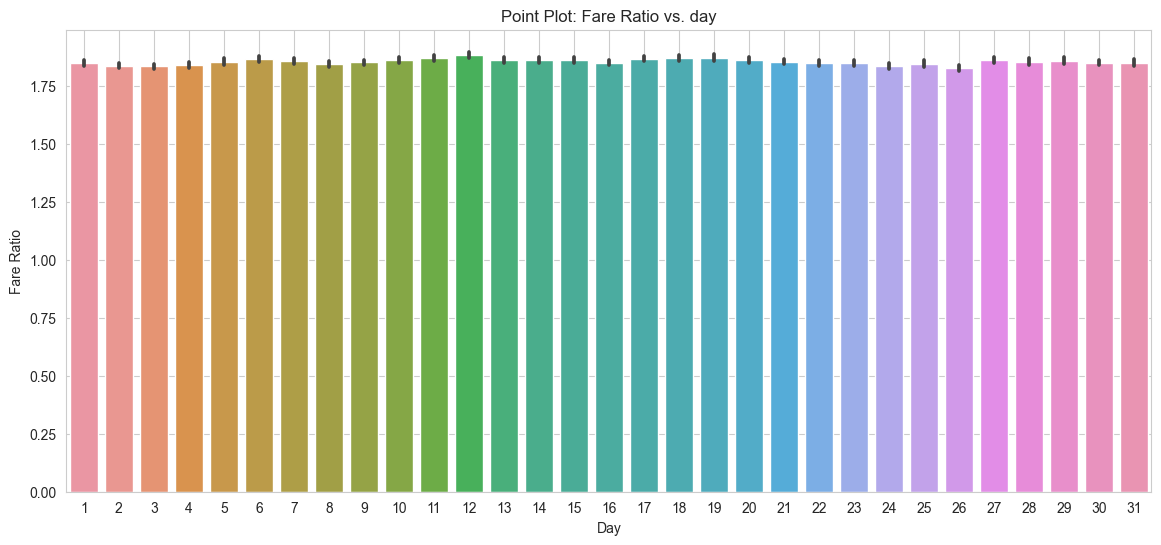

In [ ]:
plt.figure(figsize=(14, 6))

# Use Seaborn to create the point plot
sns.barplot(x='day', y='fare_ratio', data=filtered_cab_data_train)
# Add labels and title
plt.xlabel('Day')
plt.ylabel('Fare Ratio')
plt.title(f'Point Plot: Fare Ratio vs. day')
plt.grid(True)
plt.show()

In [ ]:
filtered_cab_data_train_day_values = list(filtered_cab_data_train['day'].unique())

mean_values_by_day = []
std_values_by_day = []

mean_of_dataset = filtered_cab_data_train['fare_ratio'].mean()

for day in filtered_cab_data_train_day_values:
    mean_of_day = filtered_cab_data_train[filtered_cab_data_train['day'] == day]['fare_ratio'].mean()
    mean_values_by_day.append({'day': day, 'mean_of_day': mean_of_day})
    std_values_by_day.append(mean_of_day)

std_fare_ratio_by_day = np.std(std_values_by_day)

mean_values_by_day = pd.DataFrame(mean_values_by_day)

print(f"Mean value of fare_ratio for the total dataset by day is:\n {mean_values_by_day}\n")
print(f"Mean value of fare_ratio for the total dataset is: {mean_of_dataset}\n")
print(f"Standard deviation of fare_ratio mean by day is: {std_fare_ratio_by_day}")

Mean value of fare_ratio for the total dataset by day is:
     day  mean_of_day
0    15     1.862508
1     5     1.855345
2    18     1.872527
3    21     1.856275
4     9     1.852599
5     6     1.866158
6    20     1.863038
7     4     1.840386
8     3     1.836152
9     2     1.838438
10    8     1.846024
11   19     1.871304
12   22     1.849207
13    7     1.859913
14   12     1.885125
15   10     1.862972
16   28     1.855972
17   11     1.872370
18   29     1.859217
19   31     1.850462
20    1     1.850014
21   14     1.863061
22   23     1.849233
23   16     1.851921
24   27     1.861535
25   25     1.847313
26   17     1.869261
27   30     1.852011
28   26     1.827164
29   24     1.836800
30   13     1.863388

Mean value of fare_ratio for the total dataset is: 1.8560982744409051

Standard deviation of fare_ratio mean by day is: 0.012347166287480102


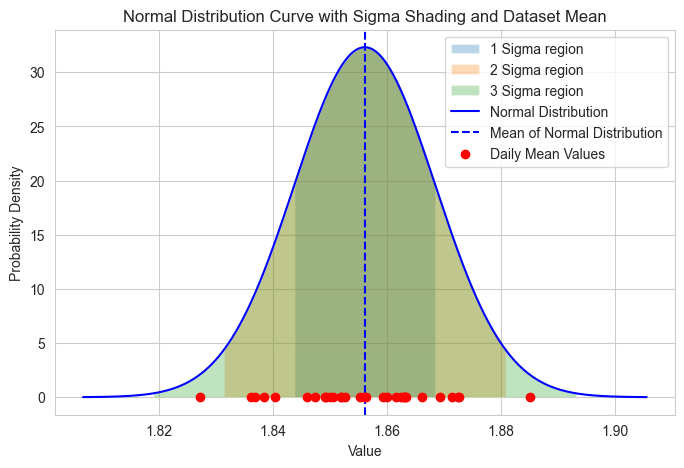

In [ ]:
mean_values = mean_values_by_day['mean_of_day']

# Create a range of x values
x = np.linspace(mean_of_dataset - 4 * std_fare_ratio_by_day, mean_of_dataset + 4 * std_fare_ratio_by_day, 1000)

# Calculate corresponding y values from a normal distribution
y = (1 / (std_fare_ratio_by_day * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_of_dataset) / std_fare_ratio_by_day) ** 2)

# Plotting the normal distribution curve
plt.figure(figsize=(8, 5))

# Plotting shaded regions for different sigma values
for i in range(1, 4):
    plt.fill_between(x, 0, y, where=np.abs(x - mean_of_dataset) <= i * std_fare_ratio_by_day, alpha=0.3,
                     label=f'{i} Sigma region')

# Plotting the normal distribution curve
plt.plot(x, y, label='Normal Distribution', color='blue')

# Marking mean as a blue vertical line
plt.axvline(x=mean_of_dataset, color='blue', linestyle='--', label='Mean of Normal Distribution')

# Plotting red dots for daily mean values
plt.scatter(mean_values, np.zeros_like(mean_values), color='red', label='Daily Mean Values', zorder=5)

# Create a separate legend for shaded regions, red dots, and blue line
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='best')

plt.title('Normal Distribution Curve with Sigma Shading and Dataset Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

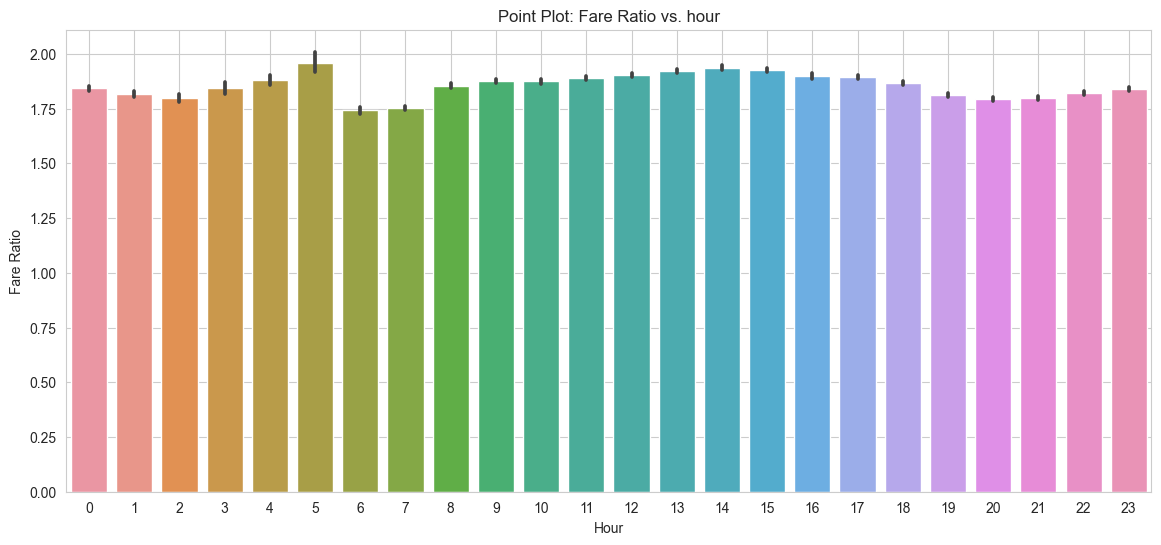

In [ ]:
plt.figure(figsize=(14, 6))

# Use Seaborn to create the point plot
sns.barplot(x='hour', y='fare_ratio', data=filtered_cab_data_train)
# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Fare Ratio')
plt.title(f'Point Plot: Fare Ratio vs. hour')
plt.grid(True)
plt.show()

In [ ]:
filtered_cab_data_train_hour_values = list(filtered_cab_data_train['hour'].unique())

mean_values_by_hour = []
std_values_by_hour = []

mean_of_dataset = filtered_cab_data_train['fare_ratio'].mean()

for hour in filtered_cab_data_train_hour_values:
    mean_of_hour = filtered_cab_data_train[filtered_cab_data_train['hour'] == hour]['fare_ratio'].mean()
    mean_values_by_hour.append({'hour': hour, 'mean_of_hour': mean_of_hour})
    std_values_by_hour.append(mean_of_hour)

std_fare_ratio_by_hour = np.std(std_values_by_hour)

mean_values_by_hour = pd.DataFrame(mean_values_by_hour)

print(f"Mean value of fare_ratio for the total dataset by hour is:\n {mean_values_by_hour}\n")
print(f"Mean value of fare_ratio for the total dataset is: {mean_of_dataset}\n")
print(f"Standard deviation of fare_ratio mean by hour is: {std_fare_ratio_by_hour}")

Mean value of fare_ratio for the total dataset by hour is:
     hour  mean_of_hour
0     17      1.895283
1     16      1.898514
2      0      1.842129
3      4      1.882012
4      7      1.753691
5      9      1.876026
6     20      1.792439
7     13      1.922695
8      1      1.815984
9     19      1.811617
10    14      1.936255
11    12      1.903625
12    18      1.866596
13    15      1.926385
14     6      1.742575
15    23      1.838734
16    10      1.873778
17     8      1.854689
18    21      1.796733
19     3      1.843262
20     2      1.799914
21    22      1.820512
22    11      1.890674
23     5      1.959667

Mean value of fare_ratio for the total dataset is: 1.8560982744409051

Standard deviation of fare_ratio mean by hour is: 0.055689949113023746


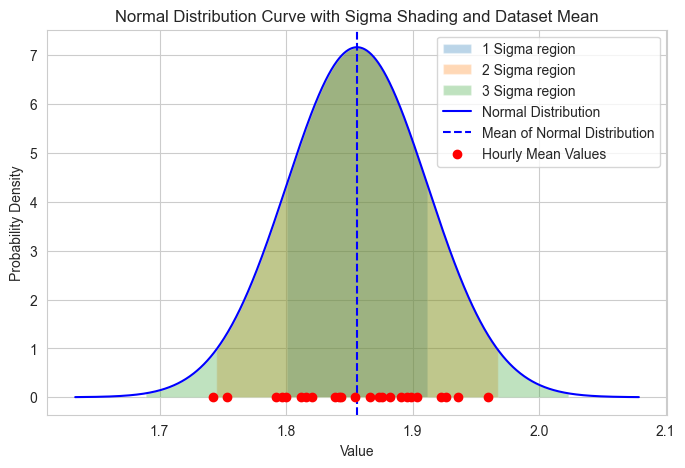

In [ ]:
mean_values = mean_values_by_hour['mean_of_hour']

# Create a range of x values
x = np.linspace(mean_of_dataset - 4 * std_fare_ratio_by_hour, mean_of_dataset + 4 * std_fare_ratio_by_hour, 1000)

# Calculate corresponding y values from a normal distribution
y = (1 / (std_fare_ratio_by_hour * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_of_dataset) / std_fare_ratio_by_hour) ** 2)

# Plotting the normal distribution curve
plt.figure(figsize=(8, 5))

# Plotting shaded regions for different sigma values
for i in range(1, 4):
    plt.fill_between(x, 0, y, where=np.abs(x - mean_of_dataset) <= i * std_fare_ratio_by_hour, alpha=0.3,
                     label=f'{i} Sigma region')

# Plotting the normal distribution curve
plt.plot(x, y, label='Normal Distribution', color='blue')

# Marking mean as a blue vertical line
plt.axvline(x=mean_of_dataset, color='blue', linestyle='--', label='Mean of Normal Distribution')

# Plotting red dots for hourly mean values
plt.scatter(mean_values, np.zeros_like(mean_values), color='red', label='Hourly Mean Values', zorder=5)

# Create a separate legend for shaded regions, red dots, and blue line
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='best')

plt.title('Normal Distribution Curve with Sigma Shading and Dataset Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

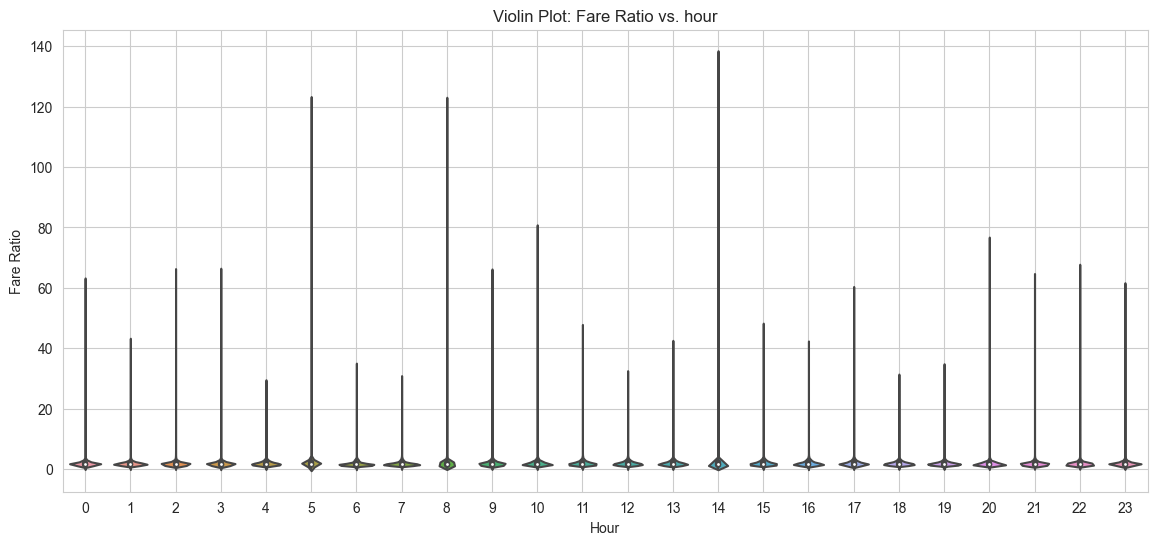

In [ ]:
plt.figure(figsize=(14, 6))

# Use Seaborn to create the violin plot
sns.violinplot(x='hour', y='fare_ratio', data=filtered_cab_data_train)

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Fare Ratio')
plt.title('Violin Plot: Fare Ratio vs. hour')

plt.grid(True)
plt.show()

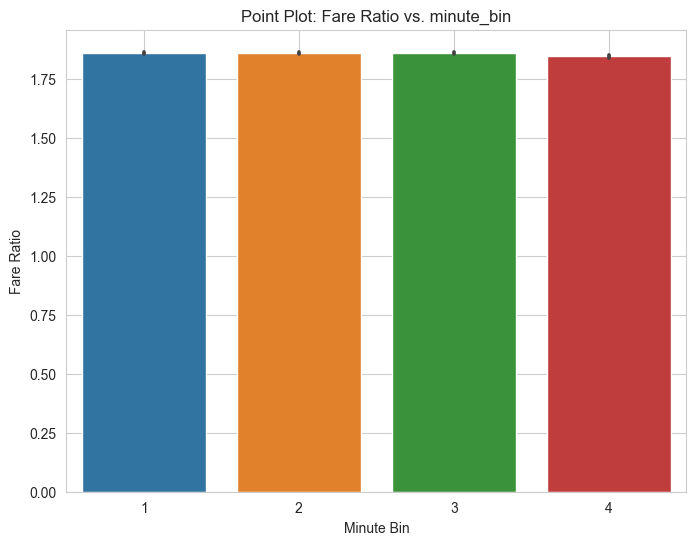

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn to create the point plot
sns.barplot(x='minute_bin', y='fare_ratio', data=filtered_cab_data_train)
# Add labels and title
plt.xlabel('Minute Bin')
plt.ylabel('Fare Ratio')
plt.title(f'Point Plot: Fare Ratio vs. minute_bin')
plt.grid(True)
plt.show()

In [ ]:
filtered_cab_data_train_minute_bin_values = list(filtered_cab_data_train['minute_bin'].unique())

mean_values_by_minute_bin = []
std_values_by_minute_bin = []

mean_of_dataset = filtered_cab_data_train['fare_ratio'].mean()

for minute_bin in filtered_cab_data_train_minute_bin_values:
    mean_of_minute_bin = filtered_cab_data_train[filtered_cab_data_train['minute_bin'] == minute_bin]['fare_ratio'].mean()
    mean_values_by_minute_bin.append({'minute_bin': minute_bin, 'mean_of_minute_bin': mean_of_minute_bin})
    std_values_by_minute_bin.append(mean_of_minute_bin)

std_fare_ratio_by_minute_bin = np.std(std_values_by_minute_bin)

mean_values_by_minute_bin = pd.DataFrame(mean_values_by_minute_bin)

print(f"Mean value of fare_ratio for the total dataset by minute_bin is:\n {mean_values_by_minute_bin}\n")
print(f"Mean value of fare_ratio for the total dataset is: {mean_of_dataset}\n")
print(f"Standard deviation of fare_ratio mean by minute_bin is: {std_fare_ratio_by_minute_bin}")

Mean value of fare_ratio for the total dataset by minute_bin is:
    minute_bin  mean_of_minute_bin
0           2            1.859615
1           4            1.845026
2           3            1.860354
3           1            1.859523

Mean value of fare_ratio for the total dataset is: 1.8560982744409051

Standard deviation of fare_ratio mean by minute_bin is: 0.0064185468472224075


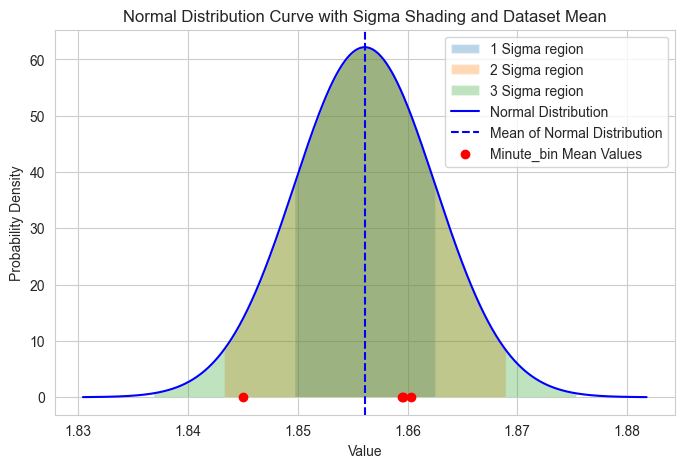

In [ ]:
mean_values = mean_values_by_minute_bin['mean_of_minute_bin']

# Create a range of x values
x = np.linspace(mean_of_dataset - 4 * std_fare_ratio_by_minute_bin, mean_of_dataset + 4 * std_fare_ratio_by_minute_bin, 1000)

# Calculate corresponding y values from a normal distribution
y = (1 / (std_fare_ratio_by_minute_bin * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_of_dataset) / std_fare_ratio_by_minute_bin) ** 2)

# Plotting the normal distribution curve
plt.figure(figsize=(8, 5))

# Plotting shaded regions for different sigma values
for i in range(1, 4):
    plt.fill_between(x, 0, y, where=np.abs(x - mean_of_dataset) <= i * std_fare_ratio_by_minute_bin, alpha=0.3,
                     label=f'{i} Sigma region')

# Plotting the normal distribution curve
plt.plot(x, y, label='Normal Distribution', color='blue')

# Marking mean as a blue vertical line
plt.axvline(x=mean_of_dataset, color='blue', linestyle='--', label='Mean of Normal Distribution')

# Plotting red dots for minute_bin mean values
plt.scatter(mean_values, np.zeros_like(mean_values), color='red', label='Minute_bin Mean Values', zorder=5)

# Create a separate legend for shaded regions, red dots, and blue line
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='best')

plt.title('Normal Distribution Curve with Sigma Shading and Dataset Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

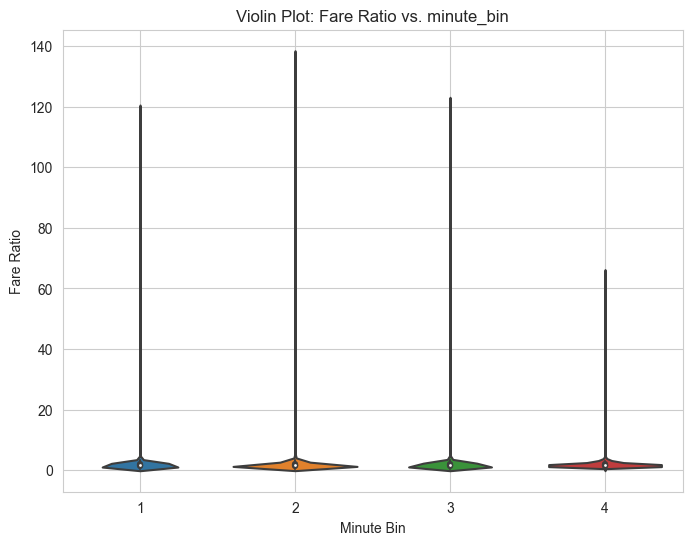

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn to create the violin plot
sns.violinplot(x='minute_bin', y='fare_ratio', data=filtered_cab_data_train)

# Add labels and title
plt.xlabel('Minute Bin')
plt.ylabel('Fare Ratio')
plt.title('Violin Plot: Fare Ratio vs. minute_bin')

plt.grid(True)
plt.show()

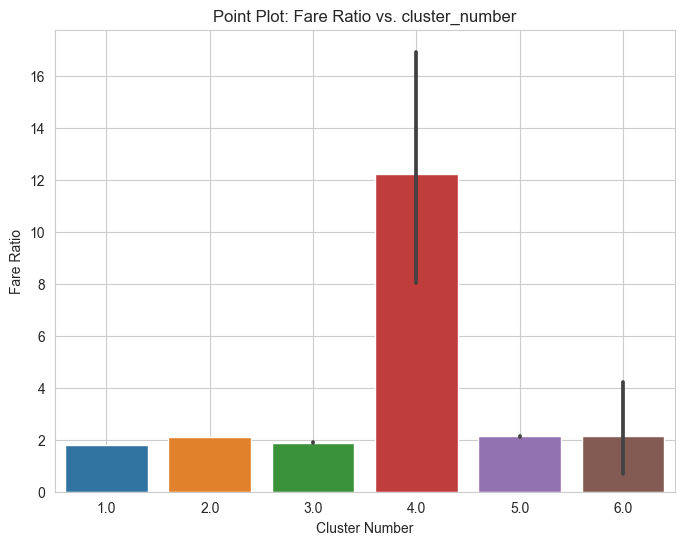

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn to create the point plot
sns.barplot(x='cluster_number', y='fare_ratio', data=filtered_cab_data_train)
# Add labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Fare Ratio')
plt.title(f'Point Plot: Fare Ratio vs. cluster_number')
plt.grid(True)
plt.show()

In [ ]:
filtered_cab_data_train_cluster_number_values = list(filtered_cab_data_train['cluster_number'].unique())

mean_values_by_cluster_number = []
std_values_by_cluster_number = []

mean_of_dataset = filtered_cab_data_train['fare_ratio'].mean()

for cluster_number in filtered_cab_data_train_cluster_number_values:
    mean_of_cluster_number = filtered_cab_data_train[filtered_cab_data_train['cluster_number'] == cluster_number]['fare_ratio'].mean()
    mean_values_by_cluster_number.append({'cluster_number': cluster_number, 'mean_of_cluster_number': mean_of_cluster_number})
    std_values_by_cluster_number.append(mean_of_cluster_number)

std_fare_ratio_by_cluster_number = np.std(std_values_by_cluster_number)

mean_values_by_cluster_number = pd.DataFrame(mean_values_by_cluster_number)

print(f"Mean value of fare_ratio for the total dataset by cluster_number is:\n {mean_values_by_cluster_number}\n")
print(f"Mean value of fare_ratio for the total dataset is: {mean_of_dataset}\n")
print(f"Standard deviation of fare_ratio mean by cluster_number is: {std_fare_ratio_by_cluster_number}")

Mean value of fare_ratio for the total dataset by cluster_number is:
    cluster_number  mean_of_cluster_number
0             2.0                2.109633
1             5.0                2.129132
2             1.0                1.806608
3             3.0                1.890911
4             4.0               12.234609
5             6.0                2.149025

Mean value of fare_ratio for the total dataset is: 1.8560982744409051

Standard deviation of fare_ratio mean by cluster_number is: 3.8100154862142532


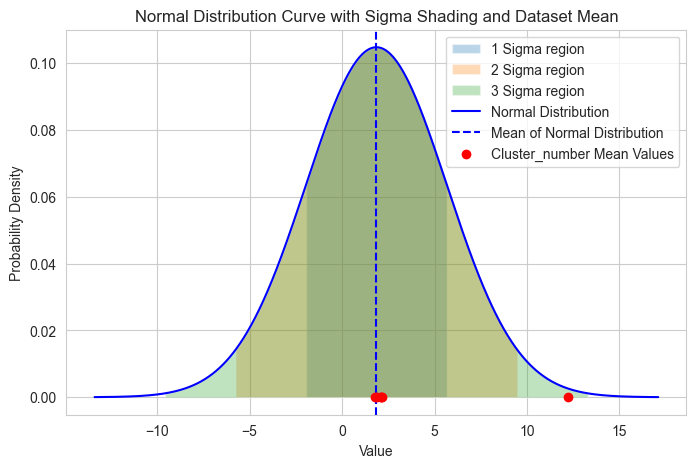

In [ ]:
mean_values = mean_values_by_cluster_number['mean_of_cluster_number']

# Create a range of x values
x = np.linspace(mean_of_dataset - 4 * std_fare_ratio_by_cluster_number, mean_of_dataset + 4 * std_fare_ratio_by_cluster_number, 1000)

# Calculate corresponding y values from a normal distribution
y = (1 / (std_fare_ratio_by_cluster_number * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_of_dataset) / std_fare_ratio_by_cluster_number) ** 2)

# Plotting the normal distribution curve
plt.figure(figsize=(8, 5))

# Plotting shaded regions for different sigma values
for i in range(1, 4):
    plt.fill_between(x, 0, y, where=np.abs(x - mean_of_dataset) <= i * std_fare_ratio_by_cluster_number, alpha=0.3,
                     label=f'{i} Sigma region')

# Plotting the normal distribution curve
plt.plot(x, y, label='Normal Distribution', color='blue')

# Marking mean as a blue vertical line
plt.axvline(x=mean_of_dataset, color='blue', linestyle='--', label='Mean of Normal Distribution')

# Plotting red dots for cluster_number mean values
plt.scatter(mean_values, np.zeros_like(mean_values), color='red', label='Cluster_number Mean Values', zorder=5)

# Create a separate legend for shaded regions, red dots, and blue line
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='best')

plt.title('Normal Distribution Curve with Sigma Shading and Dataset Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

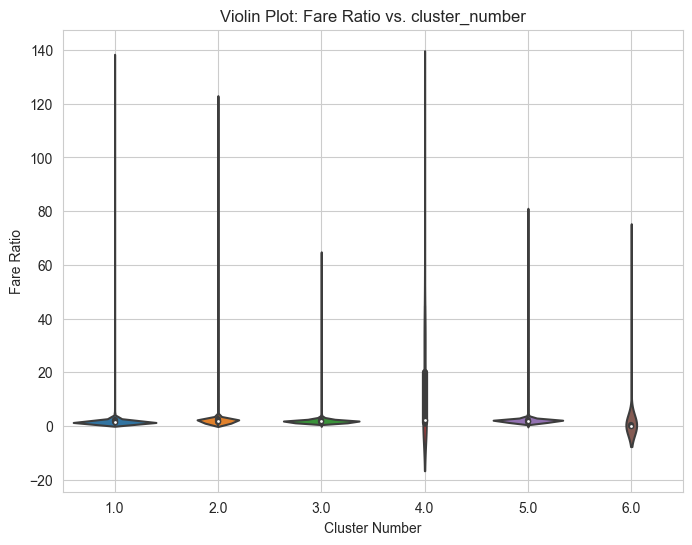

In [ ]:
plt.figure(figsize=(8, 6))

# Use Seaborn to create the violin plot
sns.violinplot(x='cluster_number', y='fare_ratio', data=filtered_cab_data_train)

# Add labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Fare Ratio')
plt.title('Violin Plot: Fare Ratio vs. cluster_number')

plt.grid(True)
plt.show()

<span style="color: yellow; font-weight: bold;"> From the above point plots graphs it is evident that year has some noticeable effect on the price may be due to inflation over the years, while month and hour has negligible effect on the fare_amount.</span>

In [ ]:
filtered_cab_data_train.head()

fare_amount  passenger_count hour  year month day day_of_week is_weekend  \
0          4.5                1   17  2009     6  15           0          0   
1         16.9                1   16  2010     1   5           1          0   
2         15.7                1   16  2010     1   5           1          0   
3          5.7                2    0  2011     8  18           3          0   
4          4.9                1    0  2011     8  18           3          0   

  minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
0          2                  1.030764                  4.016573   
1          4                  8.450134                 13.837513   
2          4                  6.253716                 10.930138   
3          3                  1.389525                  4.491462   
4          3                  1.842285                  5.090775   

   driving_distance_in_km  is_holiday  expected_fare  fare_ratio  \
0                1.185770           0       3.977392    1.131395   
1                9.311980           0       9.181858    1.840586   
2                6.906310           0       7.641136    2.054668   
3                1.578711           0       4.229052    1.347820   
4                2.074604           0       4.546650    1.077717   

  fare_ratio_label cluster_number  rides_per_minute_bin  
0              low            2.0                     1  
1         expected            5.0                     2  
2         expected            5.0                     2  
3         expected            1.0                     2  
4              low            1.0                     2

In [ ]:
filtered_cab_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794872 entries, 0 to 794871
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   fare_amount               794872 non-null  float64
 1   passenger_count           794872 non-null  int64  
 2   hour                      794872 non-null  object 
 3   year                      794872 non-null  object 
 4   month                     794872 non-null  object 
 5   day                       794872 non-null  object 
 6   day_of_week               794872 non-null  object 
 7   is_weekend                794872 non-null  object 
 8   minute_bin                794872 non-null  object 
 9   haversine_distance_in_km  794872 non-null  float64
 10  driving_duration_in_mins  794872 non-null  float64
 11  driving_distance_in_km    794872 non-null  float64
 12  is_holiday                794872 non-null  int64  
 13  expected_fare             794872 non-null  f

In [ ]:
filtered_cab_data_train.isnull().mean()

fare_amount                 0.0
passenger_count             0.0
hour                        0.0
year                        0.0
month                       0.0
day                         0.0
day_of_week                 0.0
is_weekend                  0.0
minute_bin                  0.0
haversine_distance_in_km    0.0
driving_duration_in_mins    0.0
driving_distance_in_km      0.0
is_holiday                  0.0
expected_fare               0.0
fare_ratio                  0.0
fare_ratio_label            0.0
cluster_number              0.0
rides_per_minute_bin        0.0
dtype: float64

<span style="color:yellow; font-weight:bold;"> We will make a train dataset based on the above analysis from graphs and hetamaps which will consist of features that affects the fare_ratio most.</span>.

In [ ]:
filtered_cab_data_train_final= filtered_cab_data_train.drop(columns= ['year', 'haversine_distance_in_km', 'driving_distance_in_km', 'expected_fare', 'fare_ratio',], axis=1)

filtered_cab_data_train_final.head()

fare_amount  passenger_count hour month day day_of_week is_weekend  \
0          4.5                1   17     6  15           0          0   
1         16.9                1   16     1   5           1          0   
2         15.7                1   16     1   5           1          0   
3          5.7                2    0     8  18           3          0   
4          4.9                1    0     8  18           3          0   

  minute_bin  driving_duration_in_mins  is_holiday fare_ratio_label  \
0          2                  4.016573           0              low   
1          4                 13.837513           0         expected   
2          4                 10.930138           0         expected   
3          3                  4.491462           0         expected   
4          3                  5.090775           0              low   

  cluster_number  rides_per_minute_bin  
0            2.0                     1  
1            5.0                     2  
2            5.0                     2  
3            1.0                     2  
4            1.0                     2

In [ ]:
filtered_cab_data_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794872 entries, 0 to 794871
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   fare_amount               794872 non-null  float64
 1   passenger_count           794872 non-null  int64  
 2   hour                      794872 non-null  object 
 3   month                     794872 non-null  object 
 4   day                       794872 non-null  object 
 5   day_of_week               794872 non-null  object 
 6   is_weekend                794872 non-null  object 
 7   minute_bin                794872 non-null  object 
 8   driving_duration_in_mins  794872 non-null  float64
 9   is_holiday                794872 non-null  int64  
 10  fare_ratio_label          794872 non-null  object 
 11  cluster_number            794872 non-null  object 
 12  rides_per_minute_bin      794872 non-null  int64  
dtypes: float64(2), int64(3), object(8)
memory us

In [ ]:
filtered_cab_data_train_final['is_weekend'] = filtered_cab_data_train_final['is_weekend'].astype(int)

filtered_cab_data_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794872 entries, 0 to 794871
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   fare_amount               794872 non-null  float64
 1   passenger_count           794872 non-null  int64  
 2   hour                      794872 non-null  object 
 3   month                     794872 non-null  object 
 4   day                       794872 non-null  object 
 5   day_of_week               794872 non-null  object 
 6   is_weekend                794872 non-null  int32  
 7   minute_bin                794872 non-null  object 
 8   driving_duration_in_mins  794872 non-null  float64
 9   is_holiday                794872 non-null  int64  
 10  fare_ratio_label          794872 non-null  object 
 11  cluster_number            794872 non-null  object 
 12  rides_per_minute_bin      794872 non-null  int64  
dtypes: float64(2), int32(1), int64(3), object(7)

In [ ]:
# Mapping dictionary for assigning numeric values to categories
label_mapping = {
    'unusually low': 0,
    'low': 1,
    'expected': 2,
    'high': 3,
    'unusually high': 4}

# Apply mapping to the 'fare_ratio_label' column in filtered_cab_data_train_final DataFrame
filtered_cab_data_train_final['fare_ratio_label'] = filtered_cab_data_train_final['fare_ratio_label'].map(label_mapping)

filtered_cab_data_train_final.head()


fare_amount  passenger_count hour month day day_of_week  is_weekend  \
0          4.5                1   17     6  15           0           0   
1         16.9                1   16     1   5           1           0   
2         15.7                1   16     1   5           1           0   
3          5.7                2    0     8  18           3           0   
4          4.9                1    0     8  18           3           0   

  minute_bin  driving_duration_in_mins  is_holiday  fare_ratio_label  \
0          2                  4.016573           0                 1   
1          4                 13.837513           0                 2   
2          4                 10.930138           0                 2   
3          3                  4.491462           0                 2   
4          3                  5.090775           0                 1   

  cluster_number  rides_per_minute_bin  
0            2.0                     1  
1            5.0                     2  
2            5.0                     2  
3            1.0                     2  
4            1.0                     2

In [ ]:
filtered_cab_data_train_final= filtered_cab_data_train_final.drop(columns=['rides_per_minute_bin'], axis=1)

filtered_cab_data_train_final.head()

fare_amount  passenger_count hour month day day_of_week  is_weekend  \
0          4.5                1   17     6  15           0           0   
1         16.9                1   16     1   5           1           0   
2         15.7                1   16     1   5           1           0   
3          5.7                2    0     8  18           3           0   
4          4.9                1    0     8  18           3           0   

  minute_bin  driving_duration_in_mins  is_holiday  fare_ratio_label  \
0          2                  4.016573           0                 1   
1          4                 13.837513           0                 2   
2          4                 10.930138           0                 2   
3          3                  4.491462           0                 2   
4          3                  5.090775           0                 1   

  cluster_number  
0            2.0  
1            5.0  
2            5.0  
3            1.0  
4            1.0

In [ ]:
categorical_columns = filtered_cab_data_train_final.select_dtypes(include='object').columns.tolist()

# Applying one-hot encoding to categorical columns
filtered_cab_data_train_encoded = pd.get_dummies(filtered_cab_data_train_final, columns=categorical_columns, drop_first=True)

filtered_cab_data_train_encoded.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
0          4.5                1           0                  4.016573   
1         16.9                1           0                 13.837513   
2         15.7                1           0                 10.930138   
3          5.7                2           0                  4.491462   
4          4.9                1           0                  5.090775   

   is_holiday  fare_ratio_label  hour_1  hour_2  hour_3  hour_4  hour_5  \
0           0                 1   False   False   False   False   False   
1           0                 2   False   False   False   False   False   
2           0                 2   False   False   False   False   False   
3           0                 2   False   False   False   False   False   
4           0                 1   False   False   False   False   False   

   hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  \
0   False   False   False   False    False    False    False    False   
1   False   False   False   False    False    False    False    False   
2   False   False   False   False    False    False    False    False   
3   False   False   False   False    False    False    False    False   
4   False   False   False   False    False    False    False    False   

   hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
0    False    False    False     True    False    False    False    False   
1    False    False     True    False    False    False    False    False   
2    False    False     True    False    False    False    False    False   
3    False    False    False    False    False    False    False    False   
4    False    False    False    False    False    False    False    False   

   hour_22  hour_23  month_2  month_3  month_4  month_5  month_6  month_7  \
0    False    False    False    False    False    False     True    False   
1    False    False    False    False    False    False    False    False   
2    False    False    False    False    False    False    False    False   
3    False    False    False    False    False    False    False    False   
4    False    False    False    False    False    False    False    False   

   month_8  month_9  month_10  month_11  month_12  day_2  day_3  day_4  day_5  \
0    False    False     False     False     False  False  False  False  False   
1    False    False     False     False     False  False  False  False   True   
2    False    False     False     False     False  False  False  False   True   
3     True    False     False     False     False  False  False  False  False   
4     True    False     False     False     False  False  False  False  False   

   day_6  day_7  day_8  day_9  day_10  day_11  day_12  day_13  day_14  day_15  \
0  False  False  False  False   False   False   False   False   False    True   
1  False  False  False  False   False   False   False   False   False   False   
2  False  False  False  False   False   False   False   False   False   False   
3  False  False  False  False   False   False   False   False   False   False   
4  False  False  False  False   False   False   False   False   False   False   

   day_16  day_17  day_18  day_19  day_20  day_21  day_22  day_23  day_24  \
0   False   False   False   False   False   False   False   False   False   
1   False   False   False   False   False   False   False   False   False   
2   False   False   False   False   False   False   False   False   False   
3   False   False    True   False   False   False   False   False   False   
4   False   False    True   False   False   False   False   False   False   

   day_25  day_26  day_27  day_28  day_29  day_30  day_31  day_of_week_1  \
0   False   False   False   False   False   False   False          False   
1   False   False   False   False   False   False   False           True   
2   False   False   False   False   False   False   False           True   
3   Fal

In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_columns = filtered_cab_data_train_final.drop(columns=['fare_ratio_label'], axis=1).select_dtypes(include='number').columns.tolist()

# Apply StandardScaler to numerical columns
scaler = StandardScaler()

filtered_cab_data_train_encoded[numerical_columns] = scaler.fit_transform(filtered_cab_data_train_encoded[numerical_columns])

filtered_cab_data_train_encoded.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
0    -0.704443        -0.493287   -0.621477                 -0.614988   
1     0.600317        -0.493287   -0.621477                  1.345206   
2     0.474050        -0.493287   -0.621477                  0.764914   
3    -0.578176         1.344821   -0.621477                 -0.520203   
4    -0.662354        -0.493287   -0.621477                 -0.400585   

   is_holiday  fare_ratio_label  hour_1  hour_2  hour_3  hour_4  hour_5  \
0   -0.153217                 1   False   False   False   False   False   
1   -0.153217                 2   False   False   False   False   False   
2   -0.153217                 2   False   False   False   False   False   
3   -0.153217                 2   False   False   False   False   False   
4   -0.153217                 1   False   False   False   False   False   

   hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  \
0   False   False   False   False    False    False    False    False   
1   False   False   False   False    False    False    False    False   
2   False   False   False   False    False    False    False    False   
3   False   False   False   False    False    False    False    False   
4   False   False   False   False    False    False    False    False   

   hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
0    False    False    False     True    False    False    False    False   
1    False    False     True    False    False    False    False    False   
2    False    False     True    False    False    False    False    False   
3    False    False    False    False    False    False    False    False   
4    False    False    False    False    False    False    False    False   

   hour_22  hour_23  month_2  month_3  month_4  month_5  month_6  month_7  \
0    False    False    False    False    False    False     True    False   
1    False    False    False    False    False    False    False    False   
2    False    False    False    False    False    False    False    False   
3    False    False    False    False    False    False    False    False   
4    False    False    False    False    False    False    False    False   

   month_8  month_9  month_10  month_11  month_12  day_2  day_3  day_4  day_5  \
0    False    False     False     False     False  False  False  False  False   
1    False    False     False     False     False  False  False  False   True   
2    False    False     False     False     False  False  False  False   True   
3     True    False     False     False     False  False  False  False  False   
4     True    False     False     False     False  False  False  False  False   

   day_6  day_7  day_8  day_9  day_10  day_11  day_12  day_13  day_14  day_15  \
0  False  False  False  False   False   False   False   False   False    True   
1  False  False  False  False   False   False   False   False   False   False   
2  False  False  False  False   False   False   False   False   False   False   
3  False  False  False  False   False   False   False   False   False   False   
4  False  False  False  False   False   False   False   False   False   False   

   day_16  day_17  day_18  day_19  day_20  day_21  day_22  day_23  day_24  \
0   False   False   False   False   False   False   False   False   False   
1   False   False   False   False   False   False   False   False   False   
2   False   False   False   False   False   False   False   False   False   
3   False   False    True   False   False   False   False   False   False   
4   False   False    True   False   False   False   False   False   False   

   day_25  day_26  day_27  day_28  day_29  day_30  day_31  day_of_week_1  \
0   False   False   False   False   False   False   False          False   
1   False   False   False   False   False   False   False           True   
2   False   False   False   False   False   False   False           True   
3   Fal

<span style="color:yellow; font-weight:bold;"> Now we shall engineer the test data</span>.

In [ ]:
filtered_cab_data_test.head(1)

key  fare_amount           pickup_datetime  \
31  2015-06-21 21:46:34.0000001        22.54 2015-06-21 21:46:34+00:00   

    pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
31        -74.010483        40.717667         -73.985771         40.660366   

    passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
31                1    21      46  2015      6   21            6           1   

   minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
31          4                  6.703551                 11.525581   

    driving_distance_in_km  is_holiday  
31                7.399002           0

In [ ]:
# Function to predict the cluster based on given coordinates
def predict_cluster(pickup_longitude, pickup_latitude):
    # Cluster statistics (mean)
    cluster_means = {
        0: [-73.960806, 40.779984],
        1: [-73.996246, 40.725910],
        2: [-73.784296, 40.647002],
        3: [-73.873491, 40.768373],
        4: [-73.982306, 40.755760],
        5: [-73.182241, 41.322917]
    }
    
    min_distance = float('inf')
    predicted_cluster = -1
    
    for cluster, mean_coords in cluster_means.items():
        # Calculating squared Euclidean distance
        distance = ((pickup_longitude - mean_coords[0])**2 + (pickup_latitude - mean_coords[1])**2)
        
        if distance < min_distance:
            min_distance = distance
            predicted_cluster = cluster
    
    return predicted_cluster

# Adding a new column 'predicted_cluster' to the DataFrame using the predict_cluster function
filtered_cab_data_test['cluster_number'] = filtered_cab_data_test.apply(
    lambda row: predict_cluster(row['pickup_longitude'], row['pickup_latitude']), axis=1)

filtered_cab_data_test.head()

C:\Users\sandi\AppData\Local\Temp\ipykernel_8484\3359169377.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cab_data_test['cluster_number'] = filtered_cab_data_test.apply(


key  fare_amount           pickup_datetime  \
31  2015-06-21 21:46:34.0000001        22.54 2015-06-21 21:46:34+00:00   
35  2015-01-11 03:15:38.0000001        58.00 2015-01-11 03:15:38+00:00   
36  2015-03-12 08:08:38.0000001         4.50 2015-03-12 08:08:38+00:00   
69  2015-05-12 23:51:42.0000007         5.00 2015-05-12 23:51:42+00:00   
89  2015-03-04 14:55:40.0000006         5.00 2015-03-04 14:55:40+00:00   

    pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
31        -74.010483        40.717667         -73.985771         40.660366   
35        -73.983330        40.738720         -73.933197         40.847225   
36        -73.990173        40.756447         -73.985619         40.762829   
69        -73.954796        40.779335         -73.944931         40.780087   
89        -73.988747        40.744953         -73.995682         40.744221   

    passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
31                1    21      46  2015      6   21            6           1   
35                1     3      15  2015      1   11            6           1   
36                1     8       8  2015      3   12            3           0   
69                1    23      51  2015      5   12            1           0   
89                2    14      55  2015      3    4            2           0   

   minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
31          4                  6.703551                 11.525581   
35          2                 12.782056                 19.571632   
36          1                  0.806699                  3.719981   
69          4                  0.834807                  3.757187   
89          4                  0.589893                  3.432997   

    driving_distance_in_km  is_holiday  cluster_number  
31                7.399002           0               1  
35               14.056602           0               4  
36                0.940359           0               4  
69                0.971145           0               0  
89                0.702898           0               4

In [ ]:
filtered_cab_data_test['cluster_number'].unique()

array([1, 4, 0, 3, 2], dtype=int64)

In [ ]:
filtered_cab_data_test['cluster_number']= filtered_cab_data_test['cluster_number']+1

filtered_cab_data_test.head()

C:\Users\sandi\AppData\Local\Temp\ipykernel_8484\3524057039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cab_data_test['cluster_number']= filtered_cab_data_test['cluster_number']+1


key  fare_amount           pickup_datetime  \
31  2015-06-21 21:46:34.0000001        22.54 2015-06-21 21:46:34+00:00   
35  2015-01-11 03:15:38.0000001        58.00 2015-01-11 03:15:38+00:00   
36  2015-03-12 08:08:38.0000001         4.50 2015-03-12 08:08:38+00:00   
69  2015-05-12 23:51:42.0000007         5.00 2015-05-12 23:51:42+00:00   
89  2015-03-04 14:55:40.0000006         5.00 2015-03-04 14:55:40+00:00   

    pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
31        -74.010483        40.717667         -73.985771         40.660366   
35        -73.983330        40.738720         -73.933197         40.847225   
36        -73.990173        40.756447         -73.985619         40.762829   
69        -73.954796        40.779335         -73.944931         40.780087   
89        -73.988747        40.744953         -73.995682         40.744221   

    passenger_count  hour  minute  year  month  day  day_of_week  is_weekend  \
31                1    21      46  2015      6   21            6           1   
35                1     3      15  2015      1   11            6           1   
36                1     8       8  2015      3   12            3           0   
69                1    23      51  2015      5   12            1           0   
89                2    14      55  2015      3    4            2           0   

   minute_bin  haversine_distance_in_km  driving_duration_in_mins  \
31          4                  6.703551                 11.525581   
35          2                 12.782056                 19.571632   
36          1                  0.806699                  3.719981   
69          4                  0.834807                  3.757187   
89          4                  0.589893                  3.432997   

    driving_distance_in_km  is_holiday  cluster_number  
31                7.399002           0               2  
35               14.056602           0               5  
36                0.940359           0               5  
69                0.971145           0               1  
89                0.702898           0               5

In [ ]:
filtered_cab_data_test['cluster_number'].unique()

array([2, 5, 1, 4, 3], dtype=int64)

In [ ]:
filtered_cab_data_test.isnull().mean()

key                         0.0
fare_amount                 0.0
pickup_datetime             0.0
pickup_longitude            0.0
pickup_latitude             0.0
dropoff_longitude           0.0
dropoff_latitude            0.0
passenger_count             0.0
hour                        0.0
minute                      0.0
year                        0.0
month                       0.0
day                         0.0
day_of_week                 0.0
is_weekend                  0.0
minute_bin                  0.0
haversine_distance_in_km    0.0
driving_duration_in_mins    0.0
driving_distance_in_km      0.0
is_holiday                  0.0
cluster_number              0.0
dtype: float64

In [ ]:
# Get the columns from both DataFrames
test_columns = set(filtered_cab_data_test.columns)
train_columns = set(filtered_cab_data_train_final.columns)

# Columns in filtered_cab_data_test that are not in filtered_cab_data_train
missing_in_train = list(test_columns - train_columns)

# Columns in filtered_cab_data_train that are not in filtered_cab_data_test
missing_in_test = list(train_columns - test_columns)

print(f"Columns missing in filtered_cab_data_train: {missing_in_train}")
print(f"Columns missing in filtered_cab_data_test: {missing_in_test}")

Columns missing in filtered_cab_data_train: ['pickup_longitude', 'key', 'year', 'haversine_distance_in_km', 'driving_distance_in_km', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude', 'minute', 'pickup_datetime']
Columns missing in filtered_cab_data_test: ['fare_ratio_label']


In [ ]:
filtered_cab_data_test_final= filtered_cab_data_test.drop(columns= ['pickup_longitude', 'driving_distance_in_km', 'year', 'dropoff_longitude', 'dropoff_latitude', 'minute', 'pickup_latitude', 'key', 'haversine_distance_in_km', 'pickup_datetime'] , axis=1)

filtered_cab_data_test_final.head()

fare_amount  passenger_count  hour  month  day  day_of_week  is_weekend  \
31        22.54                1    21      6   21            6           1   
35        58.00                1     3      1   11            6           1   
36         4.50                1     8      3   12            3           0   
69         5.00                1    23      5   12            1           0   
89         5.00                2    14      3    4            2           0   

   minute_bin  driving_duration_in_mins  is_holiday  cluster_number  
31          4                 11.525581           0               2  
35          2                 19.571632           0               5  
36          1                  3.719981           0               5  
69          4                  3.757187           0               1  
89          4                  3.432997           0               5

In [ ]:
# Get the columns from both DataFrames
test_columns = set(filtered_cab_data_test_final.columns)
train_columns = set(filtered_cab_data_train_final.columns)

# Columns in filtered_cab_data_test that are not in filtered_cab_data_train
missing_in_train = list(test_columns - train_columns)

# Columns in filtered_cab_data_train that are not in filtered_cab_data_test
missing_in_test = list(train_columns - test_columns)

print(f"Columns missing in filtered_cab_data_train: {missing_in_train}")
print(f"Columns missing in filtered_cab_data_test: {missing_in_test}")

Columns missing in filtered_cab_data_train: []
Columns missing in filtered_cab_data_test: ['fare_ratio_label']


In [ ]:
columns_to_rearrange = filtered_cab_data_train_final.drop(columns=['fare_ratio_label']).columns.tolist()
filtered_cab_data_test_final = filtered_cab_data_test_final[columns_to_rearrange]

filtered_cab_data_test_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60606 entries, 31 to 999986
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   fare_amount               60606 non-null  float64 
 1   passenger_count           60606 non-null  int64   
 2   hour                      60606 non-null  int32   
 3   month                     60606 non-null  int32   
 4   day                       60606 non-null  int32   
 5   day_of_week               60606 non-null  int32   
 6   is_weekend                60606 non-null  int32   
 7   minute_bin                60606 non-null  category
 8   driving_duration_in_mins  60606 non-null  float64 
 9   is_holiday                60606 non-null  int32   
 10  cluster_number            60606 non-null  int64   
dtypes: category(1), float64(2), int32(6), int64(2)
memory usage: 3.8 MB


In [ ]:
filtered_cab_data_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794872 entries, 0 to 794871
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   fare_amount               794872 non-null  float64
 1   passenger_count           794872 non-null  int64  
 2   hour                      794872 non-null  object 
 3   month                     794872 non-null  object 
 4   day                       794872 non-null  object 
 5   day_of_week               794872 non-null  object 
 6   is_weekend                794872 non-null  int32  
 7   minute_bin                794872 non-null  object 
 8   driving_duration_in_mins  794872 non-null  float64
 9   is_holiday                794872 non-null  int64  
 10  fare_ratio_label          794872 non-null  int64  
 11  cluster_number            794872 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(6)
memory usage: 69.7+ MB


In [ ]:
filtered_cab_data_test_final.shape

(60606, 11)

In [ ]:
columns_to_convert = ['hour', 'month', 'day', 'day_of_week', 'minute_bin', 'cluster_number']
filtered_cab_data_test_final[columns_to_convert] = filtered_cab_data_test_final[columns_to_convert].astype(str)

In [ ]:
filtered_cab_data_test_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60606 entries, 31 to 999986
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fare_amount               60606 non-null  float64
 1   passenger_count           60606 non-null  int64  
 2   hour                      60606 non-null  object 
 3   month                     60606 non-null  object 
 4   day                       60606 non-null  object 
 5   day_of_week               60606 non-null  object 
 6   is_weekend                60606 non-null  int32  
 7   minute_bin                60606 non-null  object 
 8   driving_duration_in_mins  60606 non-null  float64
 9   is_holiday                60606 non-null  int32  
 10  cluster_number            60606 non-null  object 
dtypes: float64(2), int32(2), int64(1), object(6)
memory usage: 5.1+ MB


In [ ]:
categorical_columns = filtered_cab_data_test_final.select_dtypes(include='object').columns.tolist()

filtered_cab_data_test_encoded = pd.get_dummies(filtered_cab_data_test_final, columns=categorical_columns, drop_first=True)

filtered_cab_data_test_encoded.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
31        22.54                1           1                 11.525581   
35        58.00                1           1                 19.571632   
36         4.50                1           0                  3.719981   
69         5.00                1           0                  3.757187   
89         5.00                2           0                  3.432997   

    is_holiday  hour_1  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
31           0   False    False    False    False    False    False    False   
35           0   False    False    False    False    False    False    False   
36           0   False    False    False    False    False    False    False   
69           0   False    False    False    False    False    False    False   
89           0   False    False    False    False    False     True    False   

    hour_16  hour_17  hour_18  hour_19  hour_2  hour_20  hour_21  hour_22  \
31    False    False    False    False   False    False     True    False   
35    False    False    False    False   False    False    False    False   
36    False    False    False    False   False    False    False    False   
69    False    False    False    False   False    False    False    False   
89    False    False    False    False   False    False    False    False   

    hour_23  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  hour_9  month_2  \
31    False   False   False   False   False   False   False   False    False   
35    False    True   False   False   False   False   False   False    False   
36    False   False   False   False   False   False    True   False    False   
69     True   False   False   False   False   False   False   False    False   
89    False   False   False   False   False   False   False   False    False   

    month_3  month_4  month_5  month_6  day_10  day_11  day_12  day_13  \
31    False    False    False     True   False   False   False   False   
35    False    False    False    False   False    True   False   False   
36     True    False    False    False   False   False    True   False   
69    False    False     True    False   False   False    True   False   
89     True    False    False    False   False   False   False   False   

    day_14  day_15  day_16  day_17  day_18  day_19  day_2  day_20  day_21  \
31   False   False   False   False   False   False  False   False    True   
35   False   False   False   False   False   False  False   False   False   
36   False   False   False   False   False   False  False   False   False   
69   False   False   False   False   False   False  False   False   False   
89   False   False   False   False   False   False  False   False   False   

    day_22  day_23  day_24  day_25  day_26  day_27  day_28  day_29  day_3  \
31   False   False   False   False   False   False   False   False  False   
35   False   False   False   False   False   False   False   False  False   
36   False   False   False   False   False   False   False   False  False   
69   False   False   False   False   False   False   False   False  False   
89   False   False   False   False   False   False   False   False  False   

    day_30  day_31  day_4  day_5  day_6  day_7  day_8  day_9  day_of_week_1  \
31   False   False  False  False  False  False  False  False          False   
35   False   False  False  False  False  False  False  False          False   
36   False   False  False  False  False  False  False  False          False   
69   False   False  False  False  False  False  False  False           True   
89   False   False   True  False  False  False  False  False          False   

    day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  \
31          False          False          False          False           True   
35          False          False          False          False           True   
36          False           True          Fal

In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_columns = filtered_cab_data_train_final.drop(columns=['fare_ratio_label'], axis=1).select_dtypes(include='number').columns.tolist()

scaler = StandardScaler()

filtered_cab_data_test_encoded[numerical_columns] = scaler.fit_transform(filtered_cab_data_test_encoded[numerical_columns])

filtered_cab_data_test_encoded.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
31     0.827705        -0.477410    1.549519                  0.857272   
35     3.900582        -0.477410    1.549519                  2.442079   
36    -0.735598        -0.477410   -0.645361                 -0.680174   
69    -0.692269        -0.477410   -0.645361                 -0.672846   
89    -0.692269         1.403247   -0.645361                 -0.736700   

    is_holiday  hour_1  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
31   -0.133997   False    False    False    False    False    False    False   
35   -0.133997   False    False    False    False    False    False    False   
36   -0.133997   False    False    False    False    False    False    False   
69   -0.133997   False    False    False    False    False    False    False   
89   -0.133997   False    False    False    False    False     True    False   

    hour_16  hour_17  hour_18  hour_19  hour_2  hour_20  hour_21  hour_22  \
31    False    False    False    False   False    False     True    False   
35    False    False    False    False   False    False    False    False   
36    False    False    False    False   False    False    False    False   
69    False    False    False    False   False    False    False    False   
89    False    False    False    False   False    False    False    False   

    hour_23  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  hour_9  month_2  \
31    False   False   False   False   False   False   False   False    False   
35    False    True   False   False   False   False   False   False    False   
36    False   False   False   False   False   False    True   False    False   
69     True   False   False   False   False   False   False   False    False   
89    False   False   False   False   False   False   False   False    False   

    month_3  month_4  month_5  month_6  day_10  day_11  day_12  day_13  \
31    False    False    False     True   False   False   False   False   
35    False    False    False    False   False    True   False   False   
36     True    False    False    False   False   False    True   False   
69    False    False     True    False   False   False    True   False   
89     True    False    False    False   False   False   False   False   

    day_14  day_15  day_16  day_17  day_18  day_19  day_2  day_20  day_21  \
31   False   False   False   False   False   False  False   False    True   
35   False   False   False   False   False   False  False   False   False   
36   False   False   False   False   False   False  False   False   False   
69   False   False   False   False   False   False  False   False   False   
89   False   False   False   False   False   False  False   False   False   

    day_22  day_23  day_24  day_25  day_26  day_27  day_28  day_29  day_3  \
31   False   False   False   False   False   False   False   False  False   
35   False   False   False   False   False   False   False   False  False   
36   False   False   False   False   False   False   False   False  False   
69   False   False   False   False   False   False   False   False  False   
89   False   False   False   False   False   False   False   False  False   

    day_30  day_31  day_4  day_5  day_6  day_7  day_8  day_9  day_of_week_1  \
31   False   False  False  False  False  False  False  False          False   
35   False   False  False  False  False  False  False  False          False   
36   False   False  False  False  False  False  False  False          False   
69   False   False  False  False  False  False  False  False           True   
89   False   False   True  False  False  False  False  False          False   

    day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  \
31          False          False          False          False           True   
35          False          False          False          False           True   
36          False           True          Fal

In [ ]:
filtered_cab_data_test_encoded['cluster_number_6'] = False

filtered_cab_data_test_encoded.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
31     0.827705        -0.477410    1.549519                  0.857272   
35     3.900582        -0.477410    1.549519                  2.442079   
36    -0.735598        -0.477410   -0.645361                 -0.680174   
69    -0.692269        -0.477410   -0.645361                 -0.672846   
89    -0.692269         1.403247   -0.645361                 -0.736700   

    is_holiday  hour_1  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
31   -0.133997   False    False    False    False    False    False    False   
35   -0.133997   False    False    False    False    False    False    False   
36   -0.133997   False    False    False    False    False    False    False   
69   -0.133997   False    False    False    False    False    False    False   
89   -0.133997   False    False    False    False    False     True    False   

    hour_16  hour_17  hour_18  hour_19  hour_2  hour_20  hour_21  hour_22  \
31    False    False    False    False   False    False     True    False   
35    False    False    False    False   False    False    False    False   
36    False    False    False    False   False    False    False    False   
69    False    False    False    False   False    False    False    False   
89    False    False    False    False   False    False    False    False   

    hour_23  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  hour_9  month_2  \
31    False   False   False   False   False   False   False   False    False   
35    False    True   False   False   False   False   False   False    False   
36    False   False   False   False   False   False    True   False    False   
69     True   False   False   False   False   False   False   False    False   
89    False   False   False   False   False   False   False   False    False   

    month_3  month_4  month_5  month_6  day_10  day_11  day_12  day_13  \
31    False    False    False     True   False   False   False   False   
35    False    False    False    False   False    True   False   False   
36     True    False    False    False   False   False    True   False   
69    False    False     True    False   False   False    True   False   
89     True    False    False    False   False   False   False   False   

    day_14  day_15  day_16  day_17  day_18  day_19  day_2  day_20  day_21  \
31   False   False   False   False   False   False  False   False    True   
35   False   False   False   False   False   False  False   False   False   
36   False   False   False   False   False   False  False   False   False   
69   False   False   False   False   False   False  False   False   False   
89   False   False   False   False   False   False  False   False   False   

    day_22  day_23  day_24  day_25  day_26  day_27  day_28  day_29  day_3  \
31   False   False   False   False   False   False   False   False  False   
35   False   False   False   False   False   False   False   False  False   
36   False   False   False   False   False   False   False   False  False   
69   False   False   False   False   False   False   False   False  False   
89   False   False   False   False   False   False   False   False  False   

    day_30  day_31  day_4  day_5  day_6  day_7  day_8  day_9  day_of_week_1  \
31   False   False  False  False  False  False  False  False          False   
35   False   False  False  False  False  False  False  False          False   
36   False   False  False  False  False  False  False  False          False   
69   False   False  False  False  False  False  False  False           True   
89   False   False   True  False  False  False  False  False          False   

    day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  \
31          False          False          False          False           True   
35          False          False          False          False           True   
36          False           True          Fal

In [ ]:

filtered_cab_data_test_encoded.shape[1]

77

In [ ]:
filtered_cab_data_train_encoded.shape[1]

84

In [ ]:
# Get the columns from both DataFrames
test_columns = set(filtered_cab_data_test_encoded.columns)
train_columns = set(filtered_cab_data_train_encoded.columns)

# Columns in filtered_cab_data_test that are not in filtered_cab_data_train
missing_in_train = list(test_columns - train_columns)

# Columns in filtered_cab_data_train that are not in filtered_cab_data_test
missing_in_test = list(train_columns - test_columns)

print(f"Columns missing in filtered_cab_data_train_encoded: {missing_in_train}")
print(f"Columns missing in filtered_cab_data_test_encoded: {missing_in_test}")

Columns missing in filtered_cab_data_train_encoded: ['cluster_number_3', 'cluster_number_6', 'cluster_number_4', 'cluster_number_2', 'cluster_number_5']
Columns missing in filtered_cab_data_test_encoded: ['month_9', 'cluster_number_3.0', 'cluster_number_2.0', 'month_11', 'month_7', 'fare_ratio_label', 'month_8', 'cluster_number_6.0', 'month_12', 'cluster_number_5.0', 'cluster_number_4.0', 'month_10']


In [ ]:
columns_to_rename = {
    'cluster_number_5.0': 'cluster_number_5',
    'cluster_number_4.0': 'cluster_number_4',
    'cluster_number_3.0': 'cluster_number_3',
    'cluster_number_2.0': 'cluster_number_2',
    'cluster_number_6.0': 'cluster_number_6'
}

filtered_cab_data_train_encoded.rename(columns=columns_to_rename, inplace=True)

In [ ]:
# Get the columns from both DataFrames
test_columns = set(filtered_cab_data_test_encoded.columns)
train_columns = set(filtered_cab_data_train_encoded.columns)

# Columns in filtered_cab_data_test that are not in filtered_cab_data_train
missing_in_train = list(test_columns - train_columns)

# Columns in filtered_cab_data_train that are not in filtered_cab_data_test
missing_in_test = list(train_columns - test_columns)

print(f"Columns missing in filtered_cab_data_train_encoded: {missing_in_train}")
print(f"Columns missing in filtered_cab_data_test_encoded: {missing_in_test}")

Columns missing in filtered_cab_data_train_encoded: []
Columns missing in filtered_cab_data_test_encoded: ['month_9', 'month_11', 'month_7', 'fare_ratio_label', 'month_8', 'month_12', 'month_10']


In [ ]:
filtered_cab_data_test_encoded[['month_7', 'month_9', 'month_8', 'month_11', 'month_12', 'month_10']]= False

filtered_cab_data_test_encoded.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
31     0.827705        -0.477410    1.549519                  0.857272   
35     3.900582        -0.477410    1.549519                  2.442079   
36    -0.735598        -0.477410   -0.645361                 -0.680174   
69    -0.692269        -0.477410   -0.645361                 -0.672846   
89    -0.692269         1.403247   -0.645361                 -0.736700   

    is_holiday  hour_1  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
31   -0.133997   False    False    False    False    False    False    False   
35   -0.133997   False    False    False    False    False    False    False   
36   -0.133997   False    False    False    False    False    False    False   
69   -0.133997   False    False    False    False    False    False    False   
89   -0.133997   False    False    False    False    False     True    False   

    hour_16  hour_17  hour_18  hour_19  hour_2  hour_20  hour_21  hour_22  \
31    False    False    False    False   False    False     True    False   
35    False    False    False    False   False    False    False    False   
36    False    False    False    False   False    False    False    False   
69    False    False    False    False   False    False    False    False   
89    False    False    False    False   False    False    False    False   

    hour_23  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  hour_9  month_2  \
31    False   False   False   False   False   False   False   False    False   
35    False    True   False   False   False   False   False   False    False   
36    False   False   False   False   False   False    True   False    False   
69     True   False   False   False   False   False   False   False    False   
89    False   False   False   False   False   False   False   False    False   

    month_3  month_4  month_5  month_6  day_10  day_11  day_12  day_13  \
31    False    False    False     True   False   False   False   False   
35    False    False    False    False   False    True   False   False   
36     True    False    False    False   False   False    True   False   
69    False    False     True    False   False   False    True   False   
89     True    False    False    False   False   False   False   False   

    day_14  day_15  day_16  day_17  day_18  day_19  day_2  day_20  day_21  \
31   False   False   False   False   False   False  False   False    True   
35   False   False   False   False   False   False  False   False   False   
36   False   False   False   False   False   False  False   False   False   
69   False   False   False   False   False   False  False   False   False   
89   False   False   False   False   False   False  False   False   False   

    day_22  day_23  day_24  day_25  day_26  day_27  day_28  day_29  day_3  \
31   False   False   False   False   False   False   False   False  False   
35   False   False   False   False   False   False   False   False  False   
36   False   False   False   False   False   False   False   False  False   
69   False   False   False   False   False   False   False   False  False   
89   False   False   False   False   False   False   False   False  False   

    day_30  day_31  day_4  day_5  day_6  day_7  day_8  day_9  day_of_week_1  \
31   False   False  False  False  False  False  False  False          False   
35   False   False  False  False  False  False  False  False          False   
36   False   False  False  False  False  False  False  False          False   
69   False   False  False  False  False  False  False  False           True   
89   False   False   True  False  False  False  False  False          False   

    day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  \
31          False          False          False          False           True   
35          False          False          False          False           True   
36          False           True          Fal

In [ ]:
# Get the columns from both DataFrames
test_columns = set(filtered_cab_data_test_encoded.columns)
train_columns = set(filtered_cab_data_train_encoded.columns)

# Columns in filtered_cab_data_test that are not in filtered_cab_data_train
missing_in_train = list(test_columns - train_columns)

# Columns in filtered_cab_data_train that are not in filtered_cab_data_test
missing_in_test = list(train_columns - test_columns)

print(f"Columns missing in filtered_cab_data_train_encoded: {missing_in_train}")
print(f"Columns missing in filtered_cab_data_test_encoded: {missing_in_test}")

Columns missing in filtered_cab_data_train_encoded: []
Columns missing in filtered_cab_data_test_encoded: ['fare_ratio_label']


In [ ]:
filtered_cab_data_train_encoded.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
0    -0.704443        -0.493287   -0.621477                 -0.614988   
1     0.600317        -0.493287   -0.621477                  1.345206   
2     0.474050        -0.493287   -0.621477                  0.764914   
3    -0.578176         1.344821   -0.621477                 -0.520203   
4    -0.662354        -0.493287   -0.621477                 -0.400585   

   is_holiday  fare_ratio_label  hour_1  hour_2  hour_3  hour_4  hour_5  \
0   -0.153217                 1   False   False   False   False   False   
1   -0.153217                 2   False   False   False   False   False   
2   -0.153217                 2   False   False   False   False   False   
3   -0.153217                 2   False   False   False   False   False   
4   -0.153217                 1   False   False   False   False   False   

   hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  \
0   False   False   False   False    False    False    False    False   
1   False   False   False   False    False    False    False    False   
2   False   False   False   False    False    False    False    False   
3   False   False   False   False    False    False    False    False   
4   False   False   False   False    False    False    False    False   

   hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
0    False    False    False     True    False    False    False    False   
1    False    False     True    False    False    False    False    False   
2    False    False     True    False    False    False    False    False   
3    False    False    False    False    False    False    False    False   
4    False    False    False    False    False    False    False    False   

   hour_22  hour_23  month_2  month_3  month_4  month_5  month_6  month_7  \
0    False    False    False    False    False    False     True    False   
1    False    False    False    False    False    False    False    False   
2    False    False    False    False    False    False    False    False   
3    False    False    False    False    False    False    False    False   
4    False    False    False    False    False    False    False    False   

   month_8  month_9  month_10  month_11  month_12  day_2  day_3  day_4  day_5  \
0    False    False     False     False     False  False  False  False  False   
1    False    False     False     False     False  False  False  False   True   
2    False    False     False     False     False  False  False  False   True   
3     True    False     False     False     False  False  False  False  False   
4     True    False     False     False     False  False  False  False  False   

   day_6  day_7  day_8  day_9  day_10  day_11  day_12  day_13  day_14  day_15  \
0  False  False  False  False   False   False   False   False   False    True   
1  False  False  False  False   False   False   False   False   False   False   
2  False  False  False  False   False   False   False   False   False   False   
3  False  False  False  False   False   False   False   False   False   False   
4  False  False  False  False   False   False   False   False   False   False   

   day_16  day_17  day_18  day_19  day_20  day_21  day_22  day_23  day_24  \
0   False   False   False   False   False   False   False   False   False   
1   False   False   False   False   False   False   False   False   False   
2   False   False   False   False   False   False   False   False   False   
3   False   False    True   False   False   False   False   False   False   
4   False   False    True   False   False   False   False   False   False   

   day_25  day_26  day_27  day_28  day_29  day_30  day_31  day_of_week_1  \
0   False   False   False   False   False   False   False          False   
1   False   False   False   False   False   False   False           True   
2   False   False   False   False   False   False   False           True   
3   Fal

In [ ]:
filtered_cab_data_test_encoded.shape[1]

83

In [ ]:
filtered_cab_data_train_encoded.shape[1]

84

In [ ]:
number_of_rows_before_smote= filtered_cab_data_train_encoded.shape[0]

number_of_rows_before_smote

794872

In [ ]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

# Extracting features and target variable
X = filtered_cab_data_train_encoded.drop(columns=['fare_ratio_label'], axis=1)
y = filtered_cab_data_train_encoded['fare_ratio_label']

# Applying SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert the resampled arrays back into a DataFrame
filtered_cab_data_train_balanced = pd.DataFrame(X_resampled, columns=X.columns)  # Assuming X is your original DataFrame
filtered_cab_data_train_balanced['fare_ratio_label'] = y_resampled  # Adding the resampled target variable to the DataFrame

filtered_cab_data_train_balanced.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
0    -0.704443        -0.493287   -0.621477                 -0.614988   
1     0.600317        -0.493287   -0.621477                  1.345206   
2     0.474050        -0.493287   -0.621477                  0.764914   
3    -0.578176         1.344821   -0.621477                 -0.520203   
4    -0.662354        -0.493287   -0.621477                 -0.400585   

   is_holiday  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  \
0   -0.153217   False   False   False   False   False   False   False   False   
1   -0.153217   False   False   False   False   False   False   False   False   
2   -0.153217   False   False   False   False   False   False   False   False   
3   -0.153217   False   False   False   False   False   False   False   False   
4   -0.153217   False   False   False   False   False   False   False   False   

   hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  hour_16  \
0   False    False    False    False    False    False    False    False   
1   False    False    False    False    False    False    False     True   
2   False    False    False    False    False    False    False     True   
3   False    False    False    False    False    False    False    False   
4   False    False    False    False    False    False    False    False   

   hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  month_2  \
0     True    False    False    False    False    False    False    False   
1    False    False    False    False    False    False    False    False   
2    False    False    False    False    False    False    False    False   
3    False    False    False    False    False    False    False    False   
4    False    False    False    False    False    False    False    False   

   month_3  month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
0    False    False    False     True    False    False    False     False   
1    False    False    False    False    False    False    False     False   
2    False    False    False    False    False    False    False     False   
3    False    False    False    False    False     True    False     False   
4    False    False    False    False    False     True    False     False   

   month_11  month_12  day_2  day_3  day_4  day_5  day_6  day_7  day_8  day_9  \
0     False     False  False  False  False  False  False  False  False  False   
1     False     False  False  False  False   True  False  False  False  False   
2     False     False  False  False  False   True  False  False  False  False   
3     False     False  False  False  False  False  False  False  False  False   
4     False     False  False  False  False  False  False  False  False  False   

   day_10  day_11  day_12  day_13  day_14  day_15  day_16  day_17  day_18  \
0   False   False   False   False   False    True   False   False   False   
1   False   False   False   False   False   False   False   False   False   
2   False   False   False   False   False   False   False   False   False   
3   False   False   False   False   False   False   False   False    True   
4   False   False   False   False   False   False   False   False    True   

   day_19  day_20  day_21  day_22  day_23  day_24  day_25  day_26  day_27  \
0   False   False   False   False   False   False   False   False   False   
1   False   False   False   False   False   False   False   False   False   
2   False   False   False   False   False   False   False   False   False   
3   False   False   False   False   False   False   False   False   False   
4   False   False   False   False   False   False   False   False   False   

   day_28  day_29  day_30  day_31  day_of_week_1  day_of_week_2  \
0   False   False   False   False          False          False   
1   False   False   False   False           True          False   
2   False   False   False   False           True          False   
3   Fal

In [ ]:
number_of_rows_after_smote= filtered_cab_data_train_balanced.shape[0]

number_of_rows_after_smote

2844355

In [ ]:
row_diff= number_of_rows_after_smote- number_of_rows_before_smote

print(f"Total number of rows added after SMOTE={row_diff}")

Total number of rows added after SMOTE=2049483


In [ ]:
filtered_cab_data_train_balanced.head(1)

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
0    -0.704443        -0.493287   -0.621477                 -0.614988   

   is_holiday  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  \
0   -0.153217   False   False   False   False   False   False   False   False   

   hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  hour_16  \
0   False    False    False    False    False    False    False    False   

   hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  month_2  \
0     True    False    False    False    False    False    False    False   

   month_3  month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
0    False    False    False     True    False    False    False     False   

   month_11  month_12  day_2  day_3  day_4  day_5  day_6  day_7  day_8  day_9  \
0     False     False  False  False  False  False  False  False  False  False   

   day_10  day_11  day_12  day_13  day_14  day_15  day_16  day_17  day_18  \
0   False   False   False   False   False    True   False   False   False   

   day_19  day_20  day_21  day_22  day_23  day_24  day_25  day_26  day_27  \
0   False   False   False   False   False   False   False   False   False   

   day_28  day_29  day_30  day_31  day_of_week_1  day_of_week_2  \
0   False   False   False   False          False          False   

   day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  minute_bin_2  \
0          False          False          False          False          True   

   minute_bin_3  minute_bin_4  cluster_number_2  cluster_number_3  \
0         False         False              True             False   

   cluster_number_4  cluster_number_5  cluster_number_6  fare_ratio_label  
0             False             False             False                 1

<span style="color:orange; font-weight:bold;"> Training Model:</span>

<span style="color:yellow; font-weight:bold;"> First we will train models based on the train data so that we can predict 'fare_amount' without the feature 'fare_ratio_label'</span>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming filtered_cab_data_train_encoded is your processed dataset

X = filtered_cab_data_train_encoded.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_encoded['fare_amount']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predicting on the test set
y_pred = linreg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse= mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.28131281275238296
Root Mean Squared Error: 0.5303893030146658
R-squared: 0.7190624908381982


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = filtered_cab_data_train_encoded.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_encoded['fare_amount']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the decision tree regressor
tree_reg = DecisionTreeRegressor(min_samples_leaf= 10, max_features=0.8, random_state=42)
tree_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = tree_reg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.25759434389746544
Root Mean Squared Error: 0.5075375295458114
R-squared: 0.7427493165324746


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = filtered_cab_data_train_encoded.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_encoded['fare_amount']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the Random Forest regressor
forest_reg = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, max_features=0.8, random_state=42)
# forest_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = forest_reg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = filtered_cab_data_train_encoded.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_encoded['fare_amount']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the Extra Trees Regressor
extra_trees_reg = ExtraTreesRegressor(n_estimators=100, min_samples_leaf=10, max_features=0.8, random_state=42)
# extra_trees_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = extra_trees_reg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.229487137596174
Root Mean Squared Error: 0.47904815790917515
R-squared: 0.7708190245934873


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming filtered_cab_data_train_encoded is your processed dataset

X = filtered_cab_data_train_encoded.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_encoded['fare_amount']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the XGBoost Regressor
xgb_reg = XGBRegressor(device='cuda', nthread=8, colsample_bytree=0.8, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = xgb_reg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.231263348174408
Root Mean Squared Error: 0.4808984801123913
R-squared: 0.7690451836840967


c:\Users\sandi\anaconda3\envs\work_env\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming filtered_cab_data_train_encoded is your processed dataset

X = filtered_cab_data_train_encoded.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_encoded['fare_amount']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the LightGBM Regressor
lgbm_reg = LGBMRegressor(device_type='gpu', bagging_fraction=0.8, n_jobs=8, random_state=42)
lgbm_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = lgbm_reg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 421
[LightGBM] [Info] Number of data points in the train set: 635897, number of used features: 82
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6 dense feature groups (4.85 MB) transferred to GPU in 0.008828 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.000070
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Mean Squared Error: 0.23028464889401026
Root Mean Squared Error: 0.47

<span style="color:yellow; font-weight:bold;"> Now we will train models based on the train data with 'fare_ratio_label' to see how helpful this feature will be in predicting the 'fare_amount'. We will select 4 best models for this, namely RandomForest, ExtraTrees, XGBoost and LightGBM.</span>

In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming filtered_cab_data_train_encoded is your processed dataset

X = filtered_cab_data_train_encoded.drop(columns=['fare_amount'], axis=1)
y = filtered_cab_data_train_encoded['fare_amount']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the LightGBM Regressor
lgbm_reg = LGBMRegressor(device_type='gpu', bagging_fraction=0.8, n_jobs=8, random_state=42)
lgbm_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = lgbm_reg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 635897, number of used features: 83
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6 dense feature groups (4.85 MB) transferred to GPU in 0.008053 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.000070
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Mean Squared Error: 0.08512709159018408
Root Mean Squared Error: 0.29

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming filtered_cab_data_train_encoded is your processed dataset

X = filtered_cab_data_train_encoded.drop(columns=['fare_amount'], axis=1)
y = filtered_cab_data_train_encoded['fare_amount']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the XGBoost Regressor
xgb_reg = XGBRegressor(device='cuda', nthread=8, colsample_bytree=0.8, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = xgb_reg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.08787501600801897
Root Mean Squared Error: 0.29643720415632546
R-squared: 0.9122422193525304


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = filtered_cab_data_train_encoded.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_encoded['fare_amount']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the Extra Trees Regressor
extra_trees_reg = ExtraTreesRegressor(n_estimators=100, min_samples_leaf=10, max_features=0.8, random_state=42)
# extra_trees_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = extra_trees_reg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = filtered_cab_data_train_encoded.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_encoded['fare_amount']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the Random Forest regressor
forest_reg = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, max_features=0.8, random_state=42)
# forest_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = forest_reg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.22899678476997187
Root Mean Squared Error: 0.47853608512835466
R-squared: 0.7713087232327204


<span style="color:yellow; font-weight:bold;"> Now we  will train models based on the train data so that we can predict 'fare_ratio_label', next we will see how helpful the model will be in predicting the 'fare_amount'.</span>

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.09      0.16       231
           1       0.60      0.00      0.00     22147
           2       0.74      0.99      0.85    113717
           3       0.74      0.25      0.37     21935
           4       0.33      0.00      0.00       945

    accuracy                           0.74    158975
   macro avg       0.66      0.26      0.28    158975
weighted avg       0.72      0.74      0.66    158975



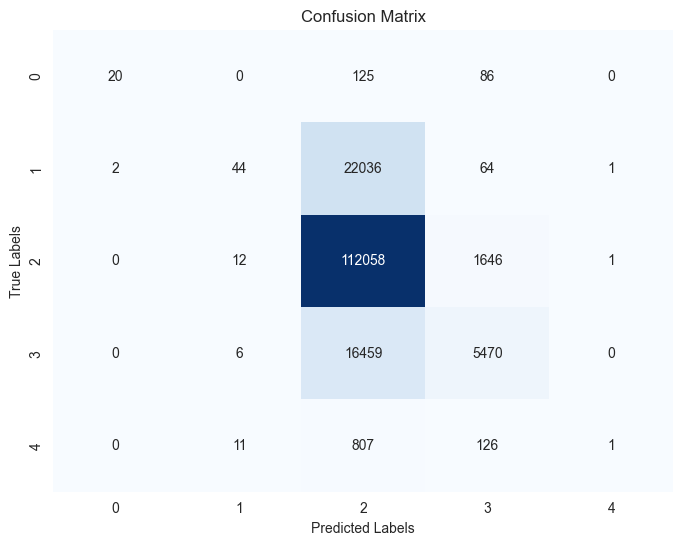

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = filtered_cab_data_train_encoded.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_encoded['fare_ratio_label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the logistic regression model with 'ovr' strategy
logreg = LogisticRegression(max_iter=1000, multi_class='ovr')
logreg.fit(X_train, y_train)

# Predicting on the test set
y_pred = logreg.predict(X_test)

# Calculating precision, recall, F1-score, and confusion matrix
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(report)

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.67      0.67    113590
           1       0.62      0.71      0.66    113576
           2       0.60      0.72      0.66    113577
           3       0.67      0.39      0.49    114287
           4       0.55      0.61      0.58    113841

    accuracy                           0.62    568871
   macro avg       0.62      0.62      0.61    568871
weighted avg       0.62      0.62      0.61    568871



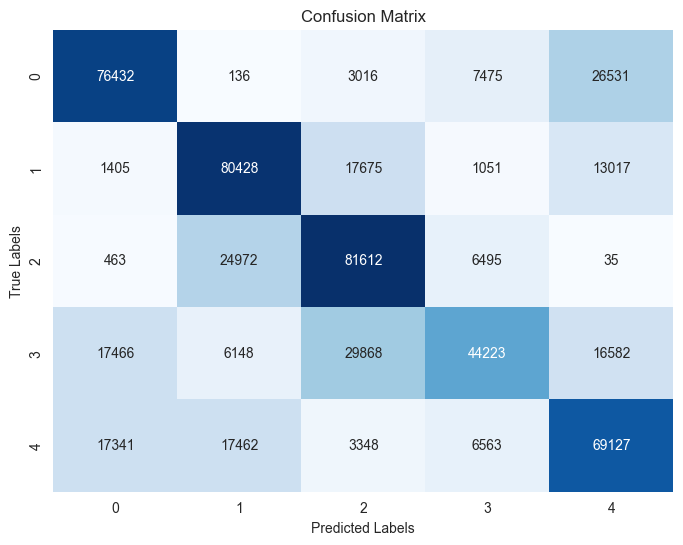

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = filtered_cab_data_train_balanced.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_balanced['fare_ratio_label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the logistic regression model with 'ovr' strategy
logreg = LogisticRegression(max_iter=1000, multi_class='ovr')
logreg.fit(X_train, y_train)

# Predicting on the test set
y_pred = logreg.predict(X_test)

# Calculating precision, recall, F1-score, and confusion matrix
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(report)

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.23      0.35    113590
           1       0.42      0.18      0.25    113576
           2       0.38      0.80      0.52    113577
           3       0.30      0.53      0.38    114287
           4       0.39      0.17      0.24    113841

    accuracy                           0.38    568871
   macro avg       0.46      0.38      0.35    568871
weighted avg       0.46      0.38      0.35    568871



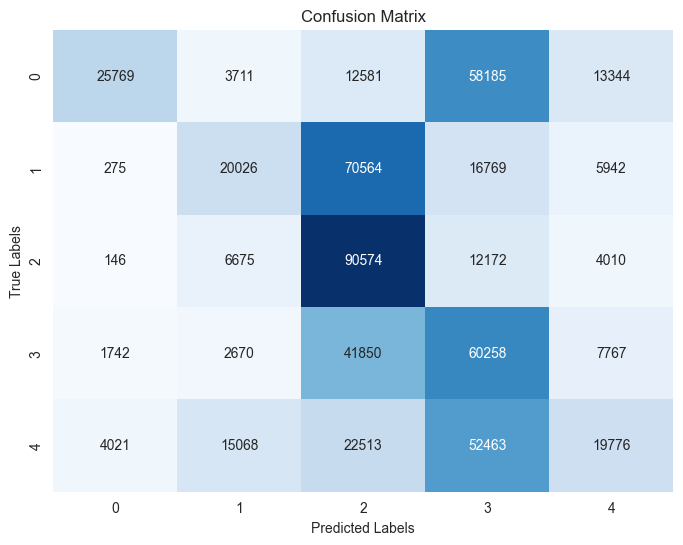

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

X = filtered_cab_data_train_balanced.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_balanced['fare_ratio_label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred = nb_classifier.predict(X_test)

# Calculating precision, recall, F1-score, and confusion matrix
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(report)

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113590
           1       0.70      0.77      0.73    113576
           2       0.60      0.58      0.59    113577
           3       0.77      0.71      0.74    114287
           4       0.89      0.89      0.89    113841

    accuracy                           0.79    568871
   macro avg       0.79      0.79      0.79    568871
weighted avg       0.79      0.79      0.79    568871



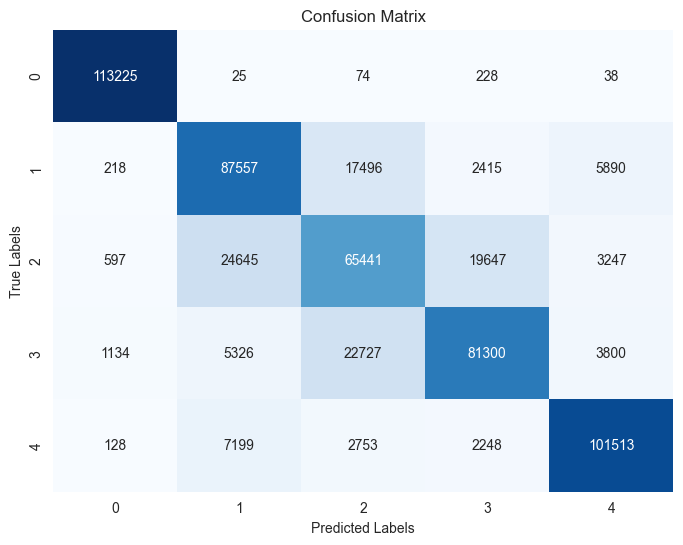

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix


X = filtered_cab_data_train_balanced.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_balanced['fare_ratio_label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the decision tree classifier
dt_classifier = DecisionTreeClassifier(min_samples_leaf= 10, max_features=0.8, random_state=42)
dt_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred = dt_classifier.predict(X_test)

# Calculating precision, recall, F1-score, and confusion matrix
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(report)

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    113590
           1       0.72      0.82      0.77    113576
           2       0.67      0.62      0.64    113577
           3       0.81      0.78      0.79    114287
           4       0.93      0.91      0.92    113841

    accuracy                           0.82    568871
   macro avg       0.83      0.82      0.82    568871
weighted avg       0.83      0.82      0.82    568871



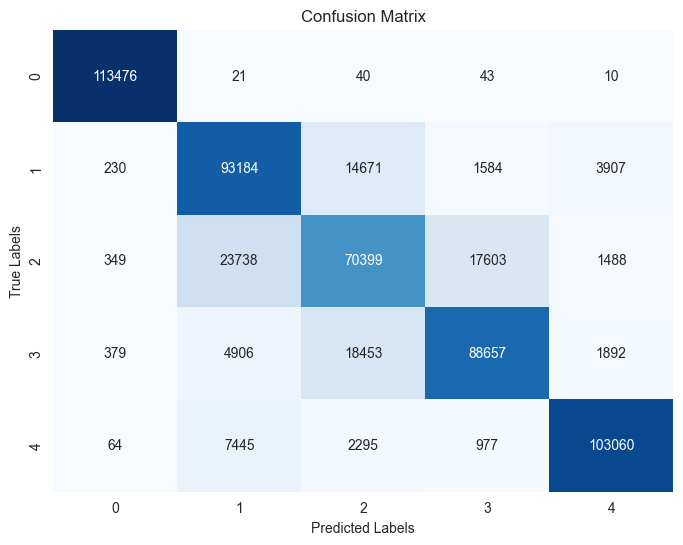

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = filtered_cab_data_train_balanced.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_balanced['fare_ratio_label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, max_features=0.8, bootstrap=True, n_jobs=8, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred = rf_classifier.predict(X_test)

# Calculating precision, recall, F1-score, and confusion matrix
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(report)

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    113590
           1       0.73      0.84      0.78    113576
           2       0.69      0.64      0.66    113577
           3       0.83      0.79      0.81    114287
           4       0.95      0.93      0.94    113841

    accuracy                           0.84    568871
   macro avg       0.84      0.84      0.84    568871
weighted avg       0.84      0.84      0.84    568871



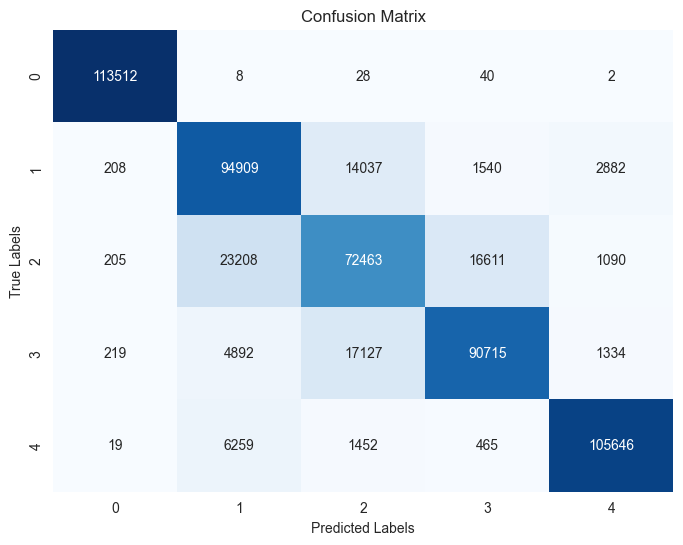

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X = filtered_cab_data_train_balanced.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_balanced['fare_ratio_label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the ExtraTreesClassifier
et_classifier = ExtraTreesClassifier(n_estimators=100, min_samples_leaf=10,max_features= 0.8, bootstrap=True, n_jobs=8, random_state=42)
et_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred = et_classifier.predict(X_test)

# Calculating precision, recall, F1-score, and confusion matrix
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(report)

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113590
           1       0.86      0.89      0.87    113576
           2       0.80      0.79      0.79    113577
           3       0.91      0.89      0.90    114287
           4       1.00      1.00      1.00    113841

    accuracy                           0.91    568871
   macro avg       0.91      0.91      0.91    568871
weighted avg       0.91      0.91      0.91    568871

Precision: 0.9117302494940627
Recall: 0.9117005437085033
F1-score: 0.9116182751343516


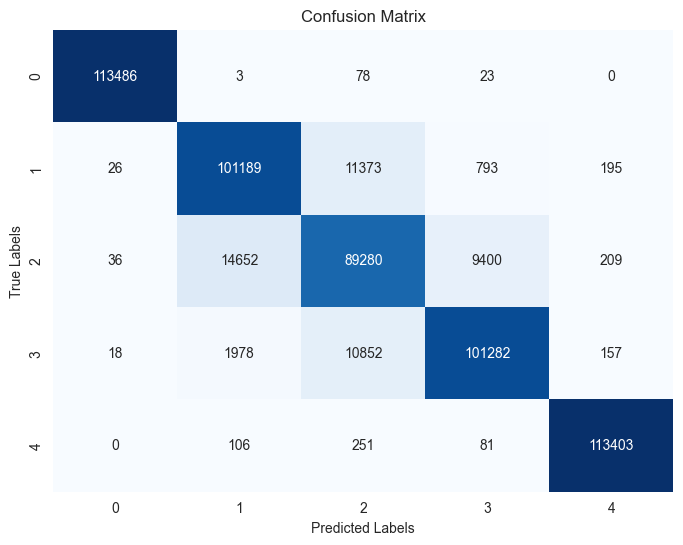

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import xgboost as xgb

X = filtered_cab_data_train_balanced.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_balanced['fare_ratio_label']

# Encoding the target labels to start from 0
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initializing and training the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=500, max_depth=30, device='cuda', colsample_bytree= 0.8, objective='multi:softmax', nthread=8, random_state=42)
xgb_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred = xgb_classifier.predict(X_test)

# Transforming predicted labels back to original form for evaluation
y_pred_original = label_encoder.inverse_transform(y_pred)

# Calculating precision, recall, F1-score, and confusion matrix
report = classification_report(label_encoder.inverse_transform(y_test), y_pred_original)
conf_matrix = confusion_matrix(label_encoder.inverse_transform(y_test), y_pred_original)
precision = precision_score(label_encoder.inverse_transform(y_test), y_pred_original, average='weighted')
recall = recall_score(label_encoder.inverse_transform(y_test), y_pred_original, average='weighted')
f1 = f1_score(label_encoder.inverse_transform(y_test), y_pred_original, average='weighted')

print("Classification Report:")
print(report)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 455281, number of negative: 1820203
[LightGBM] [Info] Number of positive: 455295, number of negative: 1820189
[LightGBM] [Info] Number of positive: 455294, number of negative: 1820190
[LightGBM] [Info] Number of positive: 454584, number of negative: 1820900
[LightGBM] [Info] Number of positive: 455030, number of negative: 1820454
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 2275484, number of used features: 82
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of hist

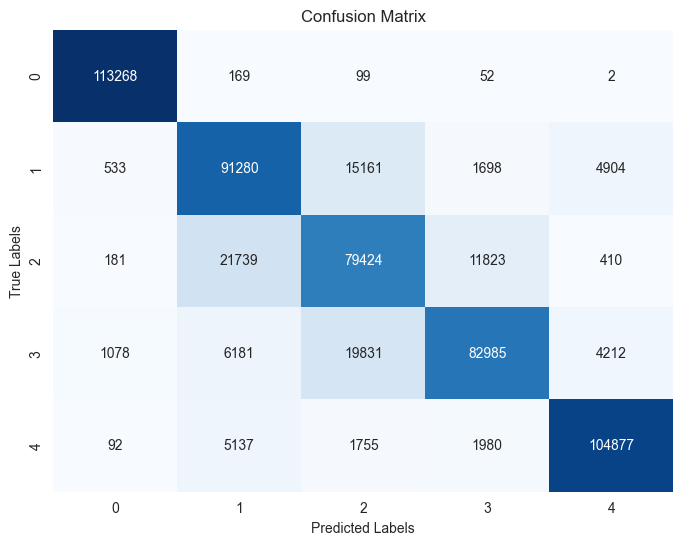

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

X = filtered_cab_data_train_balanced.drop(columns=['fare_ratio_label', 'fare_amount'], axis=1)
y = filtered_cab_data_train_balanced['fare_ratio_label']

# Encoding the target labels to start from 0
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initializing and training the LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(n_estimators=500, num_leaves=50, device_type='gpu', objective='multiclassova', bagging_fraction=0.8, n_jobs=8, random_state=42)
lgb_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred = lgb_classifier.predict(X_test)

# Transforming predicted labels back to original form for evaluation
y_pred_original = label_encoder.inverse_transform(y_pred)

# Calculating precision, recall, F1-score, and confusion matrix
report = classification_report(label_encoder.inverse_transform(y_test), y_pred_original)
conf_matrix = confusion_matrix(label_encoder.inverse_transform(y_test), y_pred_original)
precision = precision_score(label_encoder.inverse_transform(y_test), y_pred_original, average='weighted')
recall = recall_score(label_encoder.inverse_transform(y_test), y_pred_original, average='weighted')
f1 = f1_score(label_encoder.inverse_transform(y_test), y_pred_original, average='weighted')

print("Classification Report:")
print(report)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<span style="color:yellow; font-weight:bold;"> Let's predict the feature fare_ratio_label and try to predict fare_amount form there to see if it works.</span>

In [ ]:
#Check for columns in train data, if fare_ratio_label and fare_amount is necessary and presnt

In [202]:
# Get the columns order from filtered_cab_data_train_balanced
train_columns_order = filtered_cab_data_train_balanced.drop(columns=['fare_ratio_label'], axis=1).columns

# Reorder columns in filtered_cab_data_test_encoded to match the order in train data
filtered_cab_data_test_encoded = filtered_cab_data_test_encoded[train_columns_order]


filtered_cab_data_test_encoded.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
31     0.827705        -0.477410    1.549519                  0.857272   
35     3.900582        -0.477410    1.549519                  2.442079   
36    -0.735598        -0.477410   -0.645361                 -0.680174   
69    -0.692269        -0.477410   -0.645361                 -0.672846   
89    -0.692269         1.403247   -0.645361                 -0.736700   

    is_holiday  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  \
31   -0.133997   False   False   False   False   False   False   False   
35   -0.133997   False   False    True   False   False   False   False   
36   -0.133997   False   False   False   False   False   False   False   
69   -0.133997   False   False   False   False   False   False   False   
89   -0.133997   False   False   False   False   False   False   False   

    hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
31   False   False    False    False    False    False    False    False   
35   False   False    False    False    False    False    False    False   
36    True   False    False    False    False    False    False    False   
69   False   False    False    False    False    False    False    False   
89   False   False    False    False    False    False     True    False   

    hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  \
31    False    False    False    False    False     True    False    False   
35    False    False    False    False    False    False    False    False   
36    False    False    False    False    False    False    False    False   
69    False    False    False    False    False    False    False     True   
89    False    False    False    False    False    False    False    False   

    month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
31    False    False    False    False     True    False    False    False   
35    False    False    False    False    False    False    False    False   
36    False     True    False    False    False    False    False    False   
69    False    False    False     True    False    False    False    False   
89    False     True    False    False    False    False    False    False   

    month_10  month_11  month_12  day_2  day_3  day_4  day_5  day_6  day_7  \
31     False     False     False  False  False  False  False  False  False   
35     False     False     False  False  False  False  False  False  False   
36     False     False     False  False  False  False  False  False  False   
69     False     False     False  False  False  False  False  False  False   
89     False     False     False  False  False   True  False  False  False   

    day_8  day_9  day_10  day_11  day_12  day_13  day_14  day_15  day_16  \
31  False  False   False   False   False   False   False   False   False   
35  False  False   False    True   False   False   False   False   False   
36  False  False   False   False    True   False   False   False   False   
69  False  False   False   False    True   False   False   False   False   
89  False  False   False   False   False   False   False   False   False   

    day_17  day_18  day_19  day_20  day_21  day_22  day_23  day_24  day_25  \
31   False   False   False   False    True   False   False   False   False   
35   False   False   False   False   False   False   False   False   False   
36   False   False   False   False   False   False   False   False   False   
69   False   False   False   False   False   False   False   False   False   
89   False   False   False   False   False   False   False   False   False   

    day_26  day_27  day_28  day_29  day_30  day_31  day_of_week_1  \
31   False   False   False   False   False   False          False   
35   False   False   False   False   False   False          False   
36   False   False   False   False   False   False          False   
69   False   False   False   False   False   Fal

In [203]:
# Use the trained xgb_classifier to predict fare_ratio_label for test data
filtered_cab_data_test_encoded_xgb_test= filtered_cab_data_test_encoded.copy()

test_features = filtered_cab_data_test_encoded_xgb_test.drop(columns=['fare_amount'], axis=1)

predicted_labels = xgb_classifier.predict(test_features)

filtered_cab_data_test_encoded_xgb_test['fare_ratio_label'] = predicted_labels

filtered_cab_data_test_encoded_xgb_test.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
31     0.827705        -0.477410    1.549519                  0.857272   
35     3.900582        -0.477410    1.549519                  2.442079   
36    -0.735598        -0.477410   -0.645361                 -0.680174   
69    -0.692269        -0.477410   -0.645361                 -0.672846   
89    -0.692269         1.403247   -0.645361                 -0.736700   

    is_holiday  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  \
31   -0.133997   False   False   False   False   False   False   False   
35   -0.133997   False   False    True   False   False   False   False   
36   -0.133997   False   False   False   False   False   False   False   
69   -0.133997   False   False   False   False   False   False   False   
89   -0.133997   False   False   False   False   False   False   False   

    hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
31   False   False    False    False    False    False    False    False   
35   False   False    False    False    False    False    False    False   
36    True   False    False    False    False    False    False    False   
69   False   False    False    False    False    False    False    False   
89   False   False    False    False    False    False     True    False   

    hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  \
31    False    False    False    False    False     True    False    False   
35    False    False    False    False    False    False    False    False   
36    False    False    False    False    False    False    False    False   
69    False    False    False    False    False    False    False     True   
89    False    False    False    False    False    False    False    False   

    month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
31    False    False    False    False     True    False    False    False   
35    False    False    False    False    False    False    False    False   
36    False     True    False    False    False    False    False    False   
69    False    False    False     True    False    False    False    False   
89    False     True    False    False    False    False    False    False   

    month_10  month_11  month_12  day_2  day_3  day_4  day_5  day_6  day_7  \
31     False     False     False  False  False  False  False  False  False   
35     False     False     False  False  False  False  False  False  False   
36     False     False     False  False  False  False  False  False  False   
69     False     False     False  False  False  False  False  False  False   
89     False     False     False  False  False   True  False  False  False   

    day_8  day_9  day_10  day_11  day_12  day_13  day_14  day_15  day_16  \
31  False  False   False   False   False   False   False   False   False   
35  False  False   False    True   False   False   False   False   False   
36  False  False   False   False    True   False   False   False   False   
69  False  False   False   False    True   False   False   False   False   
89  False  False   False   False   False   False   False   False   False   

    day_17  day_18  day_19  day_20  day_21  day_22  day_23  day_24  day_25  \
31   False   False   False   False    True   False   False   False   False   
35   False   False   False   False   False   False   False   False   False   
36   False   False   False   False   False   False   False   False   False   
69   False   False   False   False   False   False   False   False   False   
89   False   False   False   False   False   False   False   False   False   

    day_26  day_27  day_28  day_29  day_30  day_31  day_of_week_1  \
31   False   False   False   False   False   False          False   
35   False   False   False   False   False   False          False   
36   False   False   False   False   False   False          False   
69   False   False   False   False   False   Fal

In [204]:
# Get the columns order from filtered_cab_data_train_balanced
train_columns_order = filtered_cab_data_train_encoded.columns

# Reorder columns in filtered_cab_data_test_encoded to match the order in train data
filtered_cab_data_test_encoded_xgb_test = filtered_cab_data_test_encoded_xgb_test[train_columns_order]


filtered_cab_data_test_encoded_xgb_test.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
31     0.827705        -0.477410    1.549519                  0.857272   
35     3.900582        -0.477410    1.549519                  2.442079   
36    -0.735598        -0.477410   -0.645361                 -0.680174   
69    -0.692269        -0.477410   -0.645361                 -0.672846   
89    -0.692269         1.403247   -0.645361                 -0.736700   

    is_holiday  fare_ratio_label  hour_1  hour_2  hour_3  hour_4  hour_5  \
31   -0.133997                 2   False   False   False   False   False   
35   -0.133997                 2   False   False    True   False   False   
36   -0.133997                 1   False   False   False   False   False   
69   -0.133997                 1   False   False   False   False   False   
89   -0.133997                 2   False   False   False   False   False   

    hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  \
31   False   False   False   False    False    False    False    False   
35   False   False   False   False    False    False    False    False   
36   False   False    True   False    False    False    False    False   
69   False   False   False   False    False    False    False    False   
89   False   False   False   False    False    False    False    False   

    hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
31    False    False    False    False    False    False    False     True   
35    False    False    False    False    False    False    False    False   
36    False    False    False    False    False    False    False    False   
69    False    False    False    False    False    False    False    False   
89     True    False    False    False    False    False    False    False   

    hour_22  hour_23  month_2  month_3  month_4  month_5  month_6  month_7  \
31    False    False    False    False    False    False     True    False   
35    False    False    False    False    False    False    False    False   
36    False    False    False     True    False    False    False    False   
69    False     True    False    False    False     True    False    False   
89    False    False    False     True    False    False    False    False   

    month_8  month_9  month_10  month_11  month_12  day_2  day_3  day_4  \
31    False    False     False     False     False  False  False  False   
35    False    False     False     False     False  False  False  False   
36    False    False     False     False     False  False  False  False   
69    False    False     False     False     False  False  False  False   
89    False    False     False     False     False  False  False   True   

    day_5  day_6  day_7  day_8  day_9  day_10  day_11  day_12  day_13  day_14  \
31  False  False  False  False  False   False   False   False   False   False   
35  False  False  False  False  False   False    True   False   False   False   
36  False  False  False  False  False   False   False    True   False   False   
69  False  False  False  False  False   False   False    True   False   False   
89  False  False  False  False  False   False   False   False   False   False   

    day_15  day_16  day_17  day_18  day_19  day_20  day_21  day_22  day_23  \
31   False   False   False   False   False   False    True   False   False   
35   False   False   False   False   False   False   False   False   False   
36   False   False   False   False   False   False   False   False   False   
69   False   False   False   False   False   False   False   False   False   
89   False   False   False   False   False   False   False   False   False   

    day_24  day_25  day_26  day_27  day_28  day_29  day_30  day_31  \
31   False   False   False   False   False   False   False   False   
35   False   False   False   False   False   False   False   False   
36   False   False   False   False   False   False   False   False   
69   False   False   False   Fal

In [205]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Splitting the data into train and test sets
X_train = filtered_cab_data_train_encoded.drop(columns=['fare_amount'], axis=1)
y_train = filtered_cab_data_train_encoded['fare_amount']

X_test = filtered_cab_data_test_encoded_xgb_test.drop(columns=['fare_amount'], axis=1)
y_test = filtered_cab_data_test_encoded_xgb_test['fare_amount']

# Initializing and training the XGBoost Regressor
xgb_reg = XGBRegressor(device='cuda', nthread=8, colsample_bytree=0.8, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = xgb_reg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.3531646254355604
Root Mean Squared Error: 0.5942765563570217
R-squared: 0.6468353745644397


In [194]:
# Use the trained xgb_classifier to predict fare_ratio_label for test data
filtered_cab_data_test_encoded_et_test= filtered_cab_data_test_encoded.copy()

test_features = filtered_cab_data_test_encoded_et_test.drop(columns=['fare_amount'], axis=1)

predicted_labels = et_classifier.predict(test_features)

filtered_cab_data_test_encoded_et_test['fare_ratio_label'] = predicted_labels

filtered_cab_data_test_encoded_et_test.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
31     0.827705        -0.477410    1.549519                  0.857272   
35     3.900582        -0.477410    1.549519                  2.442079   
36    -0.735598        -0.477410   -0.645361                 -0.680174   
69    -0.692269        -0.477410   -0.645361                 -0.672846   
89    -0.692269         1.403247   -0.645361                 -0.736700   

    is_holiday  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  \
31   -0.133997   False   False   False   False   False   False   False   
35   -0.133997   False   False    True   False   False   False   False   
36   -0.133997   False   False   False   False   False   False   False   
69   -0.133997   False   False   False   False   False   False   False   
89   -0.133997   False   False   False   False   False   False   False   

    hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
31   False   False    False    False    False    False    False    False   
35   False   False    False    False    False    False    False    False   
36    True   False    False    False    False    False    False    False   
69   False   False    False    False    False    False    False    False   
89   False   False    False    False    False    False     True    False   

    hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  \
31    False    False    False    False    False     True    False    False   
35    False    False    False    False    False    False    False    False   
36    False    False    False    False    False    False    False    False   
69    False    False    False    False    False    False    False     True   
89    False    False    False    False    False    False    False    False   

    month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
31    False    False    False    False     True    False    False    False   
35    False    False    False    False    False    False    False    False   
36    False     True    False    False    False    False    False    False   
69    False    False    False     True    False    False    False    False   
89    False     True    False    False    False    False    False    False   

    month_10  month_11  month_12  day_2  day_3  day_4  day_5  day_6  day_7  \
31     False     False     False  False  False  False  False  False  False   
35     False     False     False  False  False  False  False  False  False   
36     False     False     False  False  False  False  False  False  False   
69     False     False     False  False  False  False  False  False  False   
89     False     False     False  False  False   True  False  False  False   

    day_8  day_9  day_10  day_11  day_12  day_13  day_14  day_15  day_16  \
31  False  False   False   False   False   False   False   False   False   
35  False  False   False    True   False   False   False   False   False   
36  False  False   False   False    True   False   False   False   False   
69  False  False   False   False    True   False   False   False   False   
89  False  False   False   False   False   False   False   False   False   

    day_17  day_18  day_19  day_20  day_21  day_22  day_23  day_24  day_25  \
31   False   False   False   False    True   False   False   False   False   
35   False   False   False   False   False   False   False   False   False   
36   False   False   False   False   False   False   False   False   False   
69   False   False   False   False   False   False   False   False   False   
89   False   False   False   False   False   False   False   False   False   

    day_26  day_27  day_28  day_29  day_30  day_31  day_of_week_1  \
31   False   False   False   False   False   False          False   
35   False   False   False   False   False   False          False   
36   False   False   False   False   False   False          False   
69   False   False   False   False   False   Fal

In [195]:
# Get the columns order from filtered_cab_data_train_balanced
train_columns_order = filtered_cab_data_train_encoded.columns

filtered_cab_data_test_encoded_et_test = filtered_cab_data_test_encoded_et_test[train_columns_order]

filtered_cab_data_test_encoded_et_test.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
31     0.827705        -0.477410    1.549519                  0.857272   
35     3.900582        -0.477410    1.549519                  2.442079   
36    -0.735598        -0.477410   -0.645361                 -0.680174   
69    -0.692269        -0.477410   -0.645361                 -0.672846   
89    -0.692269         1.403247   -0.645361                 -0.736700   

    is_holiday  fare_ratio_label  hour_1  hour_2  hour_3  hour_4  hour_5  \
31   -0.133997                 3   False   False   False   False   False   
35   -0.133997                 3   False   False    True   False   False   
36   -0.133997                 1   False   False   False   False   False   
69   -0.133997                 1   False   False   False   False   False   
89   -0.133997                 1   False   False   False   False   False   

    hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  \
31   False   False   False   False    False    False    False    False   
35   False   False   False   False    False    False    False    False   
36   False   False    True   False    False    False    False    False   
69   False   False   False   False    False    False    False    False   
89   False   False   False   False    False    False    False    False   

    hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
31    False    False    False    False    False    False    False     True   
35    False    False    False    False    False    False    False    False   
36    False    False    False    False    False    False    False    False   
69    False    False    False    False    False    False    False    False   
89     True    False    False    False    False    False    False    False   

    hour_22  hour_23  month_2  month_3  month_4  month_5  month_6  month_7  \
31    False    False    False    False    False    False     True    False   
35    False    False    False    False    False    False    False    False   
36    False    False    False     True    False    False    False    False   
69    False     True    False    False    False     True    False    False   
89    False    False    False     True    False    False    False    False   

    month_8  month_9  month_10  month_11  month_12  day_2  day_3  day_4  \
31    False    False     False     False     False  False  False  False   
35    False    False     False     False     False  False  False  False   
36    False    False     False     False     False  False  False  False   
69    False    False     False     False     False  False  False  False   
89    False    False     False     False     False  False  False   True   

    day_5  day_6  day_7  day_8  day_9  day_10  day_11  day_12  day_13  day_14  \
31  False  False  False  False  False   False   False   False   False   False   
35  False  False  False  False  False   False    True   False   False   False   
36  False  False  False  False  False   False   False    True   False   False   
69  False  False  False  False  False   False   False    True   False   False   
89  False  False  False  False  False   False   False   False   False   False   

    day_15  day_16  day_17  day_18  day_19  day_20  day_21  day_22  day_23  \
31   False   False   False   False   False   False    True   False   False   
35   False   False   False   False   False   False   False   False   False   
36   False   False   False   False   False   False   False   False   False   
69   False   False   False   False   False   False   False   False   False   
89   False   False   False   False   False   False   False   False   False   

    day_24  day_25  day_26  day_27  day_28  day_29  day_30  day_31  \
31   False   False   False   False   False   False   False   False   
35   False   False   False   False   False   False   False   False   
36   False   False   False   False   False   False   False   False   
69   False   False   False   Fal

In [196]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Splitting the data into train and test sets
X_train = filtered_cab_data_train_encoded.drop(columns=['fare_amount'], axis=1)
y_train = filtered_cab_data_train_encoded['fare_amount']

X_test = filtered_cab_data_test_encoded_et_test.drop(columns=['fare_amount'], axis=1)
y_test = filtered_cab_data_test_encoded_et_test['fare_amount']

# Initializing and training the XGBoost Regressor
xgb_reg = XGBRegressor(device='cuda', nthread=8, colsample_bytree=0.8, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = xgb_reg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.5820547799431431
Root Mean Squared Error: 0.7629251470119092
R-squared: 0.4179452200568571


In [197]:
# Use the trained xgb_classifier to predict fare_ratio_label for test data
filtered_cab_data_test_encoded_lgb_test= filtered_cab_data_test_encoded.copy()

test_features = filtered_cab_data_test_encoded_lgb_test.drop(columns=['fare_amount'], axis=1)

predicted_labels = lgb_classifier.predict(test_features)

filtered_cab_data_test_encoded_lgb_test['fare_ratio_label'] = predicted_labels

filtered_cab_data_test_encoded_lgb_test.head()

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
31     0.827705        -0.477410    1.549519                  0.857272   
35     3.900582        -0.477410    1.549519                  2.442079   
36    -0.735598        -0.477410   -0.645361                 -0.680174   
69    -0.692269        -0.477410   -0.645361                 -0.672846   
89    -0.692269         1.403247   -0.645361                 -0.736700   

    is_holiday  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  \
31   -0.133997   False   False   False   False   False   False   False   
35   -0.133997   False   False    True   False   False   False   False   
36   -0.133997   False   False   False   False   False   False   False   
69   -0.133997   False   False   False   False   False   False   False   
89   -0.133997   False   False   False   False   False   False   False   

    hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
31   False   False    False    False    False    False    False    False   
35   False   False    False    False    False    False    False    False   
36    True   False    False    False    False    False    False    False   
69   False   False    False    False    False    False    False    False   
89   False   False    False    False    False    False     True    False   

    hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  \
31    False    False    False    False    False     True    False    False   
35    False    False    False    False    False    False    False    False   
36    False    False    False    False    False    False    False    False   
69    False    False    False    False    False    False    False     True   
89    False    False    False    False    False    False    False    False   

    month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
31    False    False    False    False     True    False    False    False   
35    False    False    False    False    False    False    False    False   
36    False     True    False    False    False    False    False    False   
69    False    False    False     True    False    False    False    False   
89    False     True    False    False    False    False    False    False   

    month_10  month_11  month_12  day_2  day_3  day_4  day_5  day_6  day_7  \
31     False     False     False  False  False  False  False  False  False   
35     False     False     False  False  False  False  False  False  False   
36     False     False     False  False  False  False  False  False  False   
69     False     False     False  False  False  False  False  False  False   
89     False     False     False  False  False   True  False  False  False   

    day_8  day_9  day_10  day_11  day_12  day_13  day_14  day_15  day_16  \
31  False  False   False   False   False   False   False   False   False   
35  False  False   False    True   False   False   False   False   False   
36  False  False   False   False    True   False   False   False   False   
69  False  False   False   False    True   False   False   False   False   
89  False  False   False   False   False   False   False   False   False   

    day_17  day_18  day_19  day_20  day_21  day_22  day_23  day_24  day_25  \
31   False   False   False   False    True   False   False   False   False   
35   False   False   False   False   False   False   False   False   False   
36   False   False   False   False   False   False   False   False   False   
69   False   False   False   False   False   False   False   False   False   
89   False   False   False   False   False   False   False   False   False   

    day_26  day_27  day_28  day_29  day_30  day_31  day_of_week_1  \
31   False   False   False   False   False   False          False   
35   False   False   False   False   False   False          False   
36   False   False   False   False   False   False          False   
69   False   False   False   False   False   Fal

In [198]:
# Get the columns order from filtered_cab_data_train_balanced
train_columns_order = filtered_cab_data_train_encoded.columns

filtered_cab_data_test_encoded_lgb_test = filtered_cab_data_test_encoded_lgb_test[train_columns_order]

filtered_cab_data_test_encoded_lgb_test.head()

fare_amount  passenger_count  is_weekend  driving_duration_in_mins  \
31     0.827705        -0.477410    1.549519                  0.857272   
35     3.900582        -0.477410    1.549519                  2.442079   
36    -0.735598        -0.477410   -0.645361                 -0.680174   
69    -0.692269        -0.477410   -0.645361                 -0.672846   
89    -0.692269         1.403247   -0.645361                 -0.736700   

    is_holiday  fare_ratio_label  hour_1  hour_2  hour_3  hour_4  hour_5  \
31   -0.133997                 4   False   False   False   False   False   
35   -0.133997                 3   False   False    True   False   False   
36   -0.133997                 1   False   False   False   False   False   
69   -0.133997                 1   False   False   False   False   False   
89   -0.133997                 1   False   False   False   False   False   

    hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  \
31   False   False   False   False    False    False    False    False   
35   False   False   False   False    False    False    False    False   
36   False   False    True   False    False    False    False    False   
69   False   False   False   False    False    False    False    False   
89   False   False   False   False    False    False    False    False   

    hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
31    False    False    False    False    False    False    False     True   
35    False    False    False    False    False    False    False    False   
36    False    False    False    False    False    False    False    False   
69    False    False    False    False    False    False    False    False   
89     True    False    False    False    False    False    False    False   

    hour_22  hour_23  month_2  month_3  month_4  month_5  month_6  month_7  \
31    False    False    False    False    False    False     True    False   
35    False    False    False    False    False    False    False    False   
36    False    False    False     True    False    False    False    False   
69    False     True    False    False    False     True    False    False   
89    False    False    False     True    False    False    False    False   

    month_8  month_9  month_10  month_11  month_12  day_2  day_3  day_4  \
31    False    False     False     False     False  False  False  False   
35    False    False     False     False     False  False  False  False   
36    False    False     False     False     False  False  False  False   
69    False    False     False     False     False  False  False  False   
89    False    False     False     False     False  False  False   True   

    day_5  day_6  day_7  day_8  day_9  day_10  day_11  day_12  day_13  day_14  \
31  False  False  False  False  False   False   False   False   False   False   
35  False  False  False  False  False   False    True   False   False   False   
36  False  False  False  False  False   False   False    True   False   False   
69  False  False  False  False  False   False   False    True   False   False   
89  False  False  False  False  False   False   False   False   False   False   

    day_15  day_16  day_17  day_18  day_19  day_20  day_21  day_22  day_23  \
31   False   False   False   False   False   False    True   False   False   
35   False   False   False   False   False   False   False   False   False   
36   False   False   False   False   False   False   False   False   False   
69   False   False   False   False   False   False   False   False   False   
89   False   False   False   False   False   False   False   False   False   

    day_24  day_25  day_26  day_27  day_28  day_29  day_30  day_31  \
31   False   False   False   False   False   False   False   False   
35   False   False   False   False   False   False   False   False   
36   False   False   False   False   False   False   False   False   
69   False   False   False   Fal

In [200]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Splitting the data into train and test sets
X_train = filtered_cab_data_train_encoded.drop(columns=['fare_amount'], axis=1)
y_train = filtered_cab_data_train_encoded['fare_amount']

X_test = filtered_cab_data_test_encoded_lgb_test.drop(columns=['fare_amount'], axis=1)
y_test = filtered_cab_data_test_encoded_lgb_test['fare_amount']

# Initializing and training the LightGBM Regressor
lgbm_reg = LGBMRegressor(device_type='gpu', bagging_fraction=0.8, n_jobs=8, random_state=42)
lgbm_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = lgbm_reg.predict(X_test)

# Calculating metrics - Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 794872, number of used features: 83
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6 dense feature groups (6.06 MB) transferred to GPU in 0.009975 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Mean Squared Error: 6.83391635523874
Root Mean Squared Error: 2.614176